In [1]:
import zfit

In [2]:
from python.header import *

Welcome to JupyROOT 6.22/02


# TOSTIS prototype

In [3]:
MIN_P = 10_000; MAX_P = 100_000; # I know these are the ranges I care about for muon momentum from Bc2D0MuNuX sel
MIN_M = 5200; MAX_M = 5700; 

In [4]:
#B2JpsiK_file = uproot.open("root://eoslhcb.cern.ch//eos/lhcb/user/a/atully/B2emu/data/2018/MagUp/all.root")
#B2JpsiK_file.keys()

In [5]:
# branchList = ROOT.vector('string')()
# for branchName in ["muplus_L0MuonDecision_TOS", "muminus_L0MuonDecision_TOS", "Bplus_L0Global_TIS", "Kplus_P", "Kplus_PT", "Bplus_M"]: 
#      branchList.push_back(branchName)

# sel_string = f"Kplus_PIDK>0 && Bplus_M>{MIN_M} && Bplus_M<{MAX_M} && (Kplus_P>{MIN_P} && Kplus_P<{MAX_P}) && (Kplus_PT>1500 && Kplus_PT<20000)"
# in_RDF = RDF("B2JpsimmKTuple/DecayTree", f"root://eoslhcb.cern.ch//eos/lhcb/user/a/atully/B2emu/data/2018/MagUp/all.root", branchList).Filter(f"{sel_string}")

In [6]:
#tmp_outRDF = in_RDF.Snapshot("DecayTree", "scratch/test_B2JpsiK.root", branchList)

In [7]:
B2JpsiK_infile = uproot.open("scratch/test_B2JpsiK.root:DecayTree")
b2jpsik_df = B2JpsiK_infile.arrays(library="pd")

In [8]:
mrange = (MIN_M,MAX_M)
mbins = 50
pbins = 10

In [9]:
# pbins-1 regular bins in [1500, 10_000] + 1 to infty
pt_edges = np.append(np.linspace(1500, 10_000, pbins-1), [20_000])

In [10]:
# muon_TOS && B GlobalTIS
h_TOSTIS = Hist( 
        hist.axis.Regular(pbins, MIN_P, MAX_P, label=rf"$p(K)$   $[MeV/c]$", name="kaon_p", underflow=False, overflow=False), 
        hist.axis.Variable(pt_edges, label=rf"$p_T(K)$   $[MeV/c]$", name="kaon_pt", underflow=False, overflow=False),  
        hist.axis.Regular(mbins, *mrange, label=rf"$m(B)$   $[MeV/c^2]$", name="b_mass", underflow=False, overflow=False), 
        storage=hist.storage.Double()
    )

#B Global TIS
h_TOS = Hist( 
        hist.axis.Regular(pbins, MIN_P, MAX_P, label=rf"$p(K)$   $[MeV/c]$", name="kaon_p", underflow=False, overflow=False), 
        hist.axis.Variable(pt_edges, label=rf"$p_T(K)$   $[MeV/c]$", name="kaon_pt", underflow=False, overflow=False),  
        hist.axis.Regular(mbins, *mrange, label=rf"$m(B)$   $[MeV/c^2]$", name="b_mass", underflow=False, overflow=False), 
        storage=hist.storage.Double()
    )

TOSTIS_bmass = b2jpsik_df.query("(muplus_L0MuonDecision_TOS==True or muminus_L0MuonDecision_TOS==True) and Bplus_L0Global_TIS==True")["Bplus_M"].to_numpy()
TOSTIS_kp    = b2jpsik_df.query("(muplus_L0MuonDecision_TOS==True or muminus_L0MuonDecision_TOS==True) and Bplus_L0Global_TIS==True")["Kplus_P"].to_numpy()
TOSTIS_kpt   = b2jpsik_df.query("(muplus_L0MuonDecision_TOS==True or muminus_L0MuonDecision_TOS==True) and Bplus_L0Global_TIS==True")["Kplus_PT"].to_numpy()

# fill 
h_TOSTIS.fill(
        TOSTIS_kp,
        TOSTIS_kpt,
        TOSTIS_bmass, 
)

TOS_bmass = b2jpsik_df.query("(muplus_L0MuonDecision_TOS==True or muminus_L0MuonDecision_TOS==True)")["Bplus_M"].to_numpy()
TOS_kp    = b2jpsik_df.query("(muplus_L0MuonDecision_TOS==True or muminus_L0MuonDecision_TOS==True)")["Kplus_P"].to_numpy()
TOS_kpt   = b2jpsik_df.query("(muplus_L0MuonDecision_TOS==True or muminus_L0MuonDecision_TOS==True)")["Kplus_PT"].to_numpy()

h_TOS.fill(
        TOS_kp,
        TOS_kpt,
        TOS_bmass,
)

Hist(
  Regular(10, 10000, 100000, underflow=False, overflow=False, name='kaon_p', label='$p(K)$   $[MeV/c]$'),
  Variable([1500, 2562.5, 3625, 4687.5, 5750, 6812.5, 7875, 8937.5, 10000, 20000], underflow=False, overflow=False),
  Regular(50, 5200, 5700, underflow=False, overflow=False, name='b_mass', label='$m(B)$   $[MeV/c^2]$'),
  storage=Double()) # Sum: 308142.0

In [11]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# axs[0].errorbar(x=h_TOSTIS.axes["b_mass"].centers, y=h_TOSTIS.project("b_mass").view(), fmt=".", 
#                markersize=1, xerr=h_TOSTIS.axes["b_mass"].widths/2, elinewidth=1, 
#                yerr=np.sqrt(h_TOSTIS.project("b_mass").view()),
#                color="black", label=r"$\mu$TOS \& $B$GlobalTIS",
#                capsize=1, markeredgewidth=1)

# axs[1].errorbar(x=h_TOS.axes["b_mass"].centers, y=h_TOS.project("b_mass").view(), fmt=".", 
#                markersize=1, xerr=h_TOS.axes["b_mass"].widths/2, elinewidth=1, 
#                yerr=np.sqrt(h_TOS.project("b_mass").view()),
#                color="black", capsize=1, markeredgewidth=1,
#                label=r"$\mu$TOS",)


# axs[0].legend(fontsize=11)
# axs[1].legend(fontsize=11)
# axs[0].set_ylim(bottom=0)
# axs[1].set_ylim(bottom=0)

In [12]:
# === muon TOS fit ===
highmass_range=(5400, MAX_M)

# attempt to fix the tail parameter and then inherit the alpha par in the joint pdf dcb+exp
highmass = zfit.Space("upperm", limits=highmass_range)

highmass_spec = {}
highmass_spec["lambda"] = zfit.Parameter("lambda_exp_highmass", -.5, -2, 0)
highmass_exp_pdf = zfit.pdf.Exponential(highmass_spec["lambda"], obs=highmass)

# build the likelihood, minimise and errors (Hesse, see TM slides by Matt)
highmass_dset = zfit.Data.from_numpy(obs=highmass, array=TOS_bmass[TOS_bmass>=highmass_range[0]])
highmass_nll  = zfit.loss.UnbinnedNLL(model=highmass_exp_pdf, data=highmass_dset)

# minimise
minimizer = zfit.minimize.Minuit()
highmass_minimum = minimizer.minimize(highmass_nll)
_ = highmass_minimum.hesse()
print(highmass_minimum)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.517e+04                  │        Ncalls = 37 (37 total)        │
│ EDM = 2.95e-07 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
FitResult of
<UnbinnedNLL model=[<zfit.Exponential  params=[lambda_exp_highmass] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f62f10aae90>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═══

In [13]:
inherited_pars = {}
for var, val in highmass_minimum.params.items():
    inherited_pars[var.name]=val["value"]

In [14]:
# === read in the simulation ===

MC_branchList = ROOT.vector('string')()
for MC_branchName in ["Bplus_M"]: 
     MC_branchList.push_back(MC_branchName)

mc_sel_string = f"Bplus_M>{MIN_M} && Bplus_M<{MAX_M} && (Kplus_P>{MIN_P} && Kplus_P<{MAX_P}) && (Kplus_PT>1500 && Kplus_PT<20000) && Bplus_BKGCAT==0"
mc_in_RDF = RDF("B2JpsimmKTuple/DecayTree", f"root://eoslhcb.cern.ch//eos/lhcb/user/a/atully/B2emu/MC/2018/MagUp/B2JpsimumuK.root", branchList).Filter(f"{sel_string}")
mc_tmp_outRDF = mc_in_RDF.Snapshot("DecayTree", "scratch/test_MC_B2JpsiK.root", branchList)

MC_B2JpsiK_infile = uproot.open("scratch/test_MC_B2JpsiK.root:DecayTree")
MC_b2jpsik_df = MC_B2JpsiK_infile.arrays(library="pd")

# === muon TOS SIGNAL MC fit ===
sim_mass_range=(5200, 5400)

# attempt to fix the signal shape pars
sim_mass = zfit.Space("sig_m", limits=sim_mass_range)

sim_mass_spec = {}
sim_mass_spec["sig_mu"]       = zfit.Parameter("sig_mu"   , 5280, 5280-30, 5280+30 )
sim_mass_spec["sig_sigmal"]   = zfit.Parameter("sig_sigmal", 7,  5, 50)
sim_mass_spec["sig_sigmar"]   = zfit.Parameter("sig_sigmar", 7,  5, 50)
sim_mass_spec["sig_alphal"]   = zfit.Parameter("sig_alphal", 2, 0, 10 )
sim_mass_spec["sig_alphar"]   = zfit.Parameter("sig_alphar", 2, 0, 10 )
sim_mass_spec["sig_nl"]       = zfit.Parameter("sig_nl", 2, floating=False)
sim_mass_spec["sig_nr"]       = zfit.Parameter("sig_nr", 2, floating=False)
sim_mass_spec["frac"]         = zfit.Parameter("frac", 0.5, 0, 1.)

cb1_pdf = zfit.pdf.CrystalBall(
    obs   = sim_mass, 
    mu    = sim_mass_spec["sig_mu"], 
    sigma = sim_mass_spec["sig_sigmal"], 
    alpha= sim_mass_spec["sig_alphal"], 
    n    = sim_mass_spec["sig_nl"], 
)

cb2_pdf = zfit.pdf.CrystalBall(
    obs   = sim_mass, 
    mu    = sim_mass_spec["sig_mu"], 
    sigma = sim_mass_spec["sig_sigmar"], 
    alpha= sim_mass_spec["sig_alphar"], 
    n    = sim_mass_spec["sig_nr"], 
)

sim_mass_pdf = zfit.pdf.SumPDF( [cb1_pdf, cb2_pdf], fracs=[sim_mass_spec["frac"]] )

# build the likelihood, minimise and errors (Hesse, see TM slides by Matt)
sim_mass_dset = zfit.Data.from_numpy(obs=sim_mass, array=MC_b2jpsik_df["Bplus_M"].to_numpy())
sim_mass_nll  = zfit.loss.UnbinnedNLL(model=sim_mass_pdf, data=sim_mass_dset)

# minimise
sim_minimizer = zfit.minimize.Minuit()
sim_mass_minimum = sim_minimizer.minimize(sim_mass_nll)
_ = sim_mass_minimum.hesse()
print(sim_mass_minimum)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.758e+05                  │       Ncalls = 520 (520 total)       │
│ EDM = 2.71e-06 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
FitResult of
<UnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_0, frac] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f62f0580910>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: machine accuracy limits further improvement.
Info: VariableMetricBuilder: Tolerance is not sufficient, continue the minimization
Info in Current  Edm is : edm = 2.86716
Info in Required Edm is : edmval = 0.001


In [15]:
for var, val in sim_mass_minimum.params.items():
    inherited_pars[var.name]=val["value"]

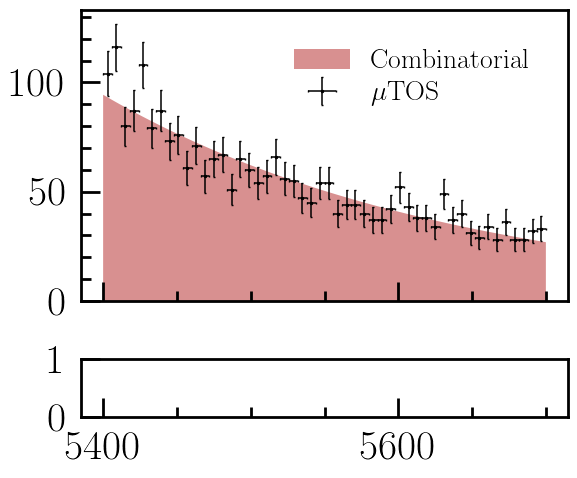

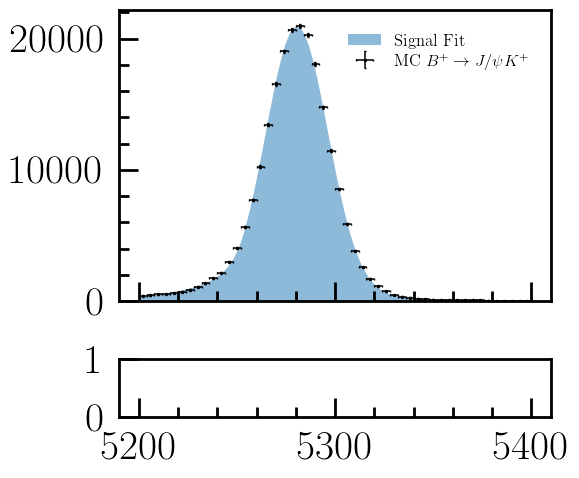

In [16]:
fig, ax = plt.subplots(2,1,figsize=(6,5),sharex=True,gridspec_kw={'height_ratios': [5, 1]})

# plot fit: exp 
x = np.linspace(*highmass_range, 100)
norm_highmass_pdf = zfit.run( highmass_exp_pdf.pdf(x, norm_range=highmass_range))

h_highmass = Hist.new.Reg(mbins, *highmass_range, name="high_mass_band").Double()
h_highmass.fill(TOS_bmass[TOS_bmass>=highmass_range[0]])

ax[0].errorbar(x=h_highmass.axes[0].centers, y=h_highmass.view(), fmt=".", 
               markersize=3, xerr=h_highmass.axes[0].widths/2, elinewidth=1.1, 
               yerr=np.sqrt(h_highmass.view()),
               color="black", capsize=1, markeredgewidth=1,
               label=r"$\mu$TOS")

bin_intgrs = h_highmass.sum() * ( (highmass_range[1]-highmass_range[0])/mbins )

# # ax[0].fill_between(x, combinatorial_pdf*bin_intgrs, norm_pdf*bin_intgrs, alpha=.3, 
# #                    facecolor="tab:blue", label=r"$B^{+}\rightarrow J/\psi K^{+}$")
ax[0].fill_between(x, 0, norm_highmass_pdf*bin_intgrs, alpha=.5, facecolor="firebrick", label="Combinatorial")
ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', direction="in")
ax[0].tick_params(axis='both', which='minor', direction="in")

ax[0].set_ylim(bottom=0)
ax[0].legend(fontsize=20)

fig, ax = plt.subplots(2,1,figsize=(6,5),sharex=True,gridspec_kw={'height_ratios': [5, 1]})
# plot fit: sim 
sim_x = np.linspace(*sim_mass_range, 100)
norm_sim_mass_pdf = zfit.run( sim_mass_pdf.pdf(sim_x, norm_range=sim_mass_range))

h_sim_mass = Hist.new.Reg(mbins, *sim_mass_range, name="sim_mass").Double()
h_sim_mass.fill(MC_b2jpsik_df["Bplus_M"])

ax[0].errorbar(x=h_sim_mass.axes[0].centers, y=h_sim_mass.view(), fmt=".", 
               markersize=3, xerr=h_sim_mass.axes[0].widths/2, elinewidth=1.1, 
               yerr=np.sqrt(h_sim_mass.view()),
               color="black", capsize=1, markeredgewidth=1,
               label=r"MC $B^{+}\rightarrow J/\psi K^{+}$")

bin_intgrs = h_sim_mass.sum() * ( (sim_mass_range[1]-sim_mass_range[0])/mbins )

# # ax[0].fill_between(x, combinatorial_pdf*bin_intgrs, norm_pdf*bin_intgrs, alpha=.3, 
# #                    facecolor="tab:blue", label=r"$B^{+}\rightarrow J/\psi K^{+}$")
ax[0].fill_between(sim_x, 0, norm_sim_mass_pdf*bin_intgrs, alpha=.5, facecolor="tab:blue", label=r"Signal Fit")
ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', direction="in")
ax[0].tick_params(axis='both', which='minor', direction="in")

ax[0].set_ylim(bottom=0)
ax[0].legend(fontsize=12)

In [17]:
inherited_pars

{'lambda_exp_highmass': -0.00417843574938459,
 'frac': 0.9344656864519016,
 'sig_alphal': 1.7521986380227688,
 'sig_mu': 5280.601962474448,
 'sig_sigmal': 15.816084520599576,
 'sig_alphar': 4.173223972601404,
 'sig_sigmar': 41.331294231127664}

In [18]:
# === test the combination on muon TOS ===

# attempt to fix the signal shape pars
mass = zfit.Space("m", limits=mrange)

tot_model_mu   = zfit.Parameter("tot_model_mu", 5280, 5280-30, 5280+30)
tot_model_sigmal   = zfit.Parameter("tot_modelsig_sigmal", 7,  5, 50)
tot_model_sigmar   = zfit.Parameter("tot_modelsig_sigmar", 7,  5, 50)
# fixed pars
tot_model_alphal = zfit.Parameter("tot_model_alphal", inherited_pars["sig_alphal"], floating=False)
tot_model_alphar = zfit.Parameter("tot_model_alphar", inherited_pars["sig_alphar"], floating=False)
tot_model_nl      = zfit.Parameter("tot_model_nl", 2, floating=False)
tot_model_nr      = zfit.Parameter("tot_model_nr", 2, floating=False)
tot_model_lambda  = zfit.Parameter("tot_model_lambda", inherited_pars["lambda_exp_highmass"], floating=False)
tot_model_cb_frac  = zfit.Parameter("tot_model_cb_frac", inherited_pars["frac"], floating=False)
# mixture of bkg and sig pdfs
tot_model_frac = zfit.Parameter("tot_model_frac", 0.5, 0, 1.)


fixed_cb1_pdf = zfit.pdf.CrystalBall(
    obs   = mass, 
    mu    = tot_model_mu,
    sigma = tot_model_sigmal, 
    alpha = tot_model_alphal, 
    n     = tot_model_nl
)

fixed_cb2_pdf = zfit.pdf.CrystalBall(
    obs   = mass, 
    mu    = tot_model_mu,
    sigma = tot_model_sigmar, 
    alpha = tot_model_alphar, 
    n     = tot_model_nr
)

comb_pdf = zfit.pdf.Exponential(tot_model_lambda, obs=mass)

mass_pdf = zfit.pdf.SumPDF( [fixed_cb1_df, fixed_cb2_pdf, comb_pdf], fracs=[tot_model_cb_frac, tot_model_frac] )

# build the likelihood, minimise and errors (Hesse, see TM slides by Matt)
mass_dset = zfit.Data.from_numpy(obs=mass, array=TOS_bmass)
mass_nll  = zfit.loss.UnbinnedNLL(model=mass_pdf, data=mass_dset)

# minimise
model_minimizer = zfit.minimize.Minuit()
model_minimum = model_minimizer.minimize(mass_nll)
_ = model_minimum.hesse()
print(model_minimum)

NameError: name 'fixed_cb1_df' is not defined

In [ ]:
# nominal mass shape
mu       = zfit.Parameter("mu"   , 5280, 5280-80, 5280+80 )
sigma    = zfit.Parameter("sigma", 7,  5, 50)
sigmac  = zfit.Parameter("sigmac", 7,  5, 50)
sigmac2  = zfit.Parameter("sigmac2", 7,  5, 50)
alphal  = zfit.Parameter("alphal", 2, 0, 10 )
alphar  = zfit.Parameter("alphar", 2, 0, 10 )
nl      = zfit.Parameter("nl", 2, floating=False)
nr      = zfit.Parameter("nr", 2, floating=False)
#nl      = zfit.Parameter("nl", 3, 0, 10)
#nr      = zfit.Parameter("nr", 3, 0, 10)
frac    = zfit.Parameter("frac", 0.5, 0, 1.)
frac2    = zfit.Parameter("frac2", 0.5, 0, 1.)
lambda_exp = zfit.Parameter("lambda", -0.01796, floating=False) # fixed from upper mass band


exp_pdf = zfit.pdf.Exponential(lambda_exp, obs=mass)
gaus_pdf = zfit.pdf.Gauss(obs=mass, mu=mu, sigma=sigma)
cb_pdf    = zfit.pdf.CrystalBall(obs=mass, mu=mu, sigma=sigmac, alpha=alphal, n=nl)
cb2_pdf   = zfit.pdf.CrystalBall(obs=mass, mu=mu, sigma=sigmac2, alpha=alphar, n=nr)
dcb_pdf   = zfit.pdf.DoubleCB(obs=mass, mu=mu, sigma=sigmac, alphal=alphal, alphar=alphar, nl=nl, nr=nr)

In [ ]:
lambda_floating = zfit.Parameter("lambda_floating", -1, -3, 0)
nom_pdf = zfit.pdf.Exponential(lambda_floating, obs=mass)
#nom_pdf   = zfit.pdf.SumPDF( [dcb_pdf, exp_pdf], fracs=[frac] )

In [ ]:
nom_dset = zfit.Data.from_numpy(obs=mass, array=TOS_bmass)
nom_nll  = zfit.loss.UnbinnedNLL(model=nom_pdf, data=nom_dset)

In [ ]:
# create a minimizer
minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(nom_nll)
#print(minimum.params)

# # do the error calculations, here with minos
# param_errors, _ = result.errors()
# print(param_errors)

In [ ]:
_ = minimum.hesse()

In [ ]:
print(minimum)

In [ ]:
# #param_errors, _ = result.errors(method="minuit_hesse") # https://pprc.qmul.ac.uk/~bevan/yeti/fitting.pdf
# param_hesse     = minimum.hesse()
# #param_errors, _ = result.errors()

In [ ]:
# print("Function minimum:", result.fmin)
# print("Converged:", result.converged)
# print("Full minimizer information:", result.info)

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(8,8),sharex=True,gridspec_kw={'height_ratios': [3, 1]})

# plot fit 
x = np.linspace(5340, 5500, 400)
norm_pdf = zfit.run( nom_pdf.pdf(x, norm_range=mrange))
combinatorial_pdf = zfit.run( exp_pdf.pdf(x, norm_range=mrange))

ax[0].errorbar(x=h_TOSTIS.axes["b_mass"].centers, y=h_TOSTIS.project("b_mass").view(), fmt=".", 
               markersize=3, xerr=h_TOSTIS.axes["b_mass"].widths/2, elinewidth=1.1, 
               yerr=np.sqrt(h_TOSTIS.project("b_mass").view()),
               color="black", capsize=1, markeredgewidth=1,
               label=r"$\mu$TOS")

bin_intgrs = h_TOSTIS.project("b_mass").sum() * ( (mrange[1]-mrange[0])/mbins )
ax[0].plot(x, norm_pdf*bin_intgrs, color="royalblue", lw=1.1, alpha=1., label="Total Fit Model")
# ax[0].fill_between(x, combinatorial_pdf*bin_intgrs, norm_pdf*bin_intgrs, alpha=.3, 
#                    facecolor="tab:blue", label=r"$B^{+}\rightarrow J/\psi K^{+}$")
ax[0].fill_between(x, 0, combinatorial_pdf*bin_intgrs, alpha=.5, facecolor="firebrick", label="Combinatorial")


ax[0].set_ylim(bottom=0)
ax[0].legend(fontsize=20)

## Study v4 MC on eos to get L0MuonTOS and isMuon effs

In [178]:
def tohist(cvals, nbins=20, range=[10e3, 100e3]):
    range = range or (np.min(cvals), np.max(cvals))
    h = Hist( 
        hist.axis.Regular(nbins, *range, 
        label=rf"p   [MeV]/c", name="raw",
        underflow=False, overflow=False),
        storage=hist.storage.Double(), 
    )
    h.fill( cvals )
    return h

In [179]:
def eff_std(N, k):
    '''Utility function to compute the eff+/- err
    the error estimate is performed via binomial errors
    this is valid unless k=N or k=0
    source: Paterno, FERMILAB-TM-2286-CD
    '''
    std = (1/N)*np.sqrt(k*(1-(k/N)))
    return std

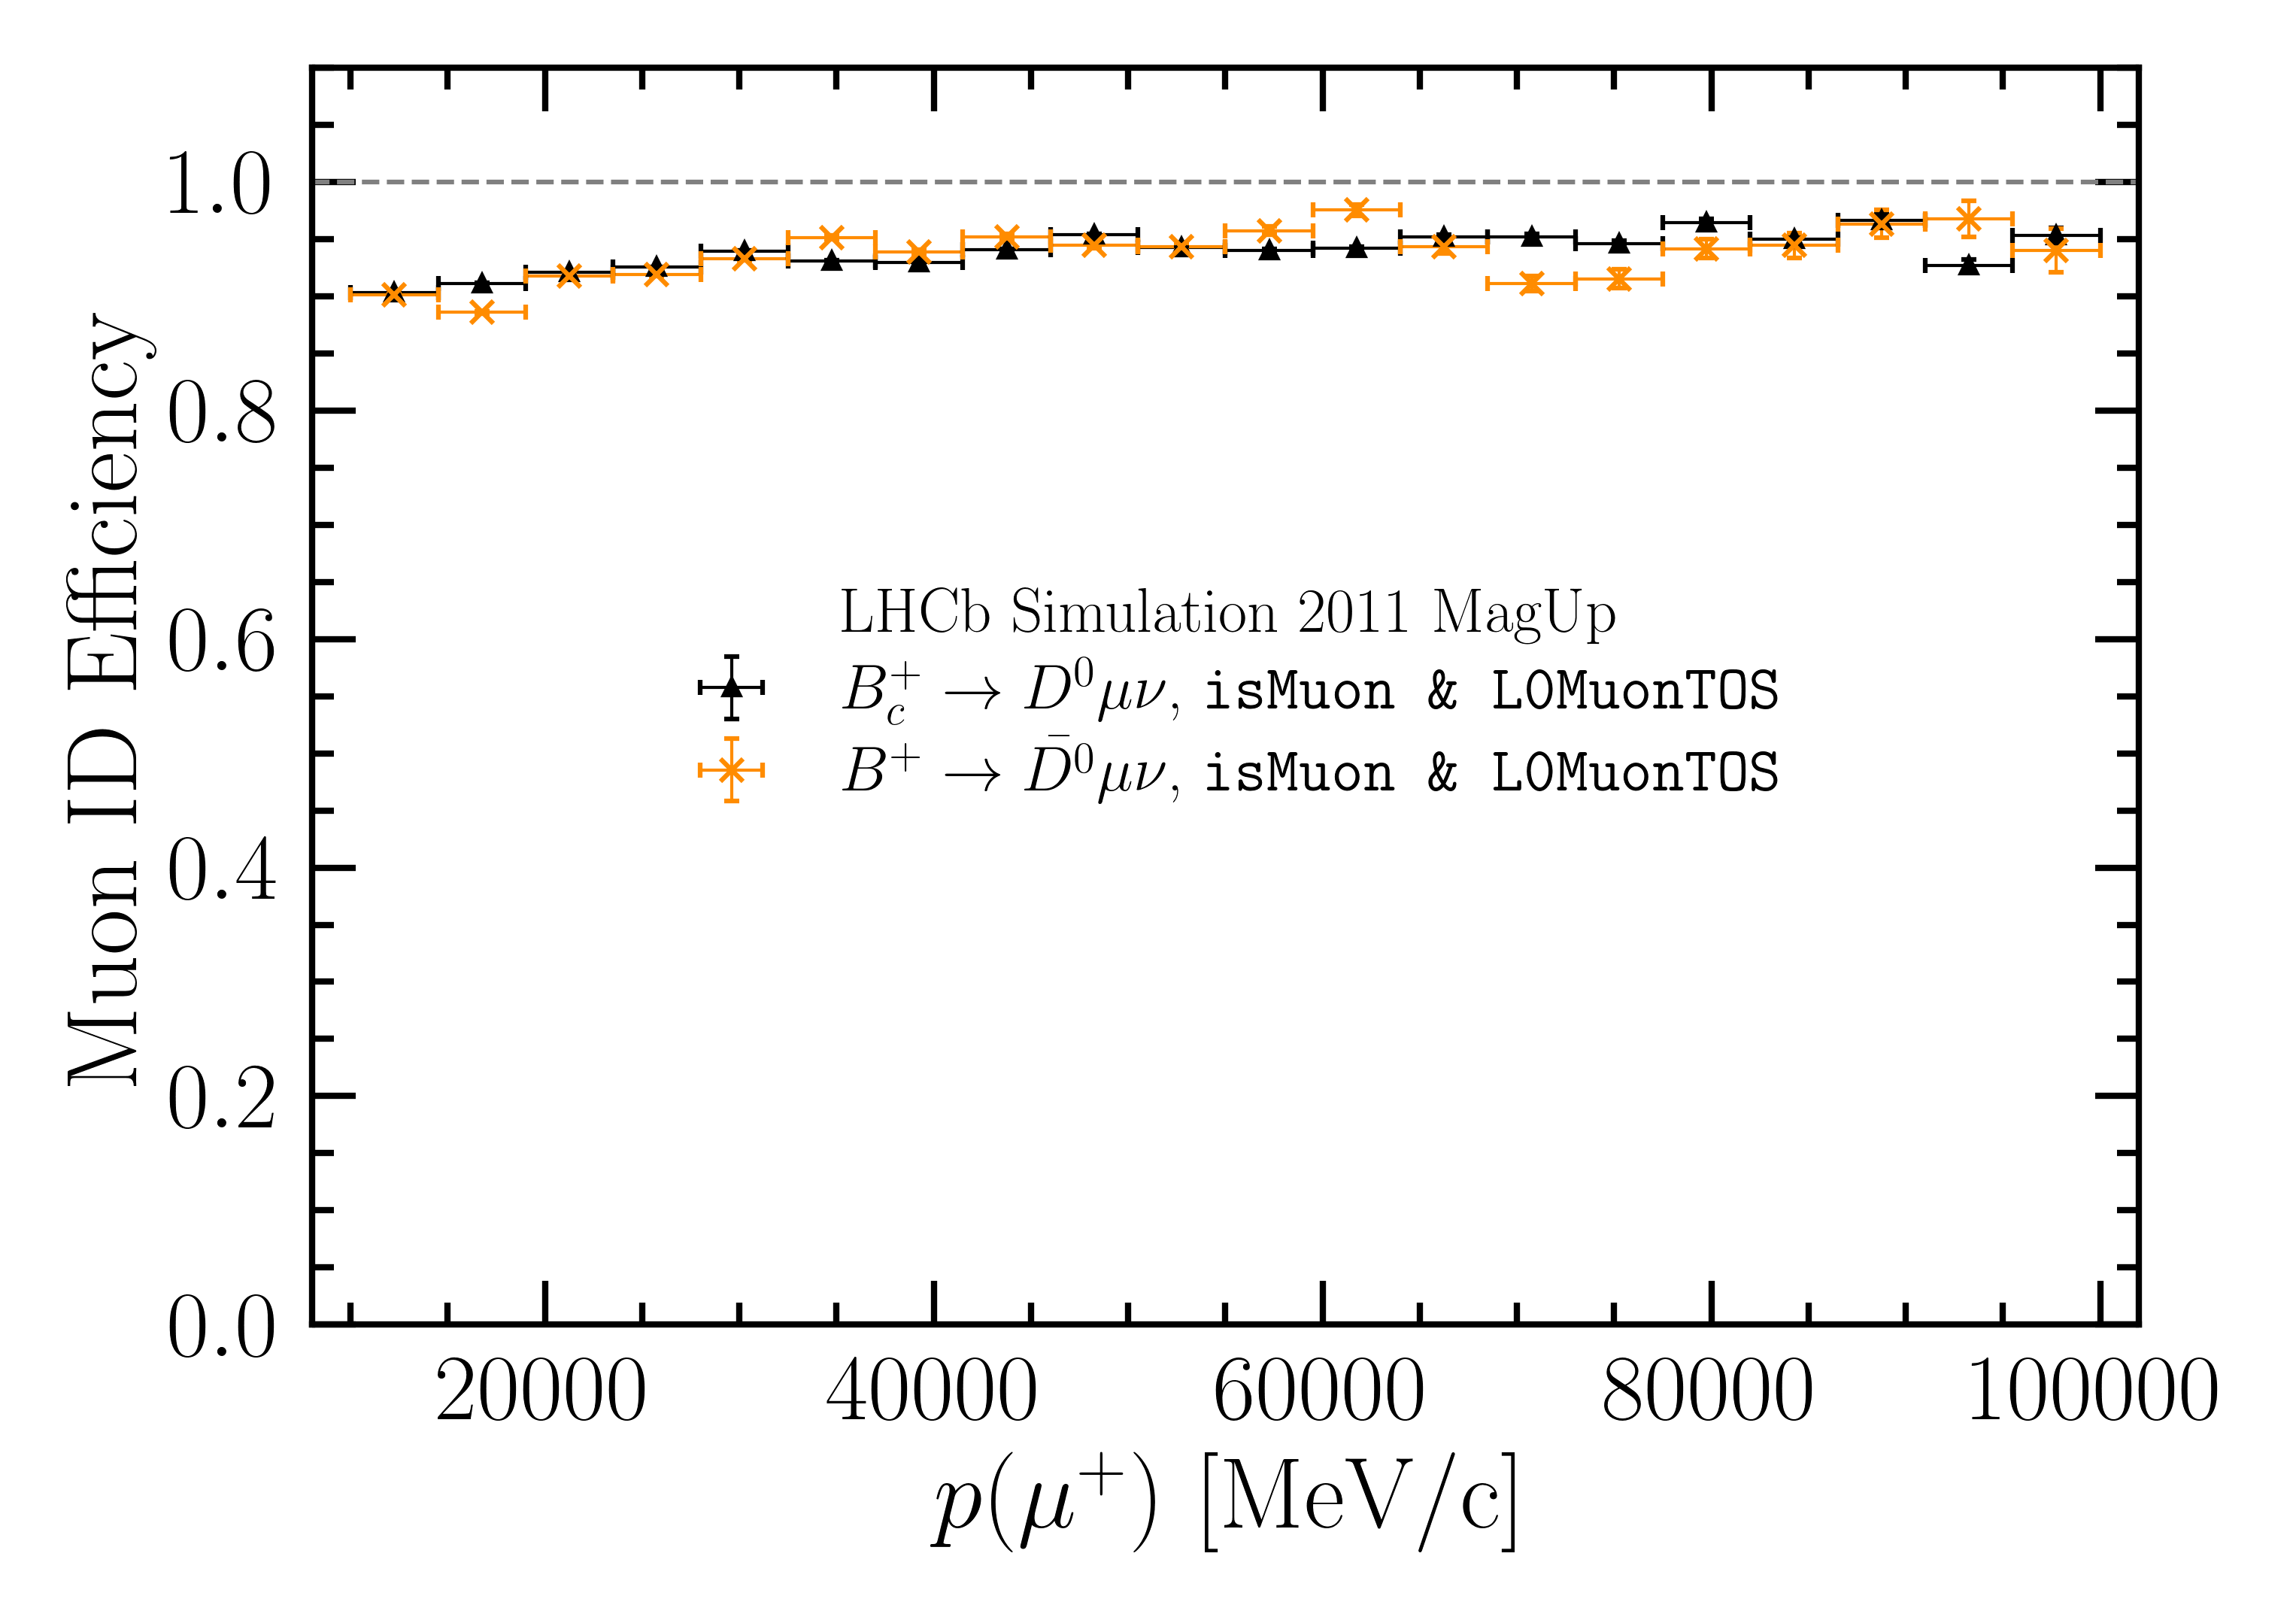

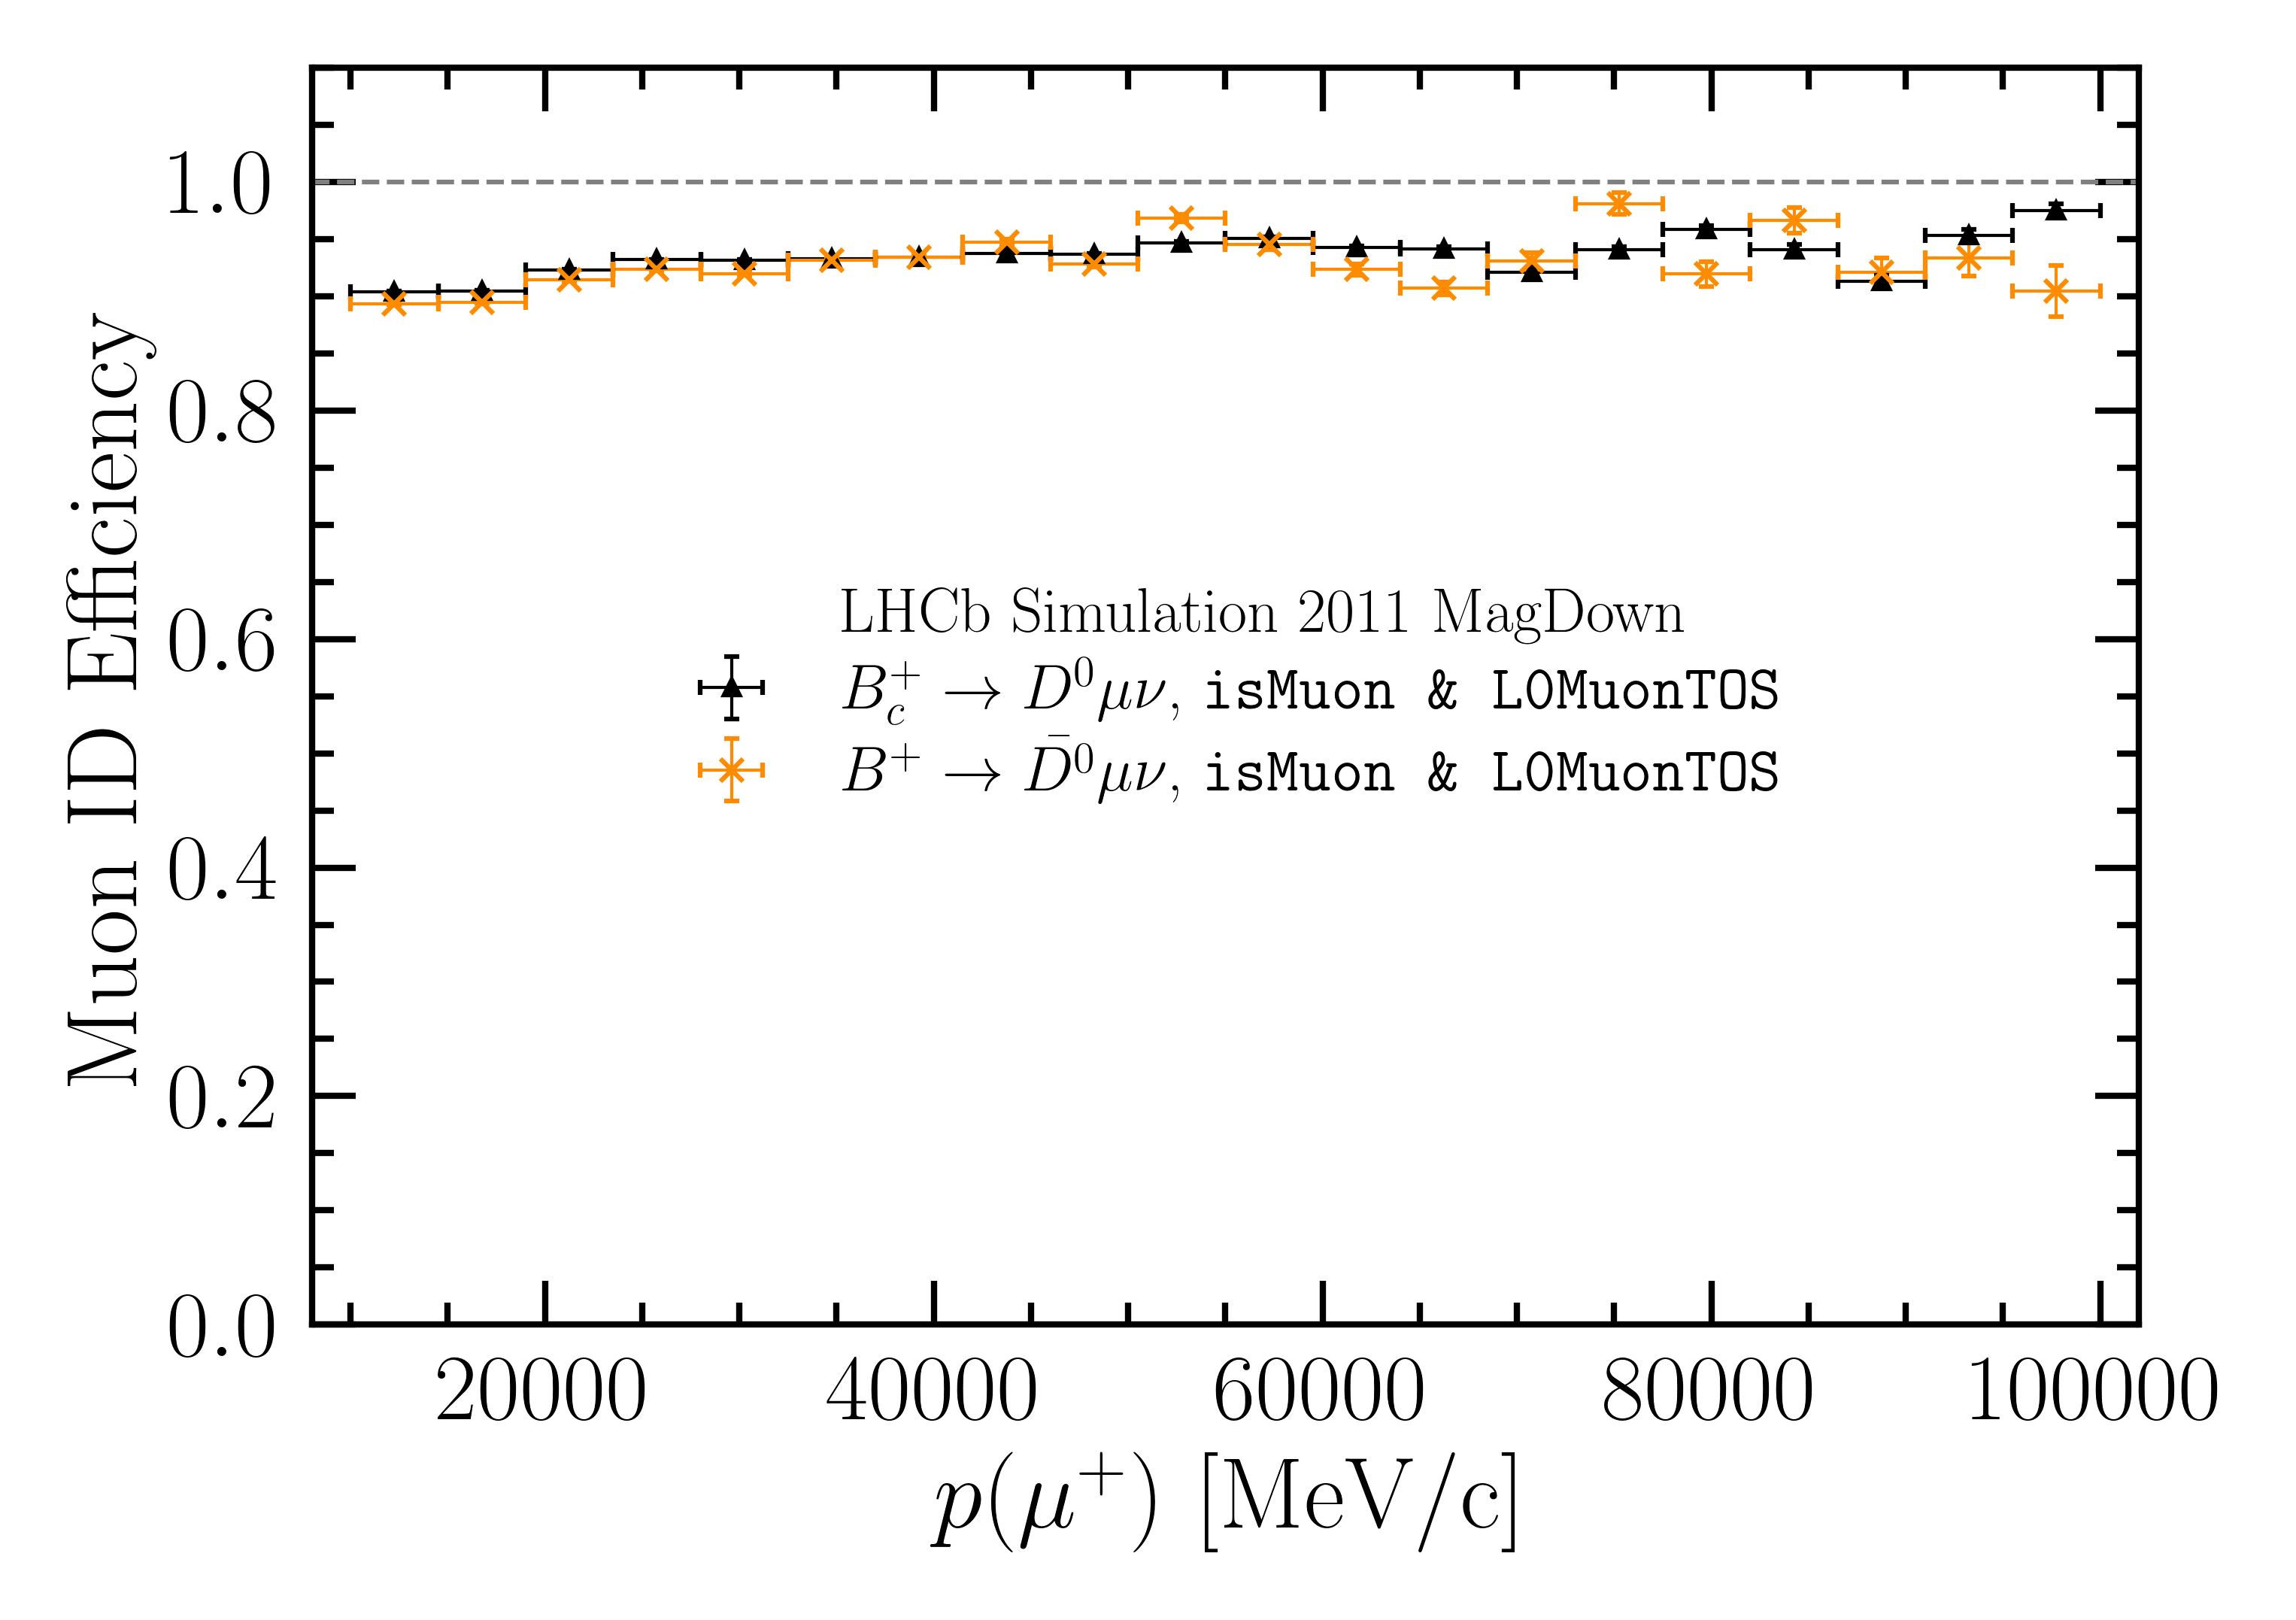

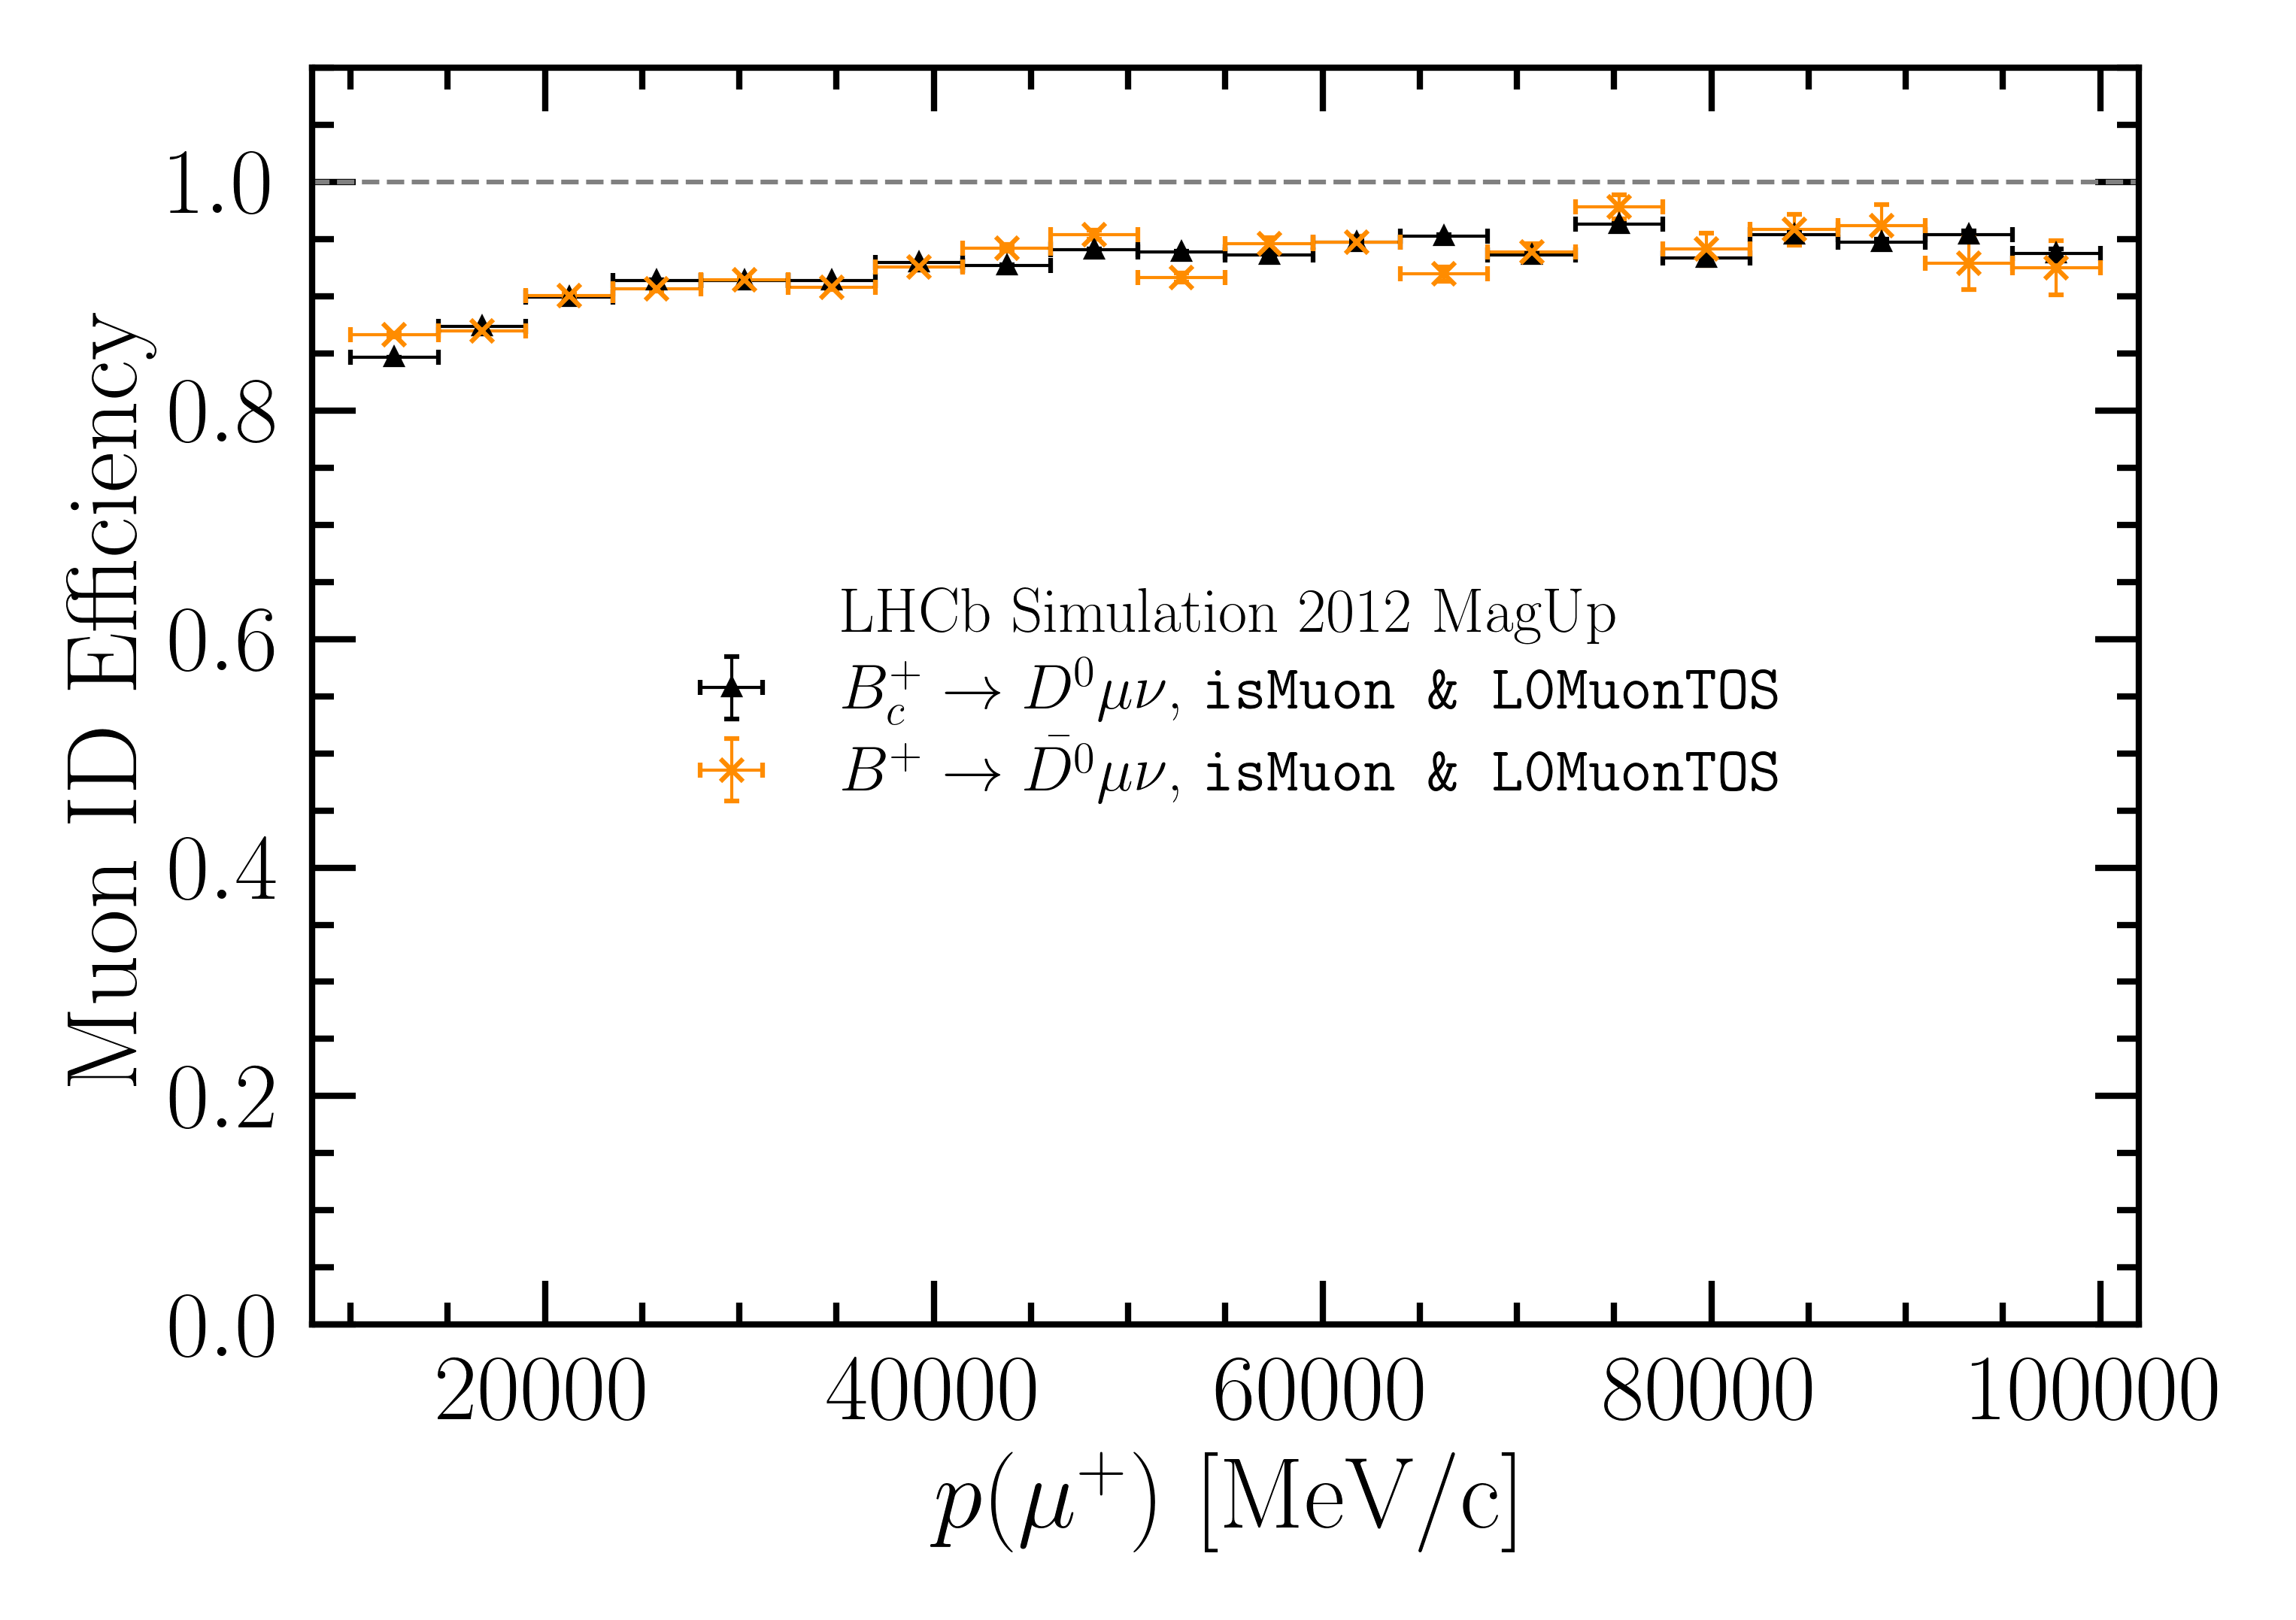

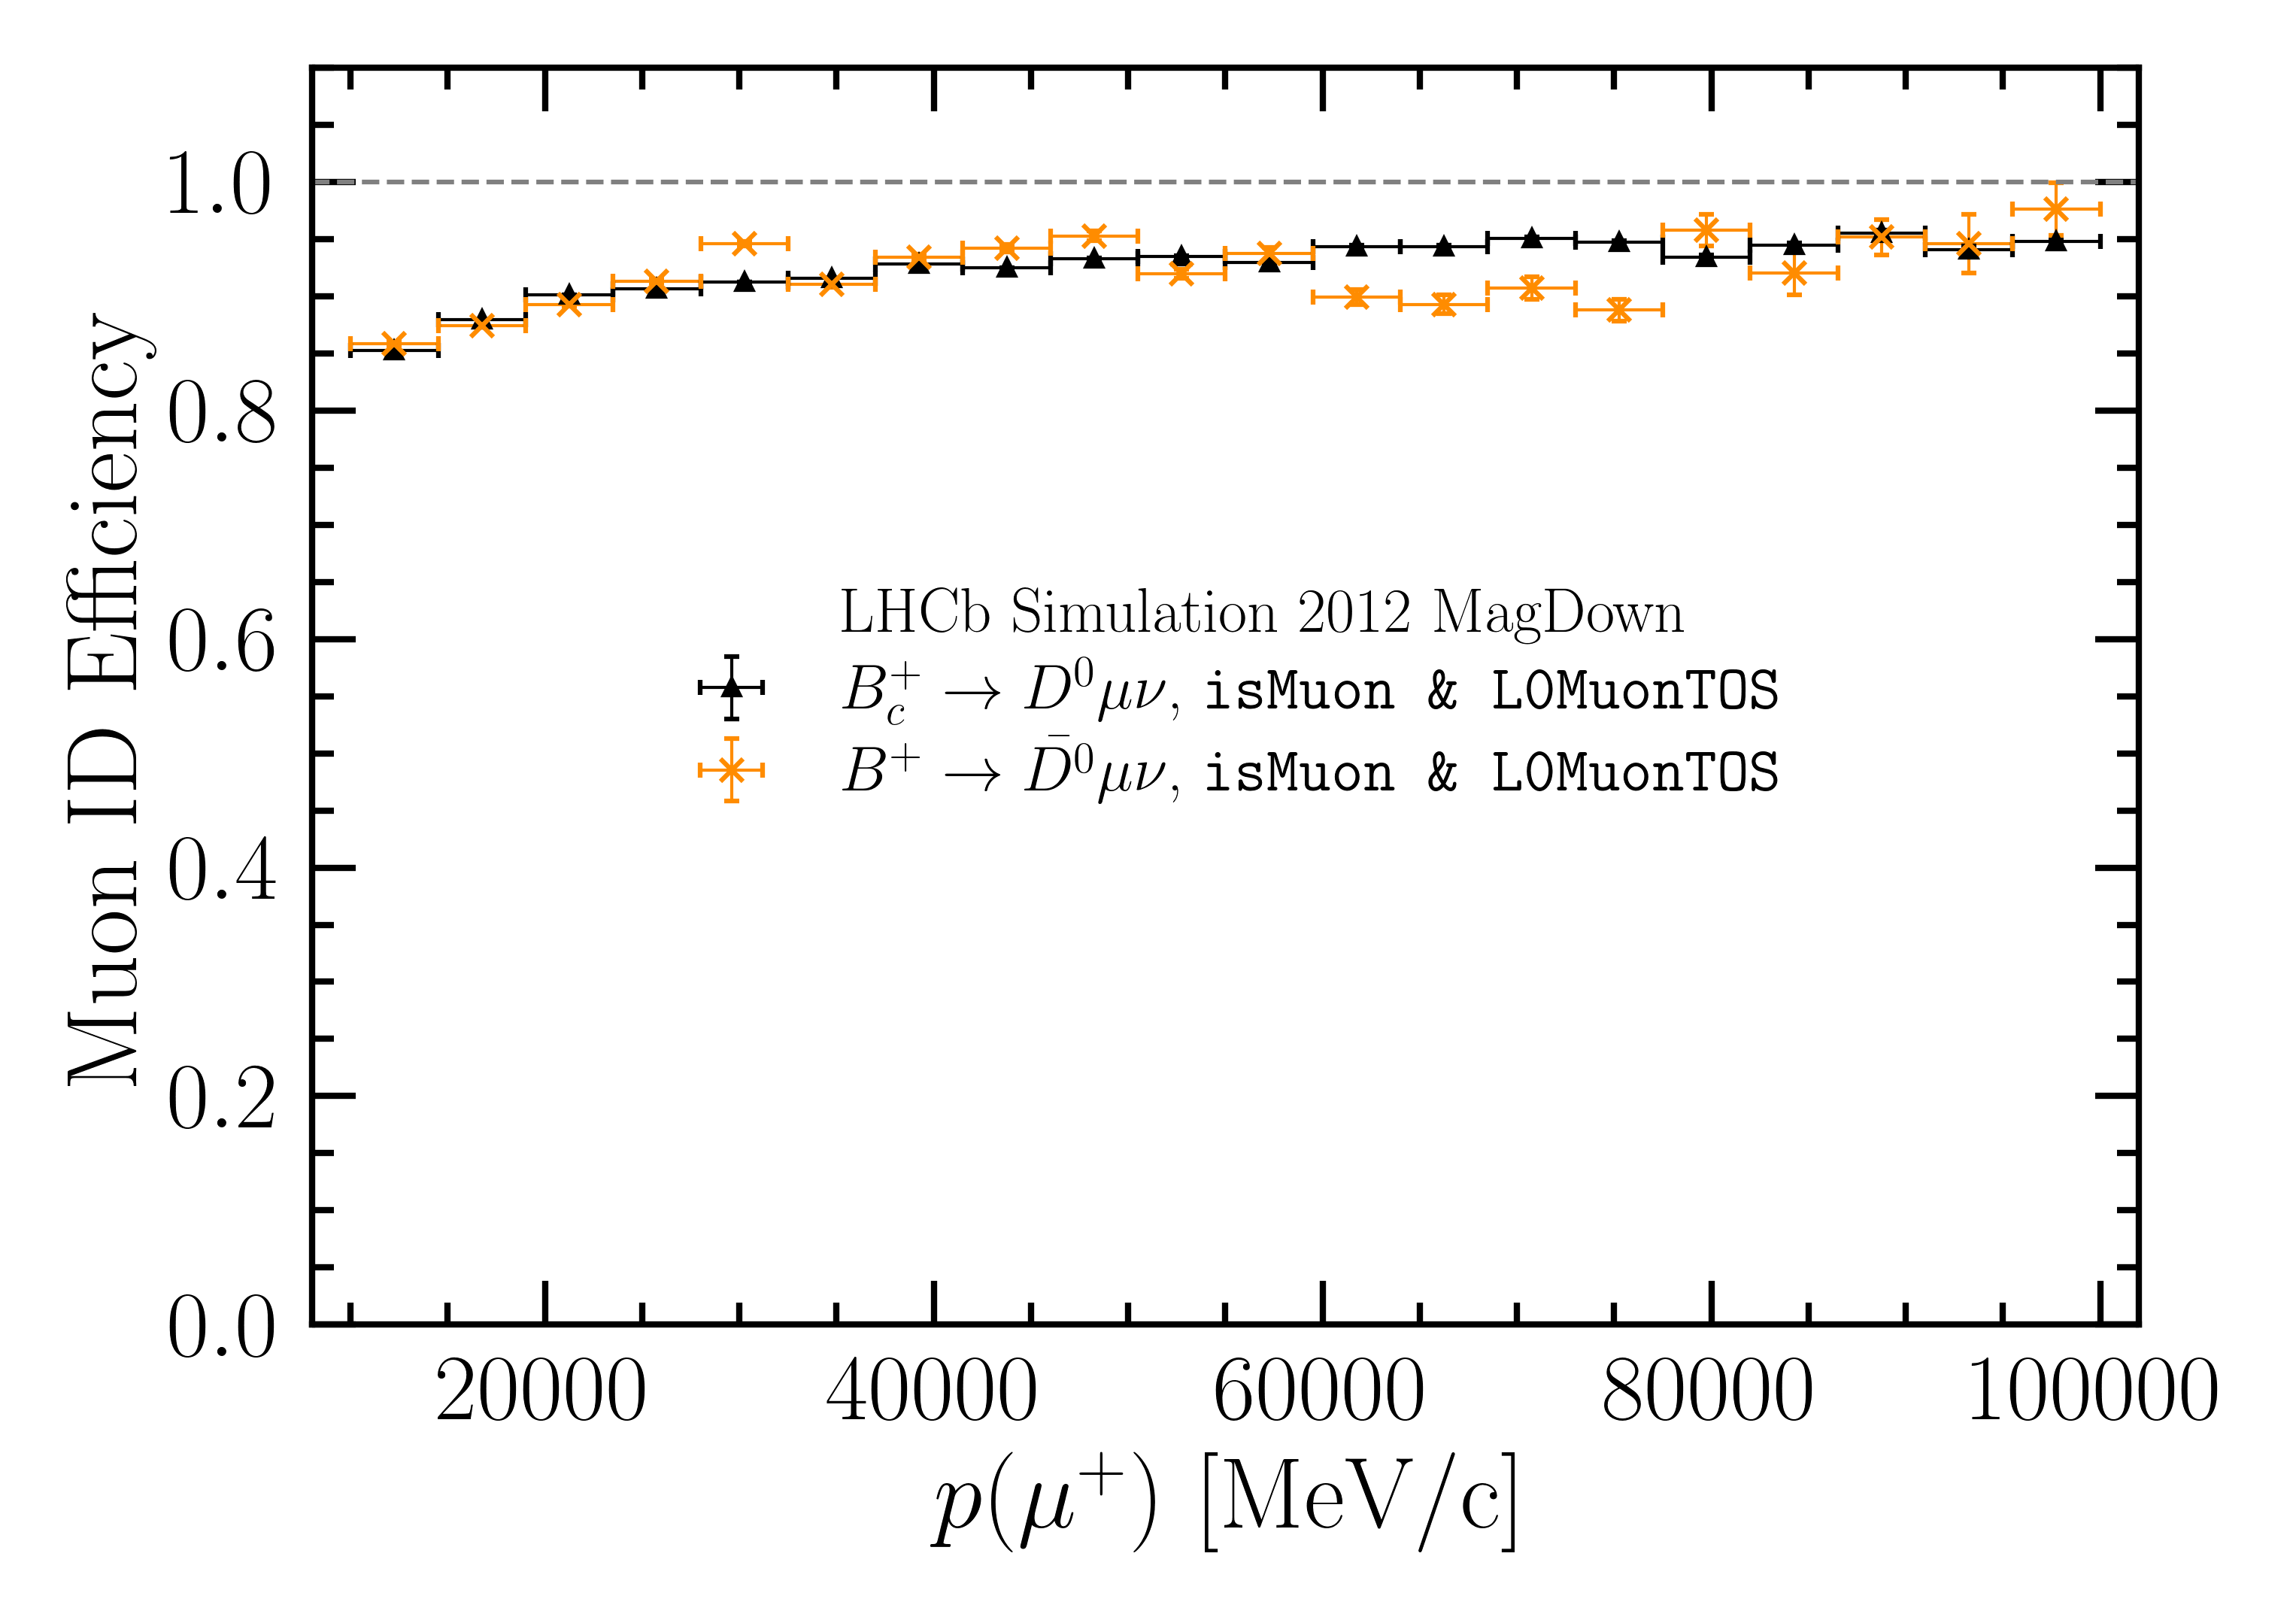

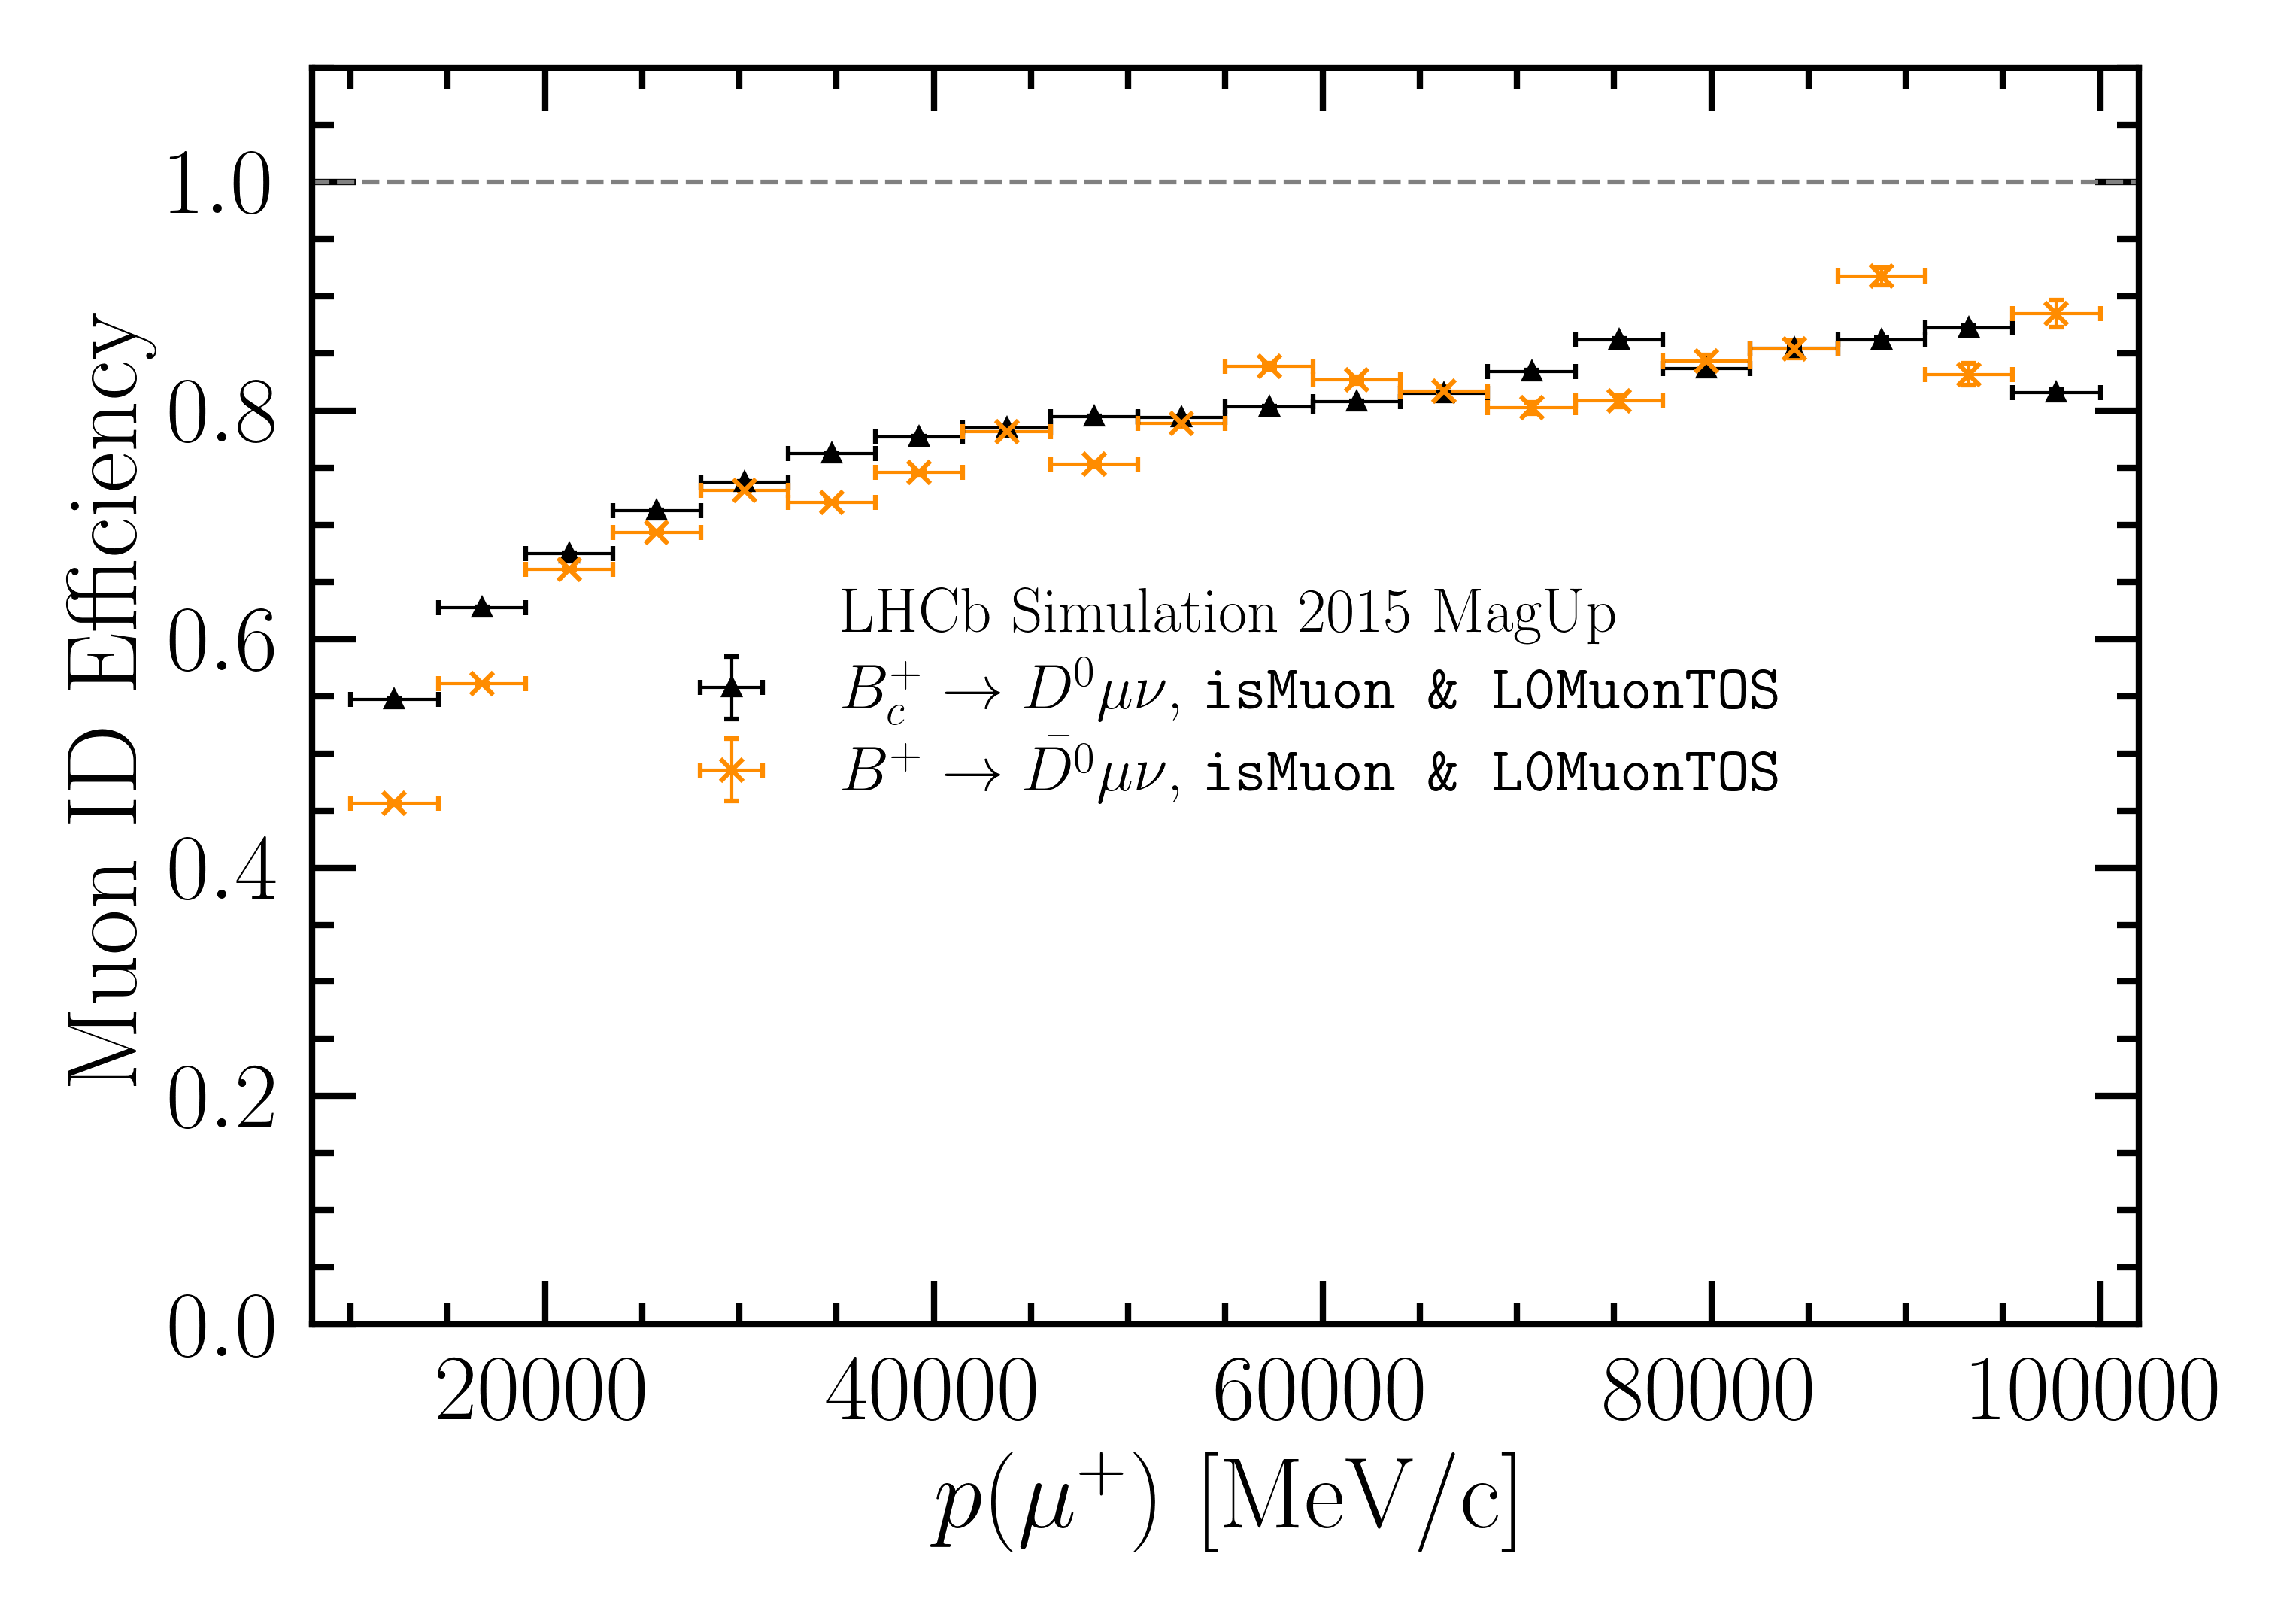

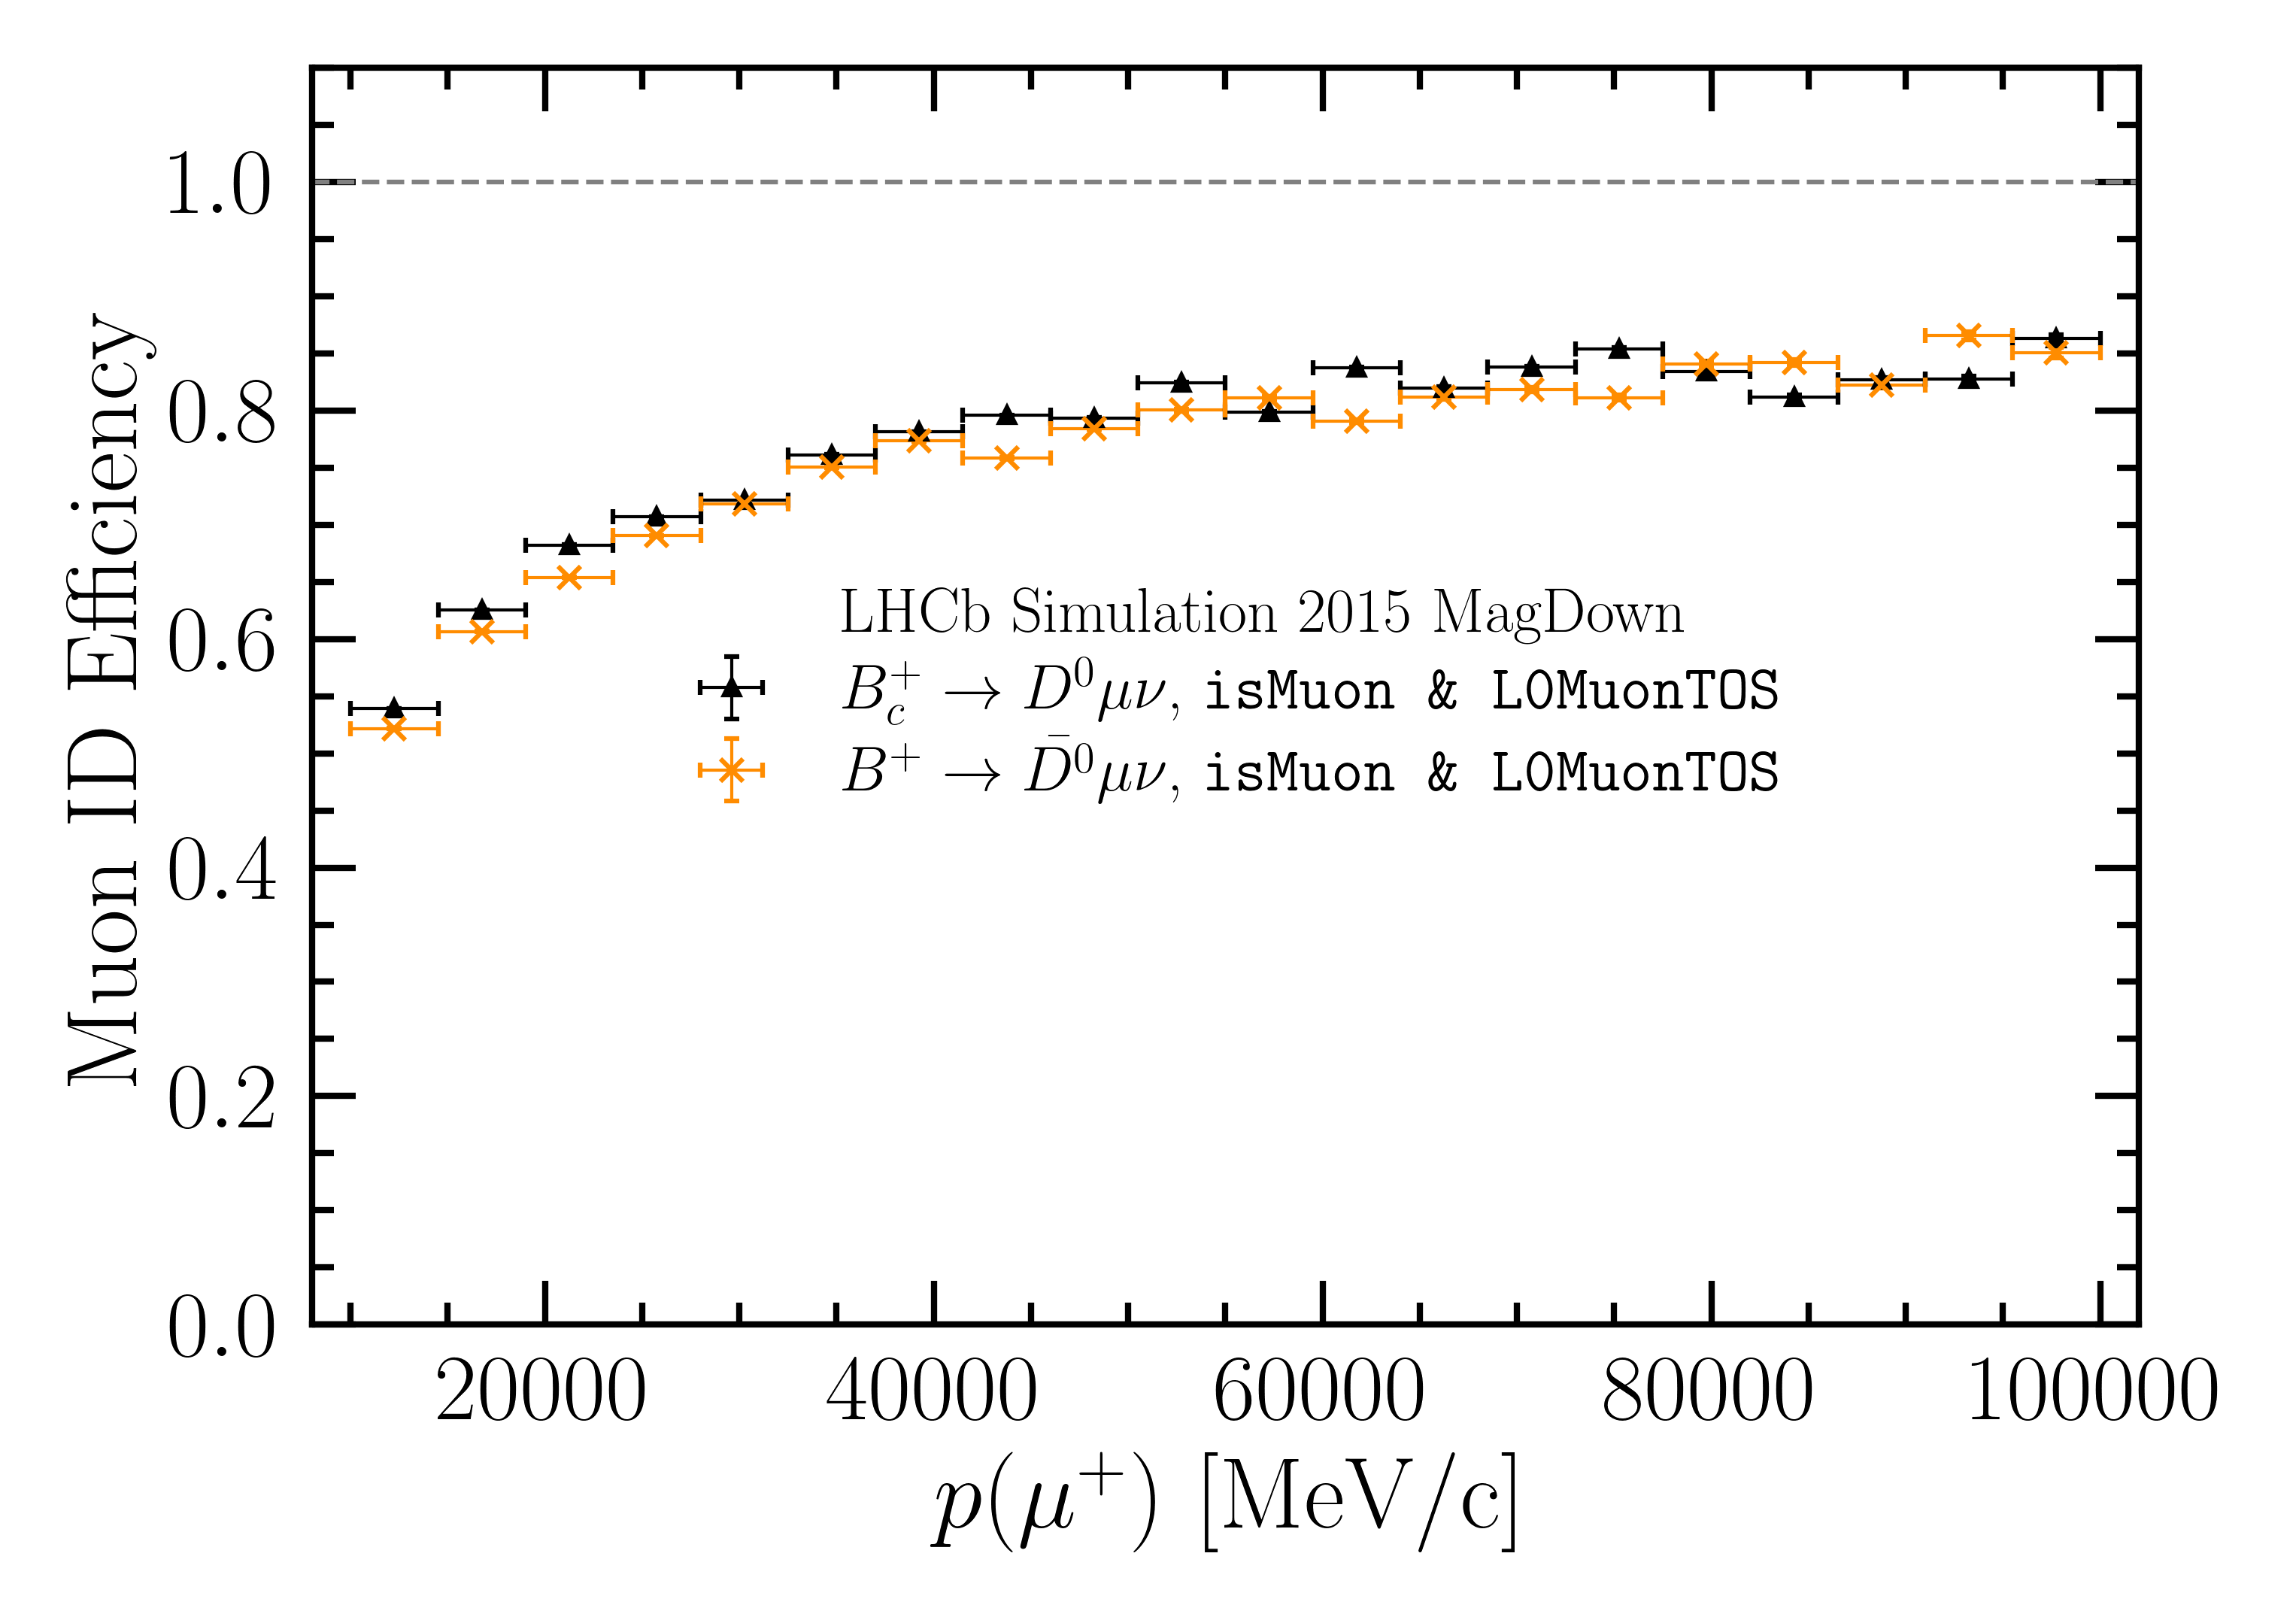

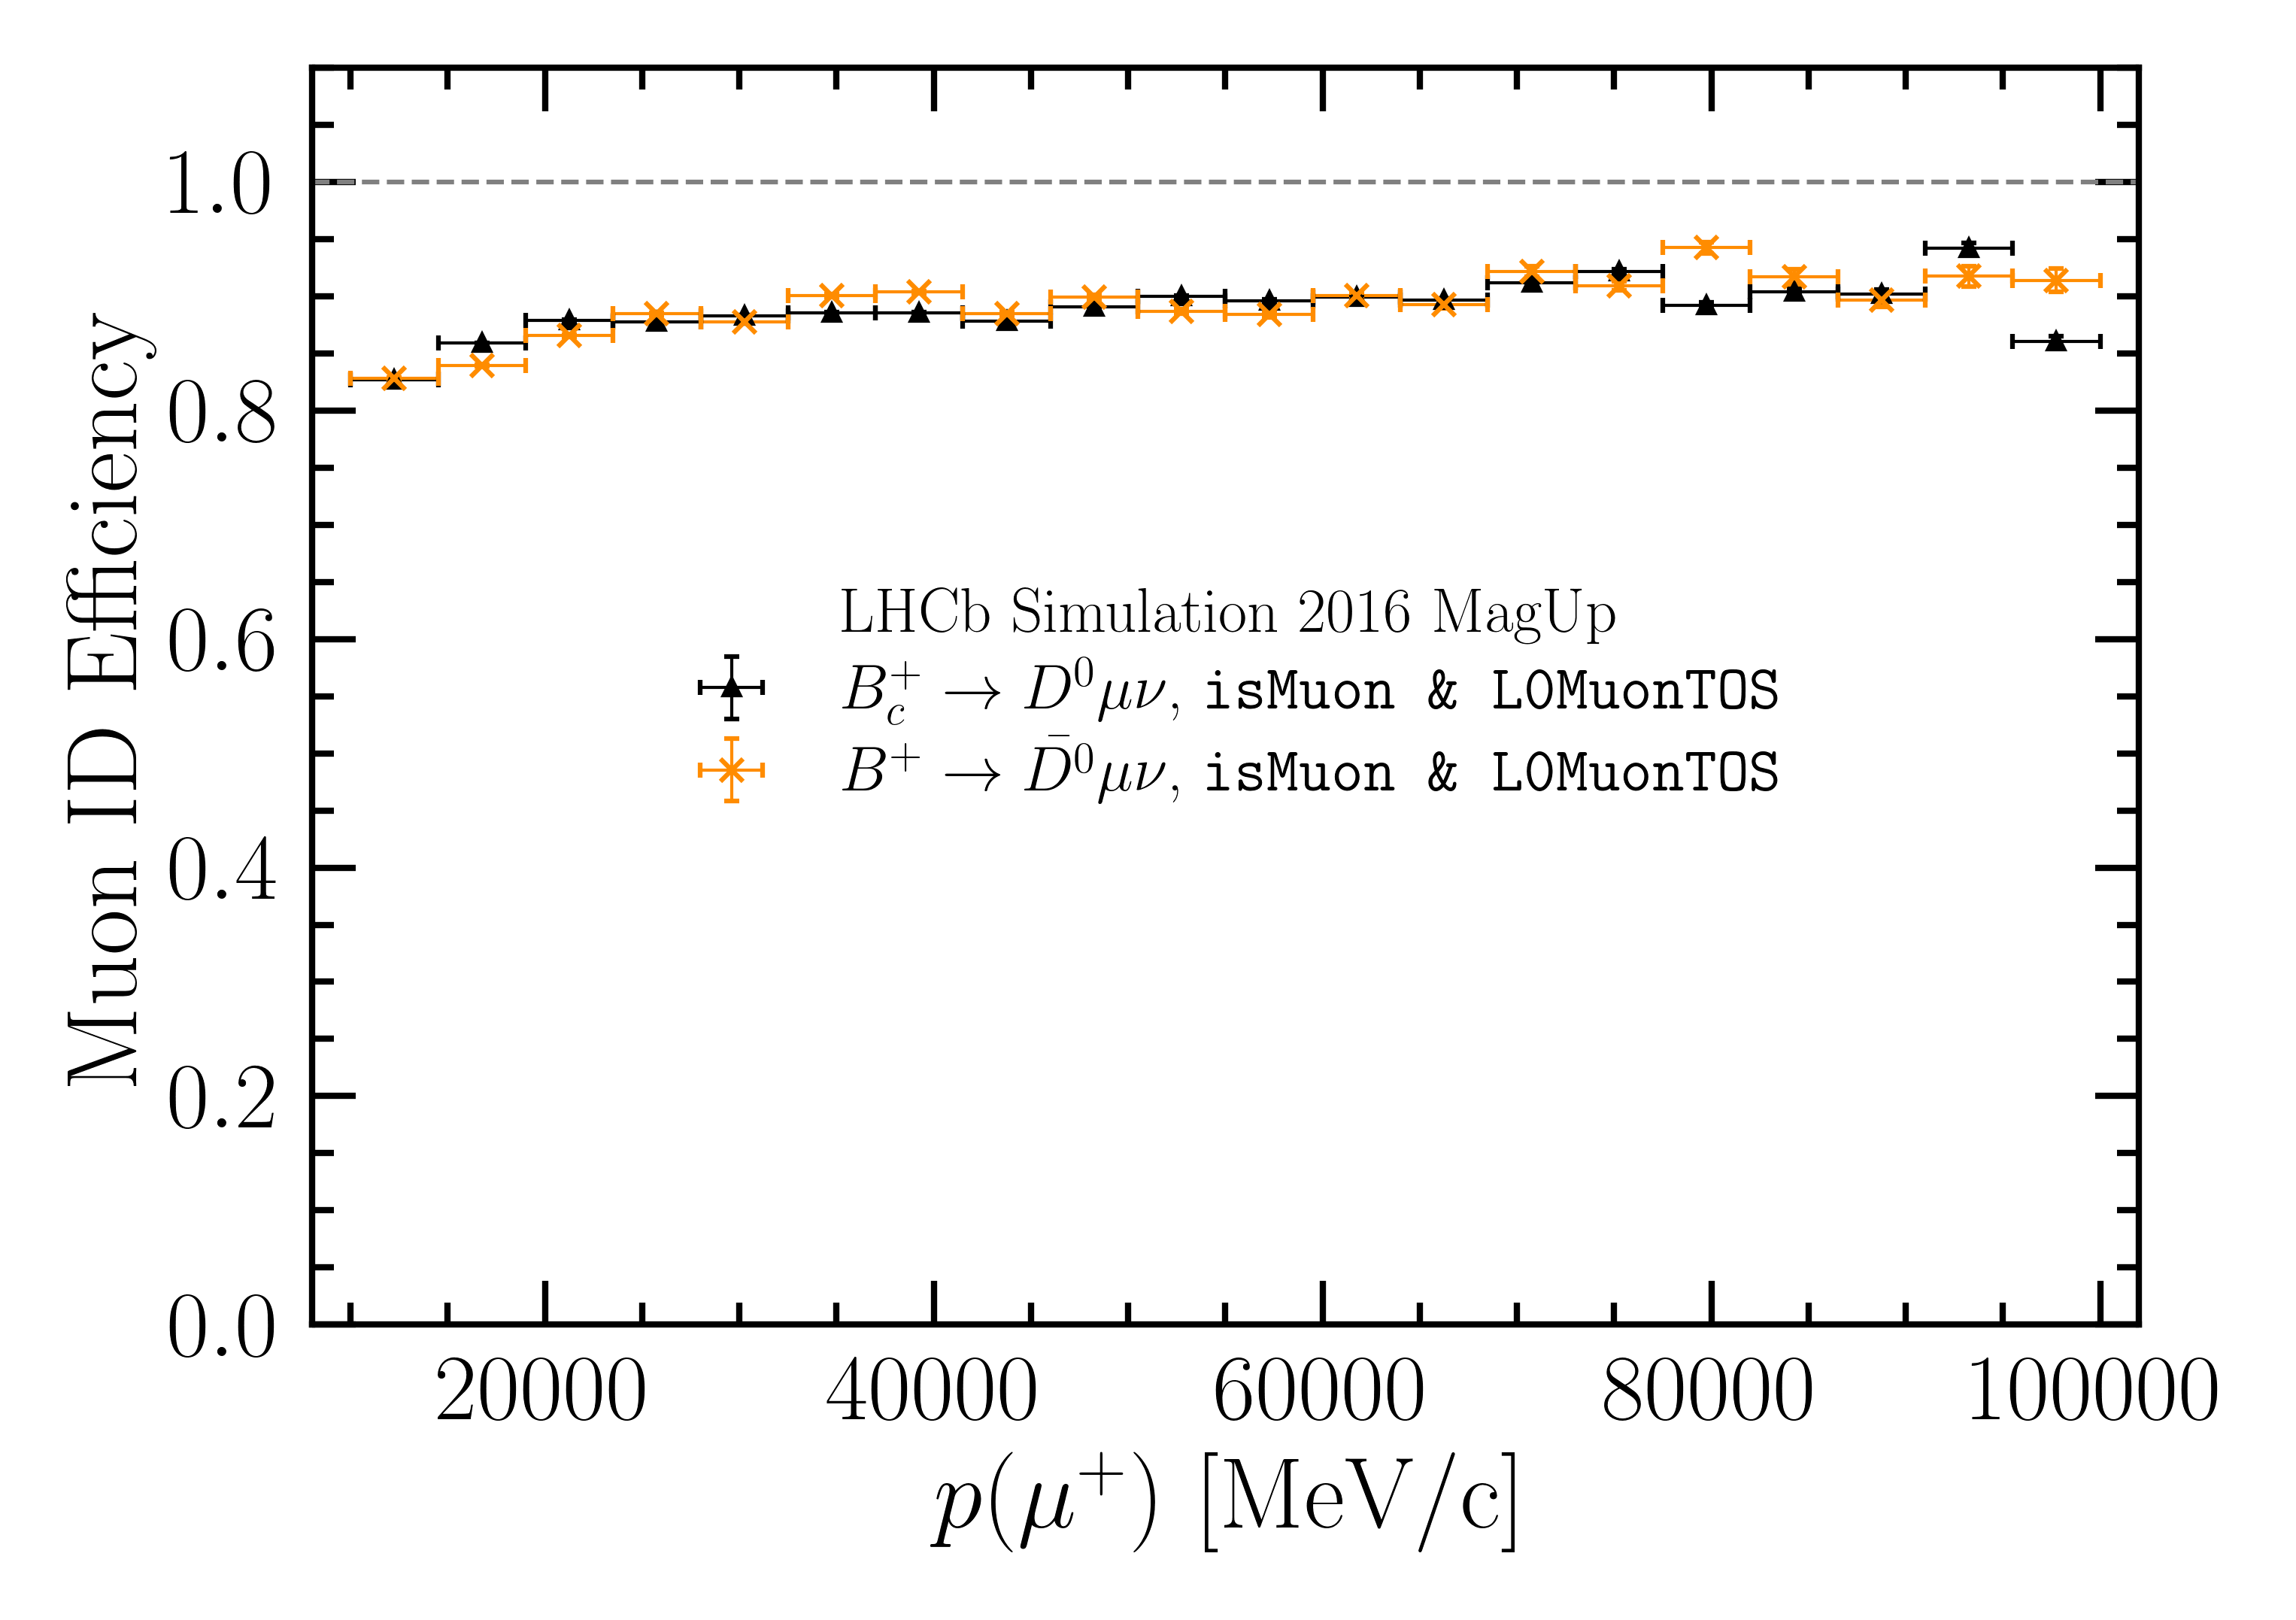

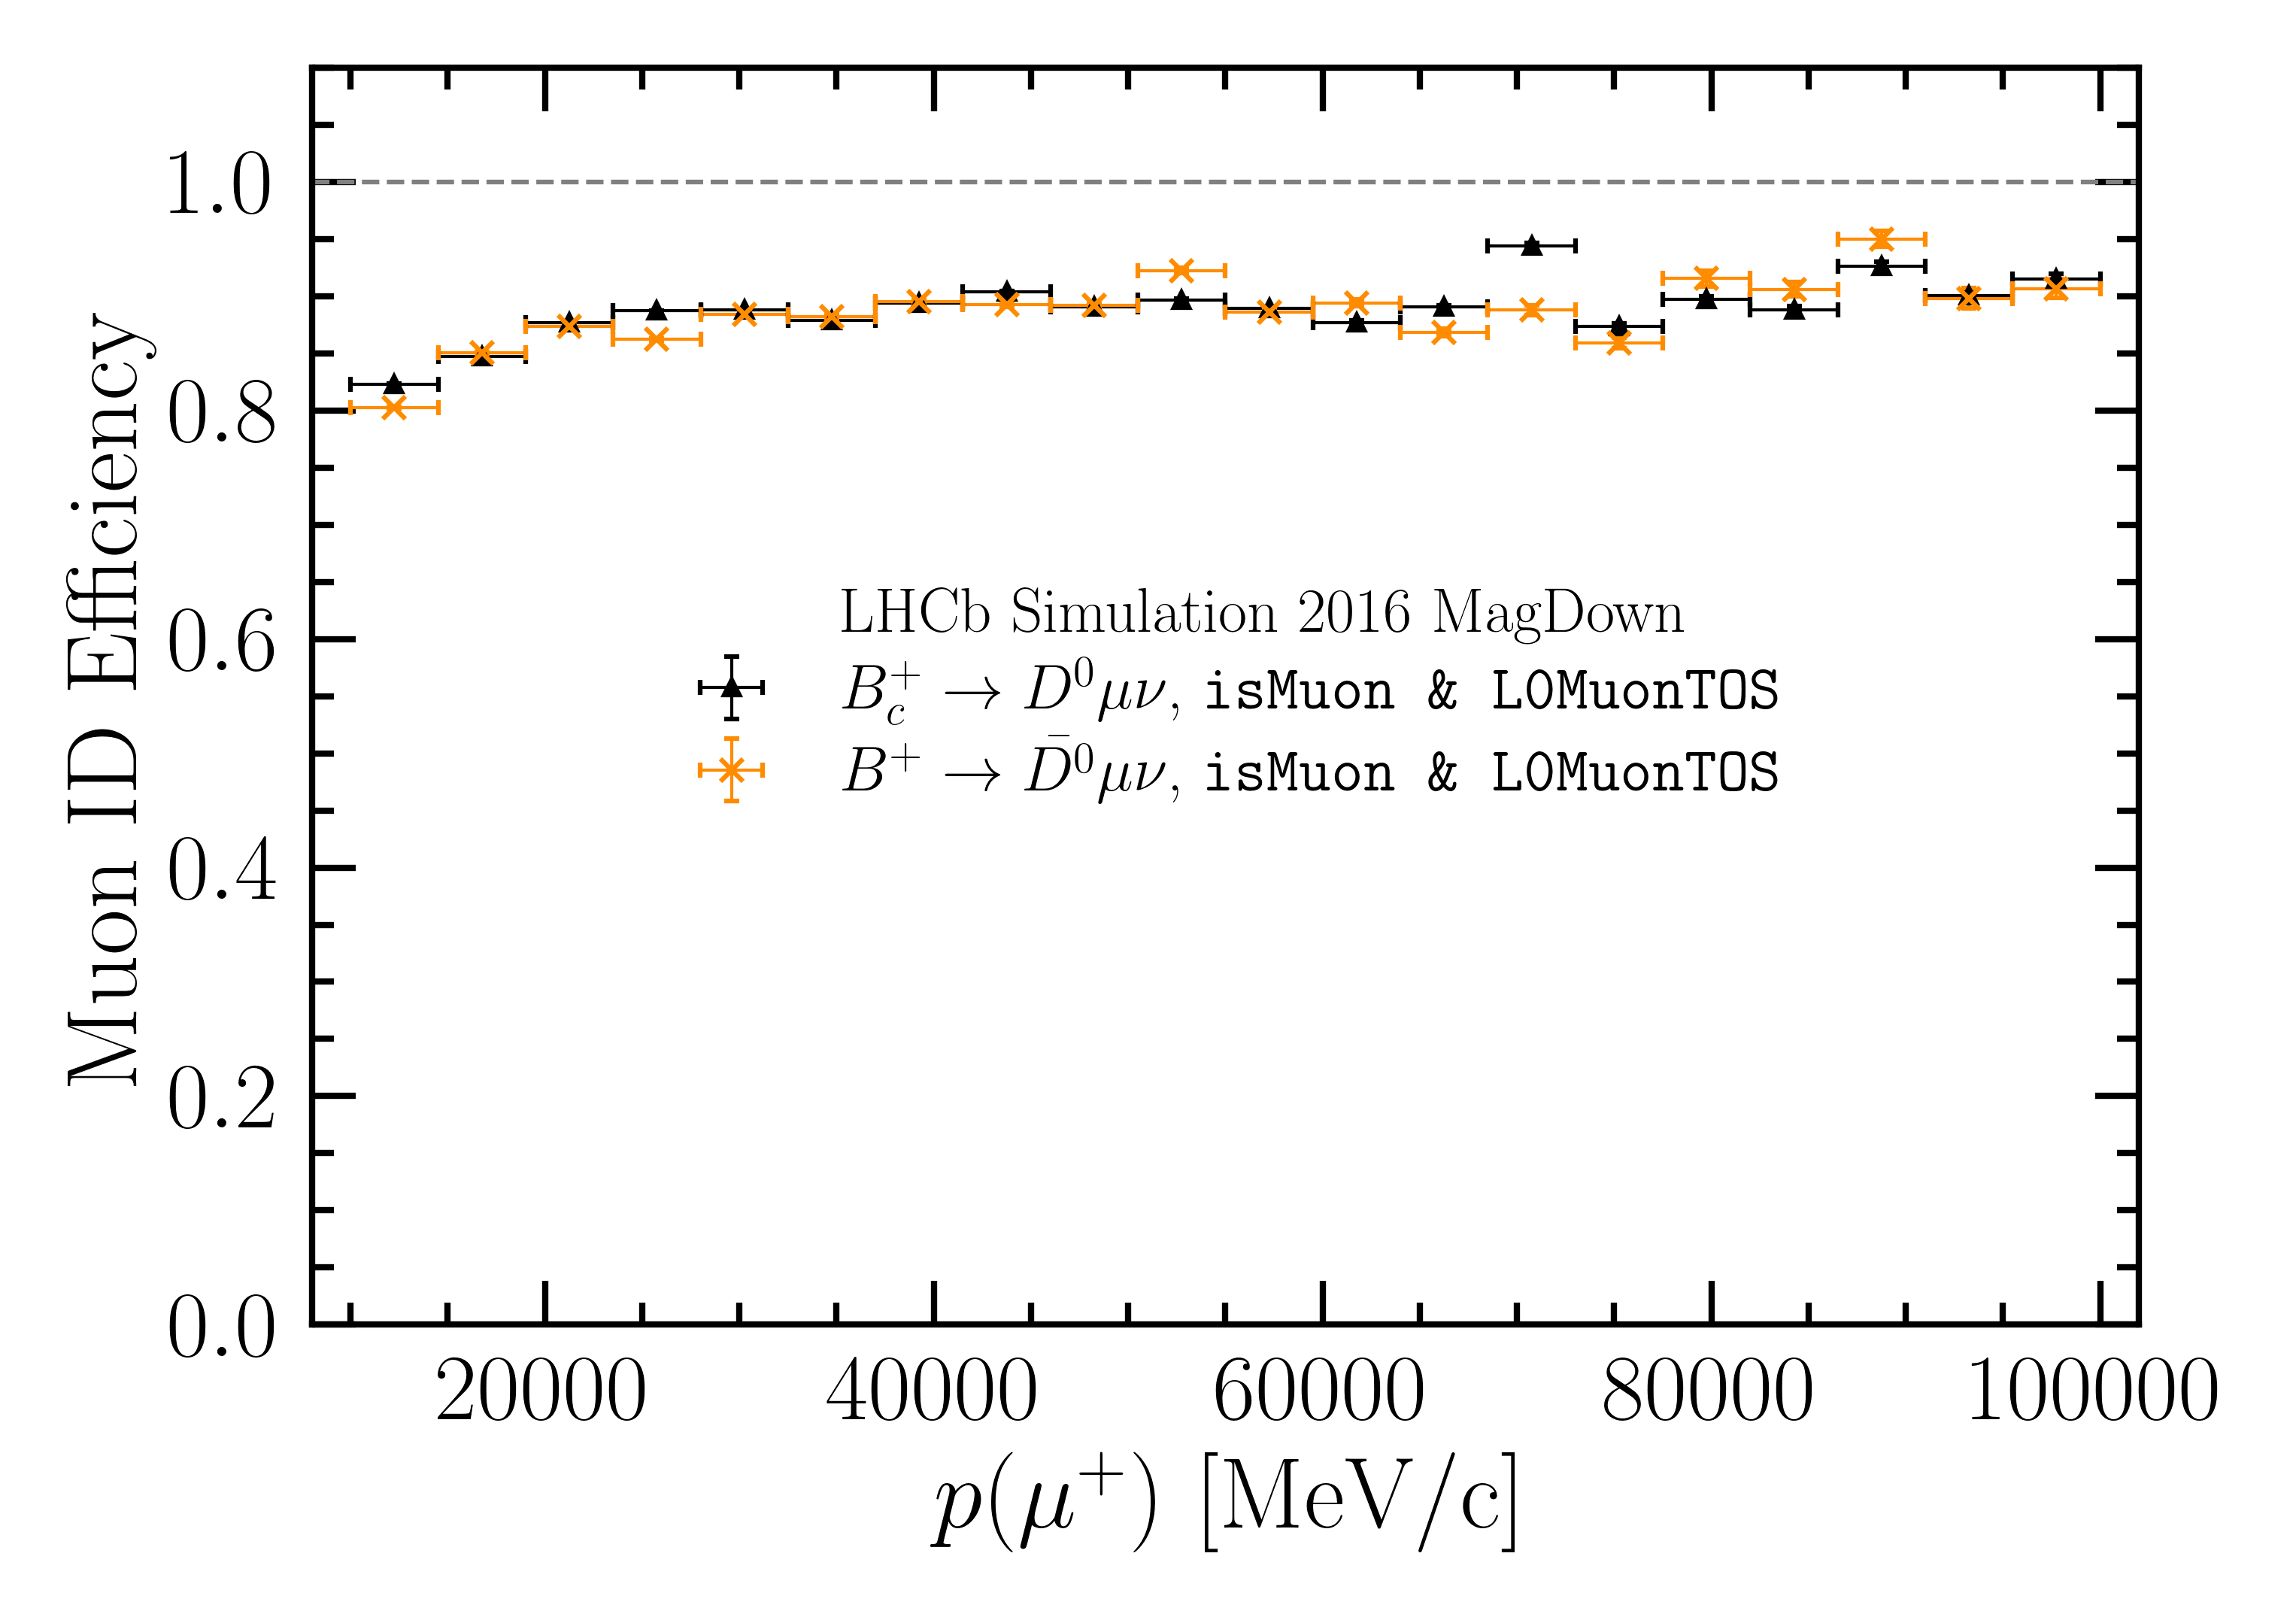

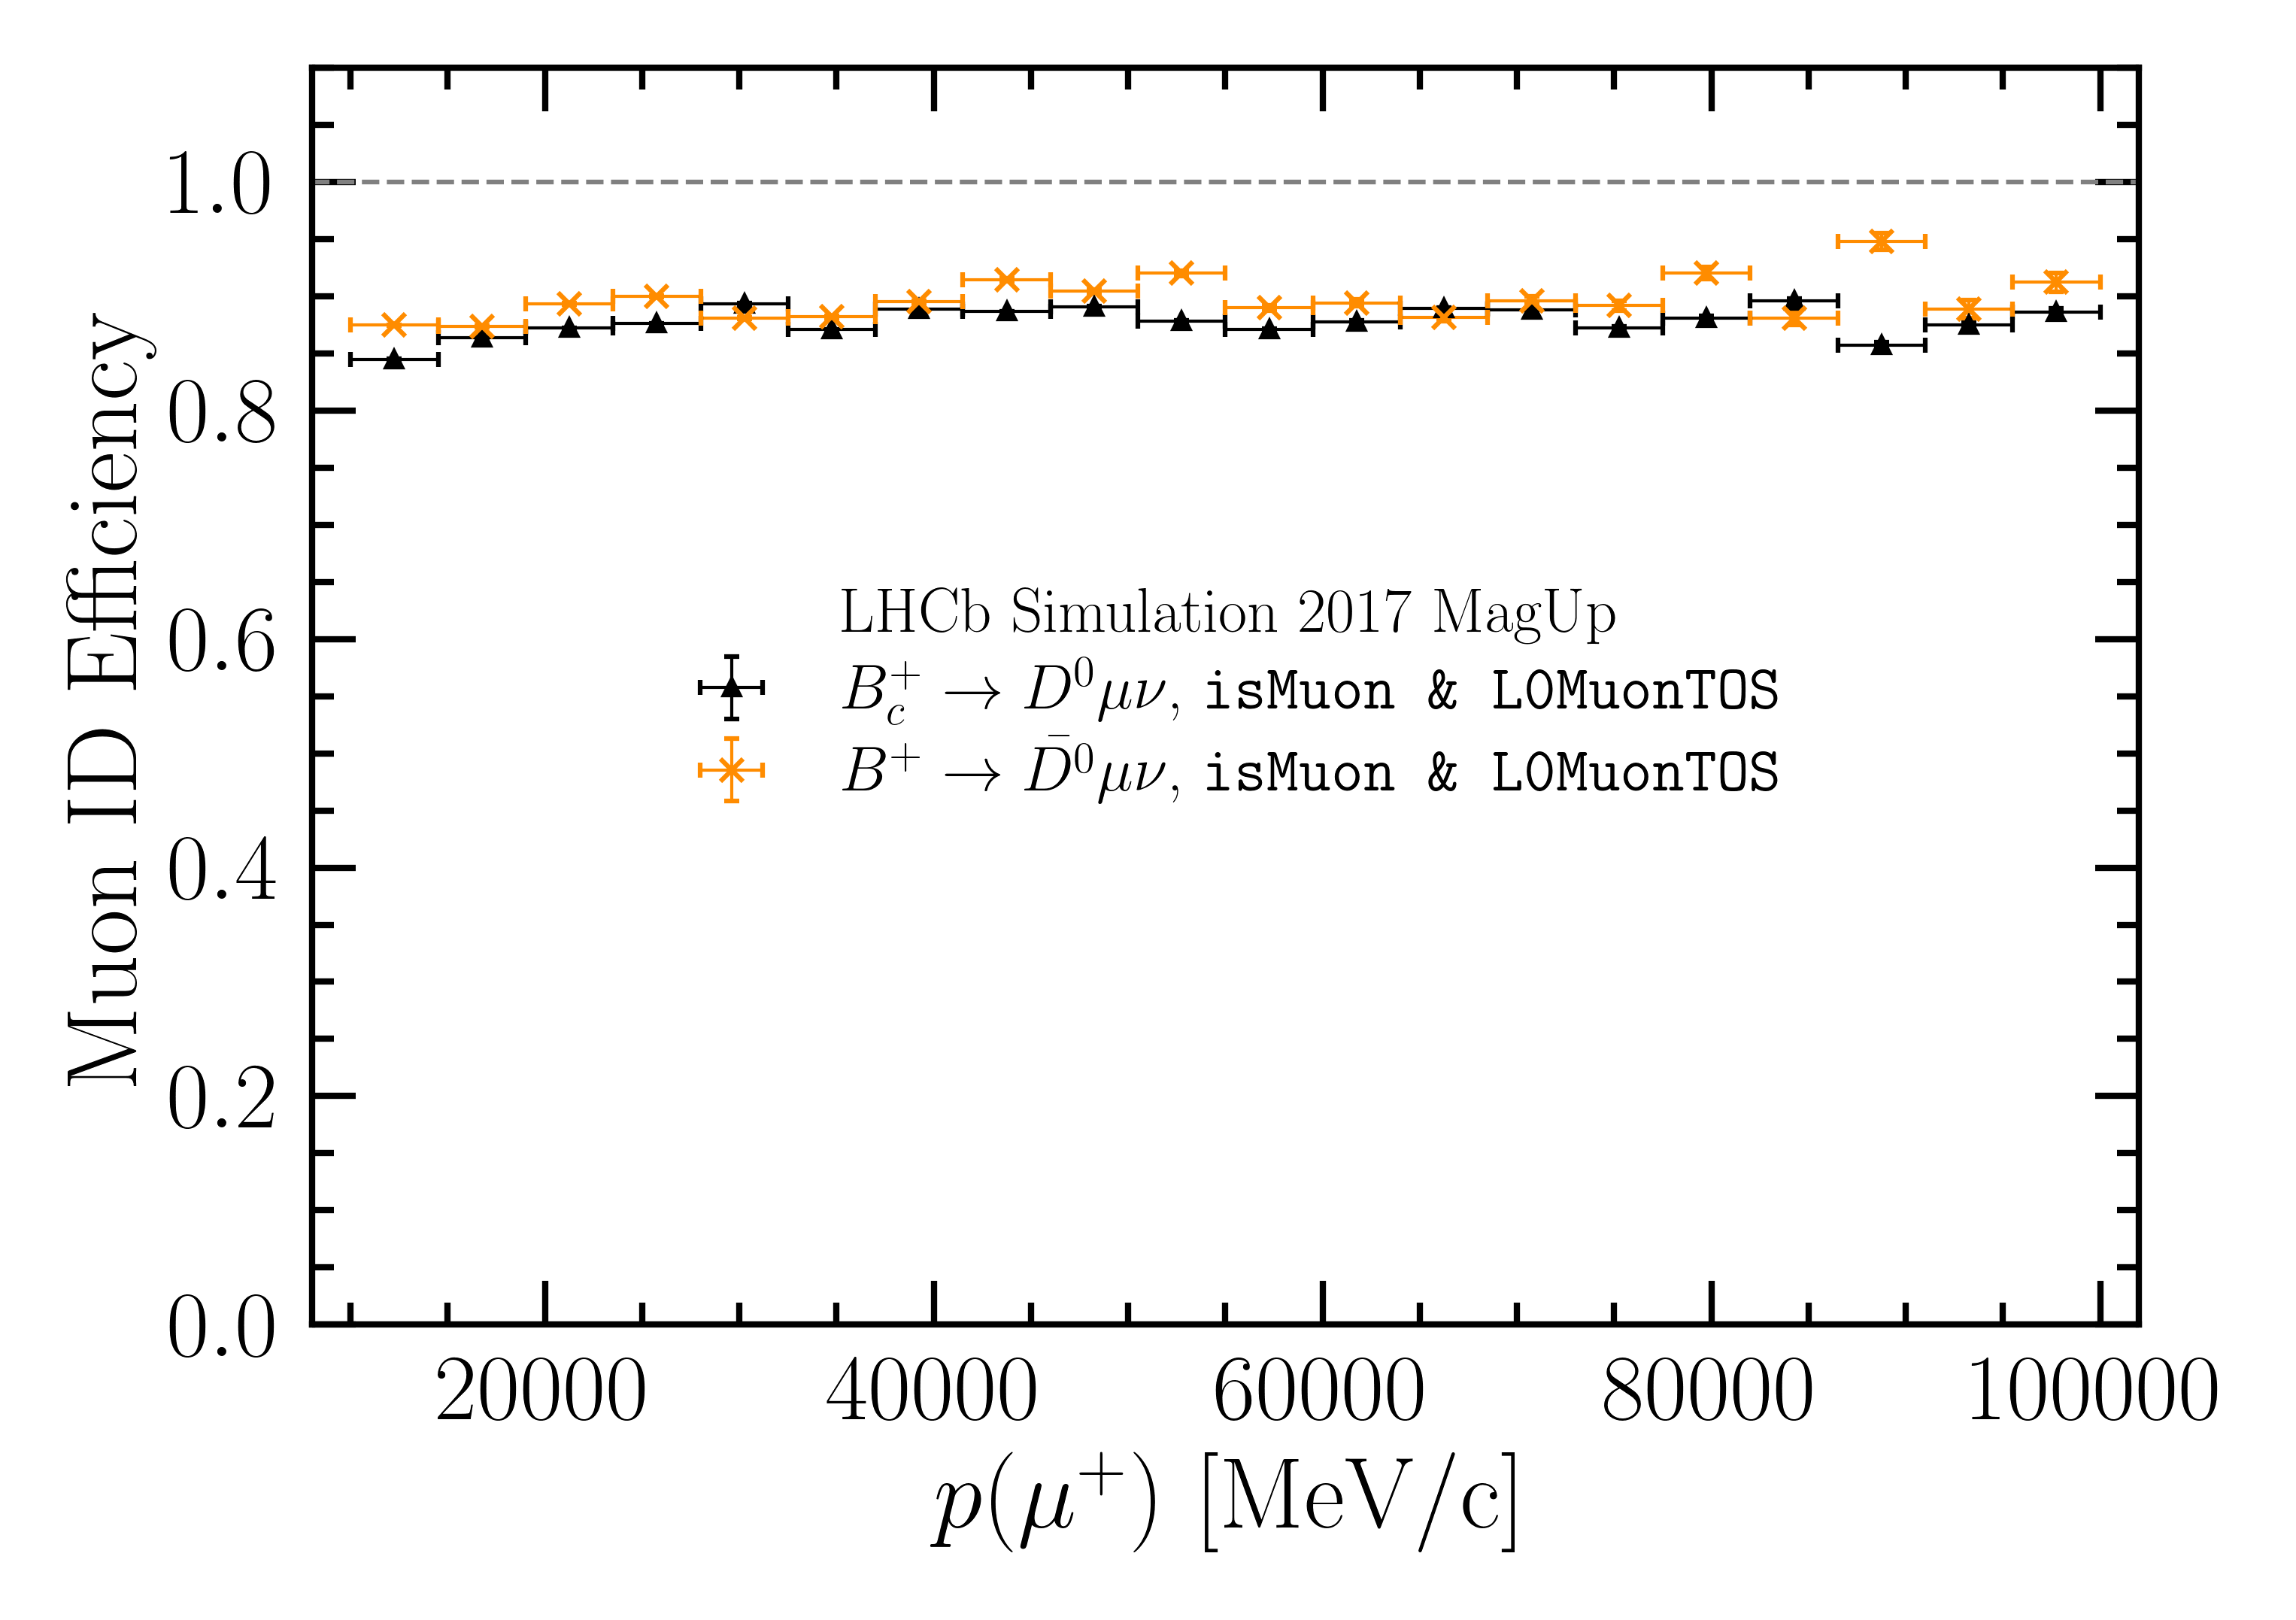

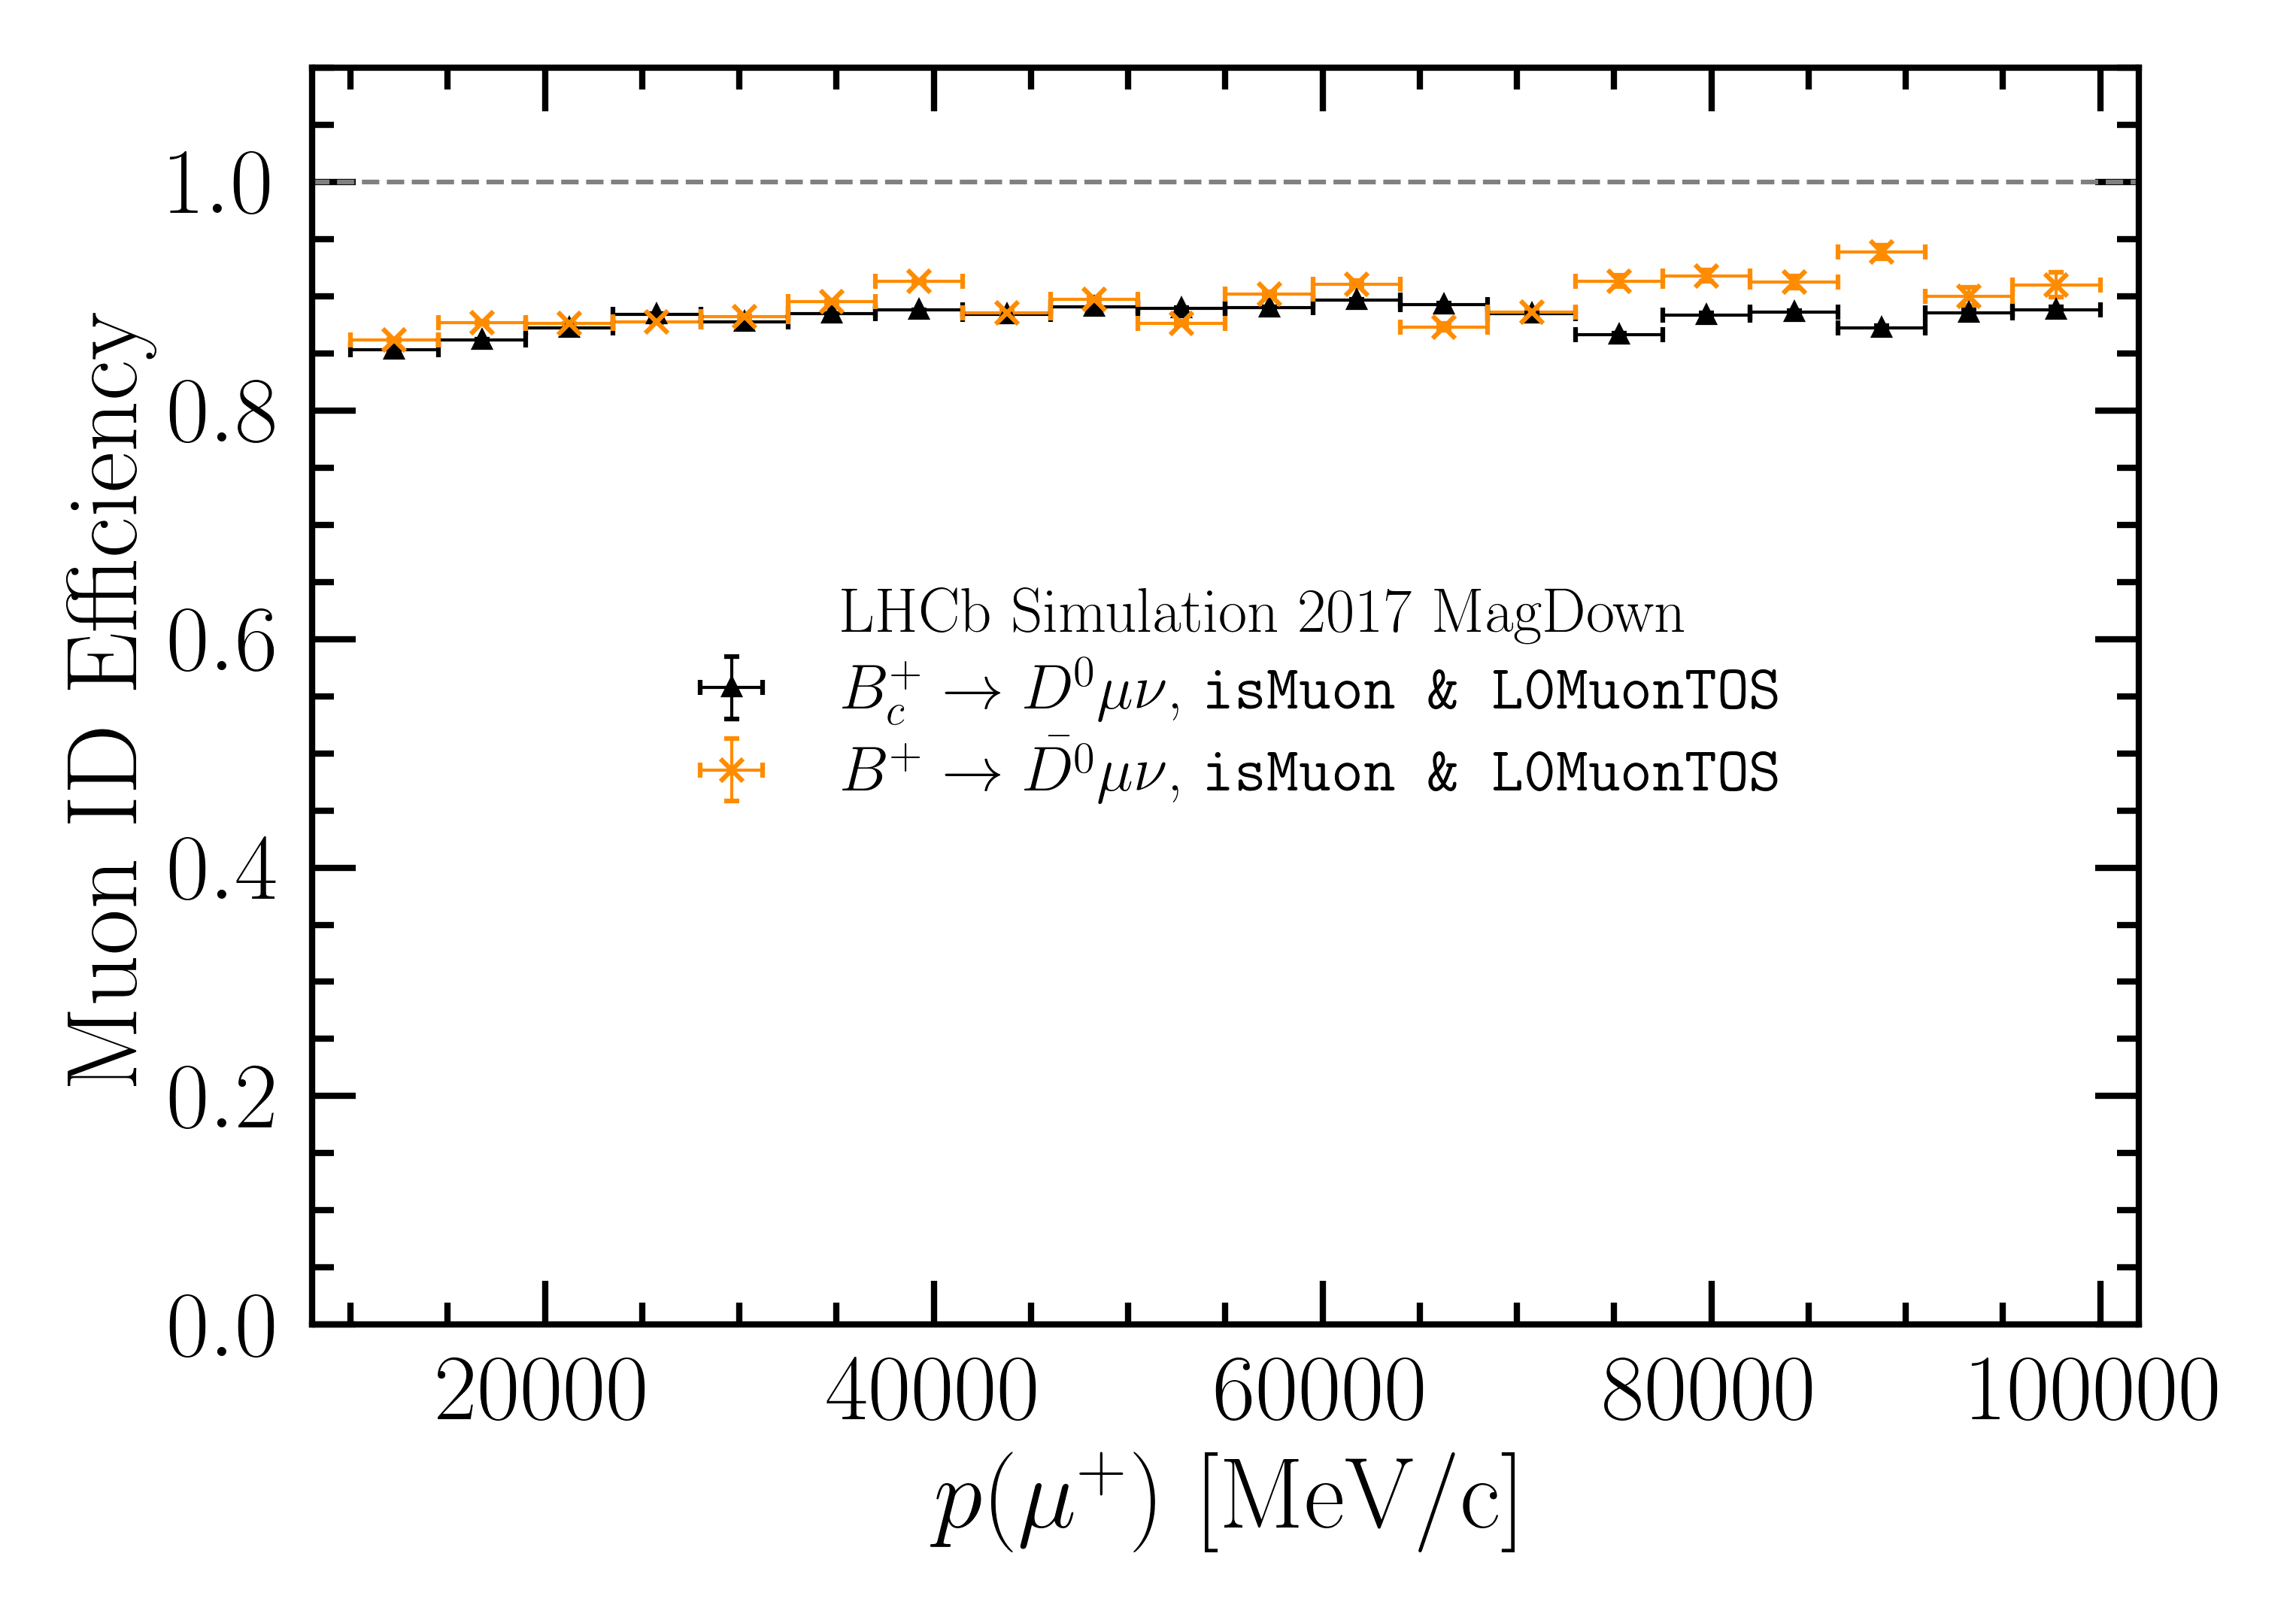

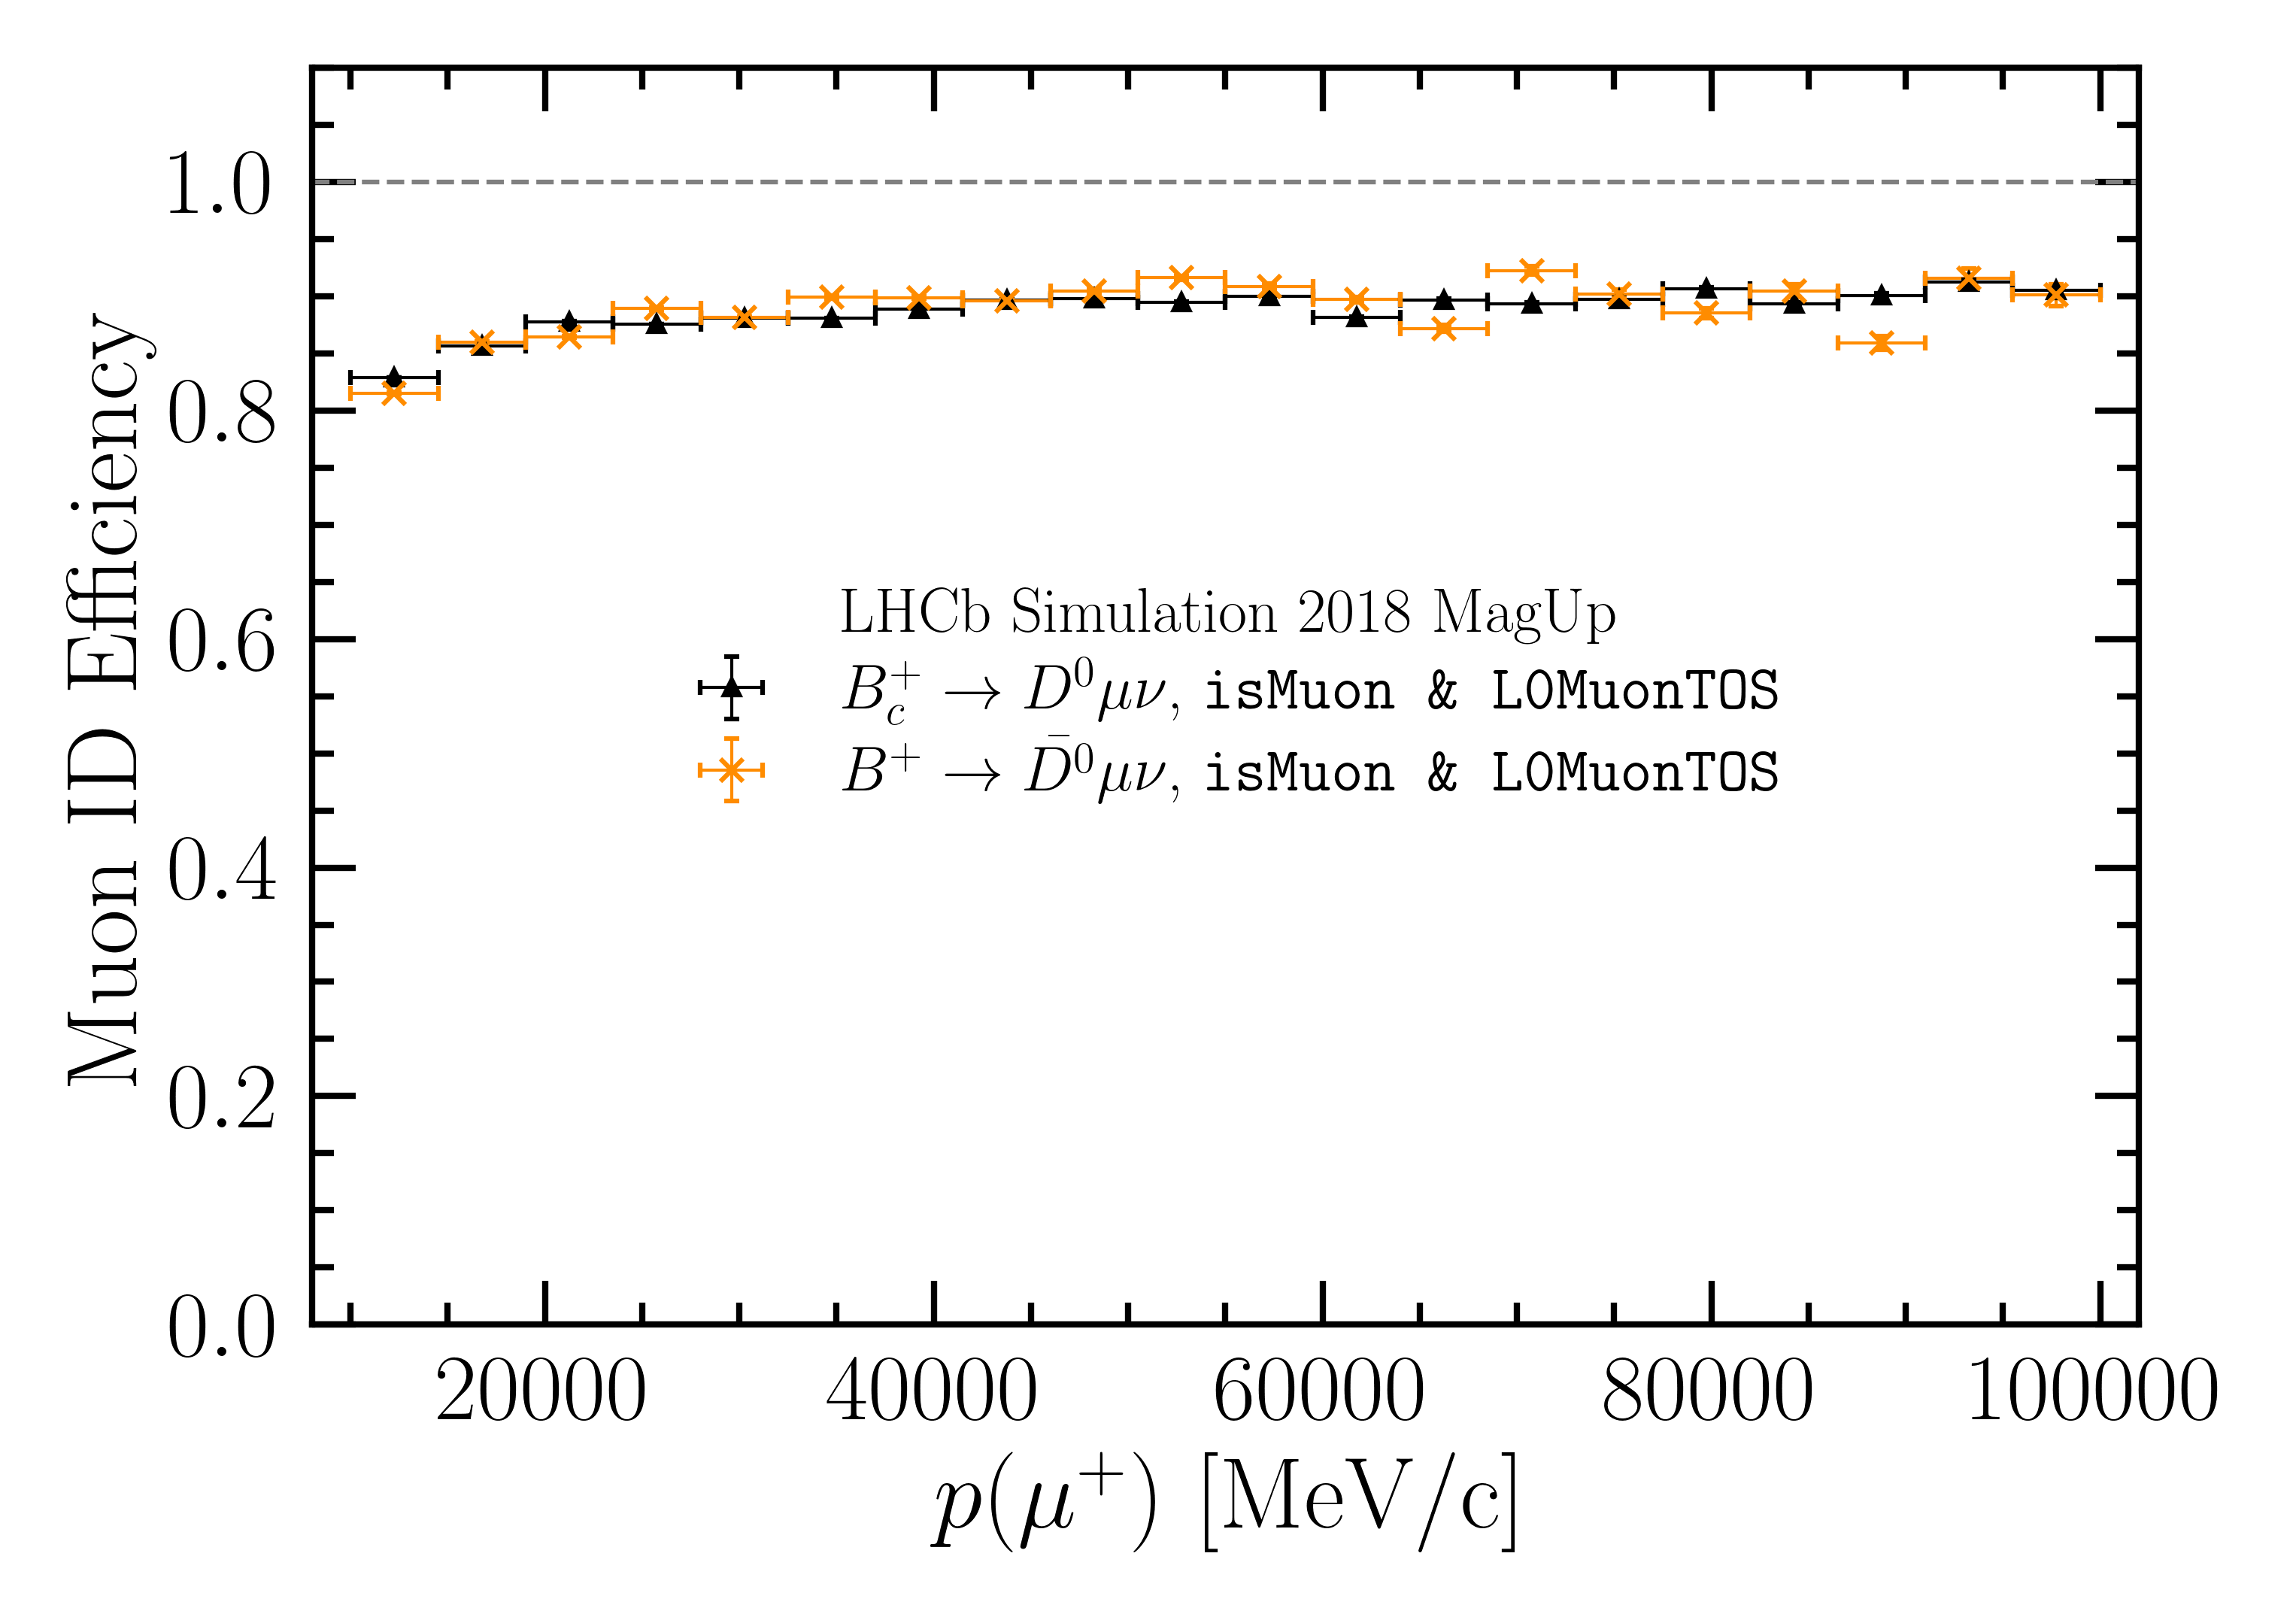

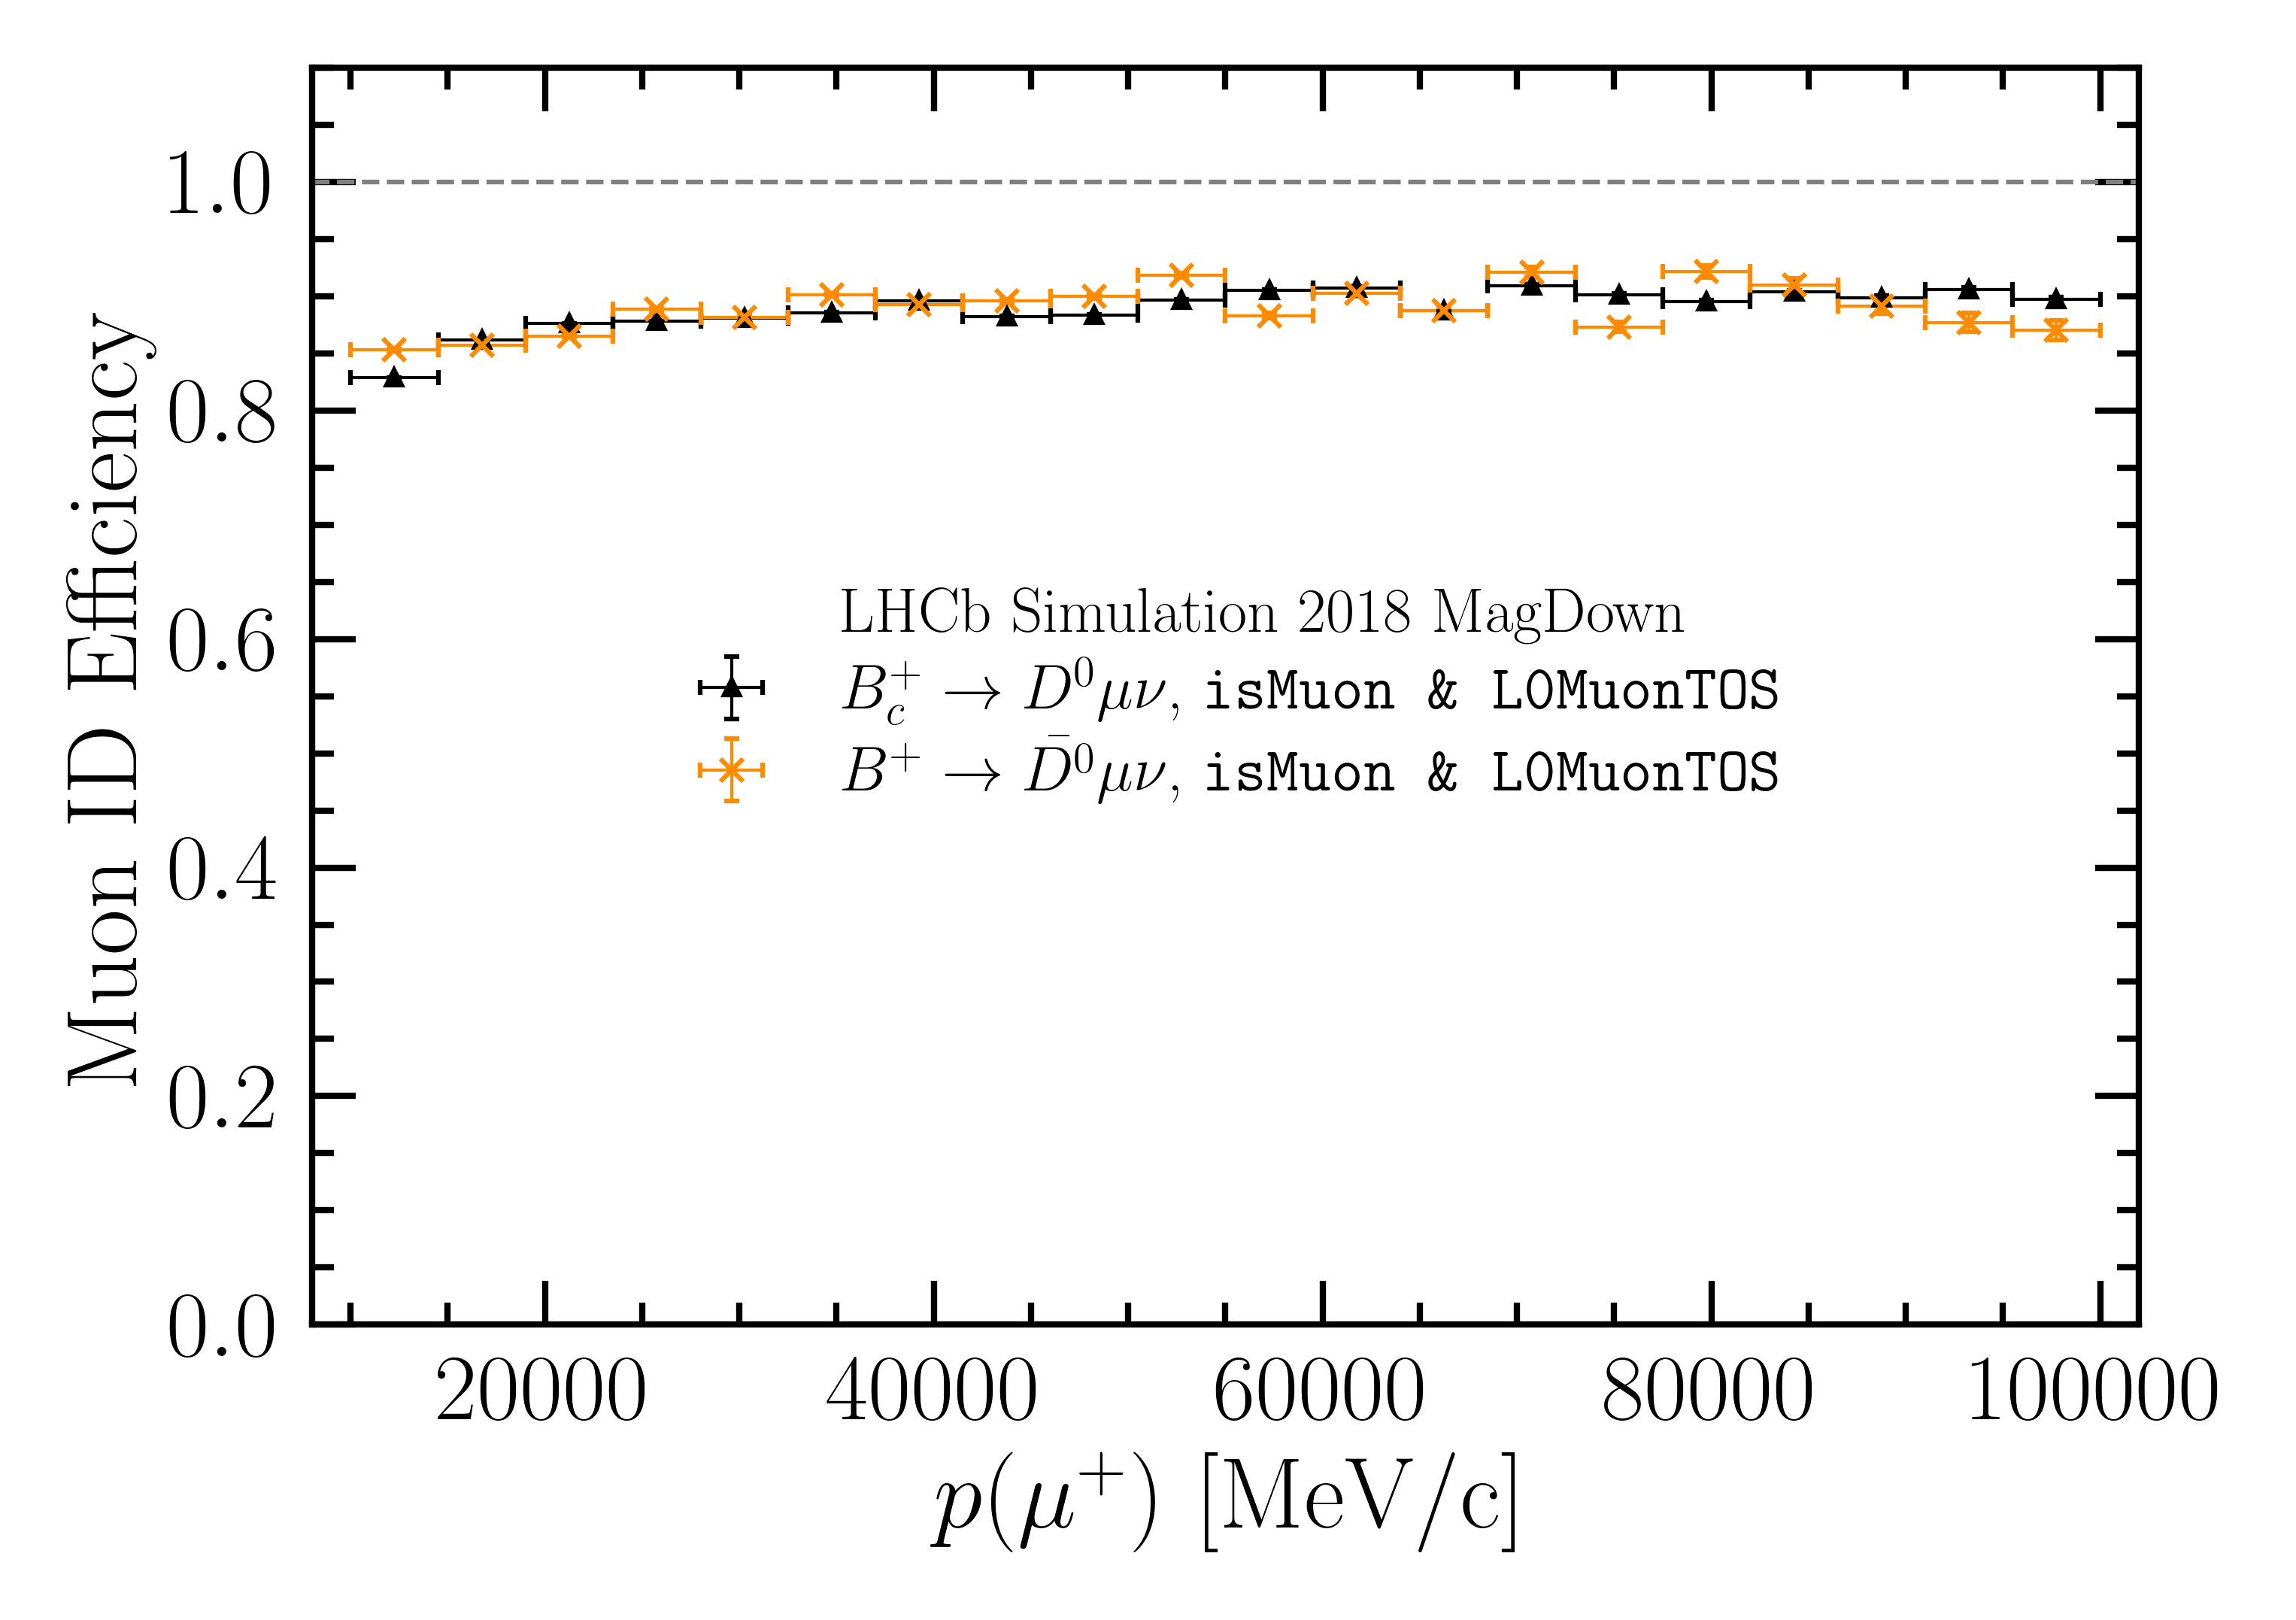

In [210]:
for y in ["2011", "2012", "2015", "2016", "2017", "2018"]:
    for m in ["MU", "MD"]:
        BcMC = pandas.DataFrame(RDF("DecayTree", f"MC_Bc2D0MuNu_{y}_{m}.root").AsNumpy())
        BuMC = pandas.DataFrame(RDF("DecayTree", f"MC_Bu2D0MuNu_{y}_{m}.root").AsNumpy())

        nocuts_hist = tohist(cvals=BcMC["Mu_plus_P"])
        ismuon_hist = tohist(cvals=BcMC.query("Mu_plus_isMuon==True and Mu_plus_L0MuonDecision_TOS==False")["Mu_plus_P"])
        l0muon_hist = tohist(cvals=BcMC.query("Mu_plus_L0MuonDecision_TOS==True and Mu_plus_isMuon==False")["Mu_plus_P"])
        muon_id_hist= tohist(cvals=BcMC.query("Mu_plus_L0MuonDecision_TOS==True and Mu_plus_isMuon==True")["Mu_plus_P"])

        # bu
        bu_nocuts_hist = tohist(cvals=BuMC["Mu_plus_P"])
        bu_muon_id_hist= tohist(cvals=BuMC.query("Mu_plus_L0MuonDecision_TOS==True and Mu_plus_isMuon==True")["Mu_plus_P"])

        ismuon_eff  = ismuon_hist.view()/nocuts_hist.view()
        l0muon_eff  = l0muon_hist.view()/nocuts_hist.view()
        muon_id_eff = muon_id_hist.view()/nocuts_hist.view()

        # bu
        bu_muon_id_eff = bu_muon_id_hist.view()/bu_nocuts_hist.view()


        _ = plt.figure(figsize=(10, 7));
        if m=="MU": mag="MagUp"
        if m=="MD": mag="MagDown"
        plt.plot([], [], "", label=f"LHCb Simulation {y} {mag}", color="white")
        plt.errorbar(x=nocuts_hist.axes[0].centers, y=muon_id_eff, 
                     xerr=nocuts_hist.axes[0].widths/2, 
                     yerr=eff_std(N=nocuts_hist.view(), k=muon_id_eff),
                     fmt="^", markersize=5, elinewidth=1., color="black", 
                     label=r"$B_c^{+}\rightarrow D^{0}\mu\nu$, \texttt{isMuon \& L0MuonTOS}")
        plt.errorbar(x=bu_nocuts_hist.axes[0].centers, y=bu_muon_id_eff, 
                     xerr=nocuts_hist.axes[0].widths/2, 
                     yerr=eff_std(N=bu_nocuts_hist.view(), k=bu_muon_id_eff),
                     fmt="x", markersize=7, elinewidth=1., 
                     color="darkorange", 
                     label=r"$B^{+}\rightarrow \bar{D^{0}}\mu\nu$, \texttt{isMuon \& L0MuonTOS}")
        plt.axhline(y = 1.0 , color = 'grey', linestyle = '--', linewidth=1.5, alpha=1.) 
        plt.xlim([8e3, 102e3])
        plt.ylim([.0, 1.1])
        plt.xlabel(rf"$p(\mu^+)$   [MeV/c]", loc="center")
        plt.ylabel(rf"Muon ID Efficiency", loc="center")
        plt.legend(loc="center", fontsize=20)

        plt.savefig(f"/usera/delaney/private/Bc2D0MuNuX/PIDCalib/scratch/muonID_eff_{y}_{mag}.pdf")
        plt.savefig(f"/usera/delaney/private/Bc2D0MuNuX/PIDCalib/scratch/muonID_eff_{y}_{mag}.png")

In [8]:
nocuts_hist.view()

WeightedSumView(
      [(345921.34995664, 37702359.60254303),
       (436774.26695502, 54303333.86904747),
       (491138.82748504, 67694483.00662166),
       (528919.24103126, 79473749.75680806),
       (546788.7108976 , 88490400.38405797),
       (529219.82333127, 91346069.69546734),
       (522351.84467052, 95459173.72015604),
       (499278.24822407, 96006052.42597406),
       (431166.970041  , 86845179.34803745),
       (395138.10529733, 83017242.54986274),
       (356230.63403438, 77862018.40339364),
       (343154.37647587, 77785134.17908952),
       (301411.69871606, 70705946.47098814),
       (283105.32862779, 68508593.14985247),
       (247322.02772054, 61665790.31010605),
       (231810.13931982, 59446201.74825498),
       (205101.84149918, 54003965.79427246),
       (188837.21174502, 51017668.81746403),
       (170683.42849336, 47219111.14323785),
       (153135.24166158, 43348320.19191392),
       (135428.24233095, 39191282.34517965),
       (129715.86630045, 38329880.1677

In [12]:
# book histograms: central value:=eff, weight:=error**2
nocuts_hist = Hist( hist.axis.Regular(
    20, 10e3, 100e3, name="S", label="p [MeV/c]",
    ),
    storage=hist.storage.Weight()
)

ismuon_hist = Hist( hist.axis.Regular(
    20, 10e3, 100e3, name="S", label="p [MeV/c]", underflow=False, overflow=False
    ),
    storage=hist.storage.Weight()
)

l0muon_hist = Hist( hist.axis.Regular(
    20, 10e3, 100e3, name="S", label="p [MeV/c]", underflow=False, overflow=False
    ),
    storage=hist.storage.Weight()
)

muon_id_hist = Hist( hist.axis.Regular(
    20, 10e3, 100e3, name="S", label="p [MeV/c]", underflow=False, overflow=False
    ),
    storage=hist.storage.Weight()
)

In [8]:
# fill hist with no cuts
nocuts_hist.fill(BcMC["B_plus_P"], weight=np.sqrt(BcMC["B_plus_P"]))

Hist(Regular(20, 10000, 100000, name='S', label='p [MeV/c]'), storage=Double()) # Sum: 7285887.508899742 (12127736.466696715 with flow)

# Template fits

In [12]:
# from python.config import reco_cuts #for some reason not working in jupyter

# emulate what is read in from config.py 
# other cuts, per-PIDmu-bin, for the reco categories

# UPDATE: L0Muon and isMuon have been removed from data, PIDCalib templates how hardly any real muons -> remove from eff and reco 
reco_cuts = {}
reco_cuts["kaon"]      = "_ProbNNghost<0.2 && DLLK>0.0 && (DLLK-DLLp)>0.0 && (DLLK-DLLe)>0.0 && IsMuon==0.0 && InMuonAcc==1.0 && nShared==0"
reco_cuts["pion"]      = "_ProbNNghost<0.2 && DLLK<0.0 && DLLp<0.0 && DLLe<0.0 && IsMuon==0.0 && InMuonAcc==1.0 && nShared==0"
reco_cuts["proton"]    = "_ProbNNghost<0.2 && DLLp>0.0 && (DLLp-DLLK)>0.0 && (DLLp-DLLe)>0.0 && IsMuon==0.0 && InMuonAcc==1.0 && nShared==0"
#reco_cuts["muon"]      = "_ProbNNghost<0.2 && (DLLmu-DLLp)>0.0 && (DLLmu-DLLe)>0.0 && (DLLmu-DLLK)>0 && IsMuon==1.0 && InMuonAcc==1.0 && nShared==0"
reco_cuts["electron"]  = "_ProbNNghost<0.2 && DLLe>0.0 && (DLLe-DLLK)>0.0 && (DLLe-DLLp)>0.0 && IsMuon==0.0 && InMuonAcc==1.0 && nShared==0"
# need to still study the efficiency of a true candidate to be reconstructed as a ghost
reco_cuts["ghost"]     = "_ProbNNghost>=0.2 && IsMuon==0.0 && InMuonAcc==1.0 && nShared==0"

In [13]:
# emulate the wildcards that we expect in DAG
# read in /exec/2018/MagUp/dllmu_high/
YEAR       = "2018"
MAGPOL     = "MagUp"
DLLMU_BIN  = "dllmu_low"

In [14]:
# same as above, emalulate readin in from config.py
binning = {}
binning["p"] = [10000, 20000, 40000, 100000]
binning["eta"] = [1.5, 3.0, 5.0]
binning["ntracks"] = [0, 250, 500]

In [15]:
labels = {}
labels["kaon"]       = "K"
labels["pion"]       = "\pi"
labels["proton"]     = "p"
labels["electron"]   = "e"
#labels["muon"]       = "\mu"
labels["dllmu_high"] = "high DLL$\mu$ bin"
labels["dllmu_low"]  = "low DLL$\mu$ bin"
labels["ghost"]      = "g"

In [16]:
calib_species = ["kaon", "pion", "proton", "electron"]
#calib_species = ["kaon", "pion", "proton", "muon", "electron"]

In [17]:
# now we can loop the reco cats and read in the eff.pkl
reco_eff_dict = {}

for REAL in calib_species:
    reco_eff_dict[REAL] = {}
    for RECO_CAT in reco_cuts.keys():
        pkl = f"exec/{YEAR}/{MAGPOL}/{DLLMU_BIN}/{REAL}/misID_{REAL}_to{RECO_CAT}_{DLLMU_BIN}_{YEAR}_{MAGPOL}/eff_th3w.pkl"
        with open(pkl, "rb") as f_in: reco_eff_dict[REAL][RECO_CAT] = pickle.load(f_in)

'''
name:
  "MassCuts"

AngCuts:
  " CosXY_Mu_plus_D0 > -0.4 && CosXYZ_Mu_plus_Pi_1 < 0.9997 && CosXYZ_Mu_plus_K_minus < 0.9997 "

D0MassCuts:
  " D0_M >= 1790 && D0_M <= 1940 "

BplusMassCuts:
  " B_plus_M > 1864.83+105.6584 && B_plus_M < 6275.6  && FitVar_Mmiss2 > -5e6"

BplusDIRA:
  " B_plus_DIRA_OWNPV > 0.999 "

LifetimeCut:
  " B_plus_FIT_LTIME > 0 "

CorrectedMassErr:
  " B_plus_MCORRERR<650 "
'''

In [18]:
# now proceed to reading in the misID file (with all the anti-prescale weights)
COLUMNS=["B_plus_M", "B_plus_MCORR", "B_plus_FIT_LTIME", "D0_M", "K_minus_ID", "Mu_plus_ID", "B_plus_MCORRERR",\
         "B_plus_DIRA_OWNPV", "FitVar_Mmiss2", "CosXY_Mu_plus_D0", "CosXYZ_Mu_plus_Pi_1", "CosXYZ_Mu_plus_K_minus", \
         "fakemuon_w", "Mu_plus_P", "nTracks", "Mu_plus_LK_ETA", "Mu_plus_PIDmu", "Mu_plus_ProbNNghost", "Mu_plus_PIDK", "Mu_plus_PIDe", "Mu_plus_PIDp"]

In [19]:
if MAGPOL=="MagUp": polarity="MU"
if MAGPOL=="MagDown": polarity="MD"
misid_f_in = uproot.open(f"/r01/lhcb/Bc2D0MuNuX/pipeline/hadron_enriched/DATA/merged_misid/D0MuNu/{YEAR}/{polarity}/Bc2D0MuNuX.root:DecayTree")
misid_df = misid_f_in.arrays(COLUMNS, library="pd")

# NEED TO REQUIRE DCS SIGN COMBINATION
misid_df = misid_df.query("K_minus_ID*Mu_plus_ID>0") # muon bools already applied and DLLmu range set, study below bins of {p, eta, ntracks}

In [20]:
len(misid_df.query("fakemuon_w==50")) == len(misid_df) # only fakemuons contribute as StdAllLooseMuons in the stripping have IsMuon=True

True

In [21]:
from hist import Hist
# now create a boost container for every reco category x {p, eta, nTracks}
full_eff_hist = Hist(
    hist.axis.StrCategory(calib_species,     name="calib"),
    hist.axis.StrCategory(reco_cuts.keys(),  name="reco",      label=f"reco {reco_cuts.keys()}"),
    hist.axis.Variable(binning["p"],         name="p",         label="$p$   [MeV]"),
    hist.axis.Variable(binning["eta"],       name="eta",       label="$\eta$"),
    hist.axis.Variable(binning["ntracks"],   name="ntracks",   label="nTracks"),
    storage=hist.storage.Weight()
)

In [22]:
full_eff_hist

Hist(
  StrCategory(['kaon', 'pion', 'proton', 'electron']),
  StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost']),
  Variable([10000, 20000, 40000, 100000]),
  Variable([1.5, 3, 5]),
  Variable([0, 250, 500]),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0)

In [23]:
reco_eff_dict["kaon"]

{'kaon': Histogram(
   Variable([10000, 20000, 40000, 100000]),
   Variable([1.5, 3, 5]),
   Variable([0, 250, 500]),
   storage=Weight()) # Sum: WeightedSum(value=7.38354, variance=8.23217e-07) (WeightedSum(value=10.9942, variance=0.0711695) with flow),
 'pion': Histogram(
   Variable([10000, 20000, 40000, 100000]),
   Variable([1.5, 3, 5]),
   Variable([0, 250, 500]),
   storage=Weight()) # Sum: WeightedSum(value=0.30547, variance=1.67221e-07) (WeightedSum(value=0.514859, variance=0.00141271) with flow),
 'proton': Histogram(
   Variable([10000, 20000, 40000, 100000]),
   Variable([1.5, 3, 5]),
   Variable([0, 250, 500]),
   storage=Weight()) # Sum: WeightedSum(value=0.379261, variance=1.67094e-07) (WeightedSum(value=0.878368, variance=0.00872231) with flow),
 'electron': Histogram(
   Variable([10000, 20000, 40000, 100000]),
   Variable([1.5, 3, 5]),
   Variable([0, 250, 500]),
   storage=Weight()) # Sum: WeightedSum(value=0.0307238, variance=2.20978e-08) (WeightedSum(value=0.052351

In [24]:
# now fill, using the reco-ID to map everything
for c in reco_eff_dict.keys(): # loop the calibration samples
    for r in reco_eff_dict[c]: # loop over reco categories for a given calibration sample
        print(f"loading in calib : {c}, reco: {r}")
        full_eff_hist[f"{c}", f"{r}", ...]  = reco_eff_dict[f"{c}"][f"{r}"].view()

loading in calib : kaon, reco: kaon
loading in calib : kaon, reco: pion
loading in calib : kaon, reco: proton
loading in calib : kaon, reco: electron
loading in calib : kaon, reco: ghost
loading in calib : pion, reco: kaon
loading in calib : pion, reco: pion
loading in calib : pion, reco: proton
loading in calib : pion, reco: electron
loading in calib : pion, reco: ghost
loading in calib : proton, reco: kaon
loading in calib : proton, reco: pion
loading in calib : proton, reco: proton
loading in calib : proton, reco: electron
loading in calib : proton, reco: ghost
loading in calib : electron, reco: kaon
loading in calib : electron, reco: pion
loading in calib : electron, reco: proton
loading in calib : electron, reco: electron
loading in calib : electron, reco: ghost


As a check, let's source the eff table obtained via ROOT and nicely tabulated in git-md

|   P bin |   P cent |   P low |   P high |   ETA bin |   ETA cent |   ETA low |   ETA high |   nTrk bin |   nTrk cent |   nTrk low |   nTrk high |         eff |         err |
|---------|----------|---------|----------|-----------|------------|-----------|------------|------------|-------------|------------|-------------|-------------|-------------|
|       1 |    15000 |   10000 |    20000 |         1 |       2.25 |       1.5 |          3 |          1 |         125 |          0 |         250 | 0.00666697  | 4.63579e-05 |
|       1 |    15000 |   10000 |    20000 |         1 |       2.25 |       1.5 |          3 |          2 |         375 |        250 |         500 | 0.0109753   | 0.00014129  |
|       1 |    15000 |   10000 |    20000 |         2 |       4    |       3   |          5 |          1 |         125 |          0 |         250 | 0.000904586 | 2.21955e-05 |
|       1 |    15000 |   10000 |    20000 |         2 |       4    |       3   |          5 |          2 |         375 |        250 |         500 | 0.00219146  | 8.50564e-05 |
|       2 |    30000 |   20000 |    40000 |         1 |       2.25 |       1.5 |          3 |          1 |         125 |          0 |         250 | 0.00181193  | 3.29005e-05 |
|       2 |    30000 |   20000 |    40000 |         1 |       2.25 |       1.5 |          3 |          2 |         375 |        250 |         500 | 0.0039825   | 0.000111612 |
|       2 |    30000 |   20000 |    40000 |         2 |       4    |       3   |          5 |          1 |         125 |          0 |         250 | 0.00108158  | 1.80223e-05 |
|       2 |    30000 |   20000 |    40000 |         2 |       4    |       3   |          5 |          2 |         375 |        250 |         500 | 0.00419471  | 8.49566e-05 |
|       3 |    70000 |   40000 |   100000 |         1 |       2.25 |       1.5 |          3 |          1 |         125 |          0 |         250 | 0.00086197  | 4.07595e-05 |
|       3 |    70000 |   40000 |   100000 |         1 |       2.25 |       1.5 |          3 |          2 |         375 |        250 |         500 | 0.00137364  | 0.00011528  |
|       3 |    70000 |   40000 |   100000 |         2 |       4    |       3   |          5 |          1 |         125 |          0 |         250 | 0.00104477  | 1.85561e-05 |
|       3 |    70000 |   40000 |   100000 |         2 |       4    |       3   |          5 |          2 |         375 |        250 |         500 | 0.00366704  | 7.99206e-05 |



In [25]:
full_eff_hist

Hist(
  StrCategory(['kaon', 'pion', 'proton', 'electron']),
  StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost']),
  Variable([10000, 20000, 40000, 100000]),
  Variable([1.5, 3, 5]),
  Variable([0, 250, 500]),
  storage=Weight()) # Sum: WeightedSum(value=31.7267, variance=0.00124329)

In [26]:
# this is very ugly, I wish I could find a nice way to project out the reco categories
def build_template(alleffs, true_species, p_bin, eta_bin, ntr_bin, isnorm=True):
    """Ugly-ass function to project out the efficiencies for a given true species in bins
    of reco category, for a given bin in {p, eta, ntracks}
    
    returns: 
        1. np.array of central values of PID eff in bins of reco categories
        2. np.array of errors of PID eff in bins of reco categories
    
    parameters:
    -----------
    alleffs: 5D histogram containing with Weight storage containing all eff+/-eff vals
    
    true_species: ['kaon', 'pion', 'proton', 'muon', 'electon', 'ghost'], the true particle/ghost 
    for which to query the effs in the various reco-categories
    
    p_bin, eta_bin, ntr_bin: indices of each bin of kinematics and occupancy
    
    isnorm: normalise to unity? [default: True]
    """
    true_species_proj_cvals = []
    true_species_proj_uncty = []
    
    for reco_cat in reco_cuts.keys():
        true_species_proj_cvals.append(alleffs[f"{true_species}", reco_cat, p_bin, eta_bin, ntr_bin].value)
        true_species_proj_uncty.append(alleffs[f"{true_species}", reco_cat, p_bin, eta_bin, ntr_bin].variance**.5)
    
    true_species_proj_cvals = np.array(true_species_proj_cvals)
    true_species_proj_uncty = np.array(true_species_proj_uncty)
    
    # need to catch negative efficiencies!
    true_species_proj_cvals[true_species_proj_cvals<0] = 0
    assert(true_species_proj_cvals.all()>=0) # efficiencies should all be >=0
    
    if isnorm==True:
        true_species_proj_cvals/=np.sum(true_species_proj_cvals)
        true_species_proj_uncty/=np.sum(true_species_proj_cvals) #ratio of error to central value preserved
            
    # insert here an assert statemenet to check that integral of arrays is consistent with unity
    
    return true_species_proj_cvals, true_species_proj_uncty

In [27]:
# now we need to compile the ghost-specific template: load the MC and fill, per reco category, efficiencies
import ROOT, pandas  
RDF = ROOT.ROOT.RDataFrame

# compile the ghost prob, both Mag Up and Mag Down
magpol_wildcard = "MagUp"
dllmu_wildcard = "dllmu_low"

print("NOTE: PID response not corrected")

if dllmu_wildcard == "dllmu_high" : dllmu_cut = "Mu_plus_PIDmu>0 && Mu_plus_PIDmu<=3"
if dllmu_wildcard == "dllmu_low"  : dllmu_cut = "Mu_plus_PIDmu<0"
    
in_RDF = RDF("B2DMuNuX_D02KPiTuple/DecayTree", f"root://eoslhcb.cern.ch//eos/lhcb/user/a/atully/Bc2D0munu/inclb2D0X/inclb2D0X_2016_{magpol_wildcard}_5M.root").Filter(f"Mu_plus_TRUEID==0 && Mu_plus_MC_MOTHER_ID==0 && {dllmu_cut}")
inclB2D0X = pandas.DataFrame( in_RDF.AsNumpy(columns=["Mu_plus_PIDe", "Mu_plus_PIDmu", "Mu_plus_PIDK", "Mu_plus_PIDp", "Mu_plus_MC15TuneV1_ProbNNghost", "Mu_plus_P", "Mu_plus_LK_ETA", "nTracks", "Mu_plus_isMuon", "Mu_plus_InMuonAcc", "Mu_plus_NShared"]) ) # checked that 15V1 same as ProbNNghost branch


def compute_cut_eff(tot_ghosts_df, sel):
    '''Utility function to compute the eff+/- err
    the error estimate is performed via binomial errors
    this is valid unless k=N or k=0
    source: Paterno, FERMILAB-TM-2286-CD
    '''
    N = len(tot_ghosts_df) # n_events after imposing ghost ID conditions
    k = tot_ghost_df.query(sel)
    eff = float(k/N)
    err = (1/N)*np.sqrt(k*(1-(k/N)))
    return (eff, err)

NOTE: PID response not corrected


In [28]:
# book hist
ghost_hist = Hist(
    hist.axis.StrCategory(["ghost"],         name="ghost_from_sim"),
    hist.axis.StrCategory(reco_cuts.keys(),  name="reco",      label=f"reco {reco_cuts.keys()}"),
    hist.axis.Variable(binning["p"],         name="p",         label="$p$   [MeV]"),
    hist.axis.Variable(binning["eta"],       name="eta",       label="$\eta$"),
    hist.axis.Variable(binning["ntracks"],   name="ntracks",   label="nTracks"),
    storage=hist.storage.Weight()
)

# actually quite handy to compile a boost object for the data too
data_hist = Hist(
    hist.axis.StrCategory(reco_cuts.keys(),  name="reco",      label=f"reco {reco_cuts.keys()}"),
    hist.axis.Variable(binning["p"],         name="p",         label="$p$   [MeV]"),
    hist.axis.Variable(binning["eta"],       name="eta",       label="$\eta$"),
    hist.axis.Variable(binning["ntracks"],   name="ntracks",   label="nTracks"),
)


# loop through all the partitions
for reco_category in reco_cuts.keys():
    
    # replacement needed (would be nice to use a lambda fn + iterator/map)
    reco_string = reco_cuts[reco_category].replace("&&", "and").replace("DLL", "Mu_plus_PID").replace("_ProbNNghost", "Mu_plus_MC15TuneV1_ProbNNghost").replace("IsMuon", "Mu_plus_isMuon").replace("InMuonAcc", "Mu_plus_InMuonAcc").replace("nShared", "Mu_plus_NShared")

    for u in range(len(binning["p"])-1):
        low_momentum_bin = binning["p"][u]
        high_momentum_bin = binning["p"][u+1]
        
        for v in range(len(binning["eta"])-1):
            low_eta_bin = binning["eta"][v]
            high_eta_bin = binning["eta"][v+1]
        
            for w in range(len(binning["ntracks"])-1):
                low_ntracks_bin = binning["ntracks"][w]
                high_ntracks_bin = binning["ntracks"][w+1]
                
                per_bin_sel = f"{reco_string} and Mu_plus_P>={low_momentum_bin} and Mu_plus_P<={high_momentum_bin} and Mu_plus_LK_ETA>={low_eta_bin} and Mu_plus_LK_ETA<={high_eta_bin} and nTracks>={low_ntracks_bin} and nTracks<={high_ntracks_bin}"
                '''
                the error estimate is performed via binomial errors
                this is valid unless k=N or k=0
                source: Paterno, FERMILAB-TM-2286-CD
                '''
                k = len(inclB2D0X.query(per_bin_sel))
                N = len(inclB2D0X)
                eff = float(k/N)
                err = float( (1/N)*np.sqrt( k*(1-(k/N)) ) )
                ghost_hist["ghost", reco_category, u, v, w] = [eff, err**2]

                # now partition the misID data
                # my understanding is that somehow PIDCalib implements closed intervals - odd, but should not make a massive difference
                data_bin_sel = per_bin_sel.replace("Mu_plus_MC15TuneV1_ProbNNghost","Mu_plus_ProbNNghost").replace("and Mu_plus_isMuon==0.0", "").replace("and Mu_plus_InMuonAcc==1.0", "").replace("and Mu_plus_NShared==0", "")
                data_pop = len(misid_df.query(f"{data_bin_sel} and {dllmu_cut}"))
                data_hist[reco_category, u, v, w ] = data_pop
                
# print("WARNING: ERROR ESTIMATE LIKELY FAILS")

In [29]:
# must assert categories are the same
print(data_hist.axes[0]) # data partitions in reco caths
print(full_eff_hist.axes[0]) # calib samples
print(full_eff_hist.axes[1]) # each calib sample is studied in 6 reco bins
print(ghost_hist.axes[1])

print("\nThe reco categories are nicely consistent")

StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost'])
StrCategory(['kaon', 'pion', 'proton', 'electron'])
StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost'])
StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost'])

The reco categories are nicely consistent


In [30]:
# now we can build the templates, normalised to unity

NORM=True # normalise templates to unity (and err/integral(cvals))

# PIDCalib

# NOTE: remove muons
kaon_first_bin_cvals, kaon_first_bin_uncty  = build_template(full_eff_hist, "kaon", 0,0,0, isnorm=NORM)
pion_first_bin_cvals, pion_first_bin_uncty  = build_template(full_eff_hist, "pion", 0,0,0, isnorm=NORM)
proton_first_bin_cvals, proton_first_bin_uncty  = build_template(full_eff_hist, "proton", 0,0,0, isnorm=NORM)
#muon_first_bin_cvals, muon_first_bin_uncty  = build_template(full_eff_hist, "muon", 0,0,0, isnorm=NORM)
electron_first_bin_cvals, electron_first_bin_uncty  = build_template(full_eff_hist, "electron", 0,0,0, isnorm=NORM)

# MC-derived ghost effs
ghost_first_bin_cvals, ghost_first_bin_uncty  = build_template(ghost_hist, "ghost", 0,0,0, isnorm=NORM)

In [31]:
data_hist[..., 0,0,0] # not normalised, see sum

Hist(StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost']), storage=Double()) # Sum: 13465.0

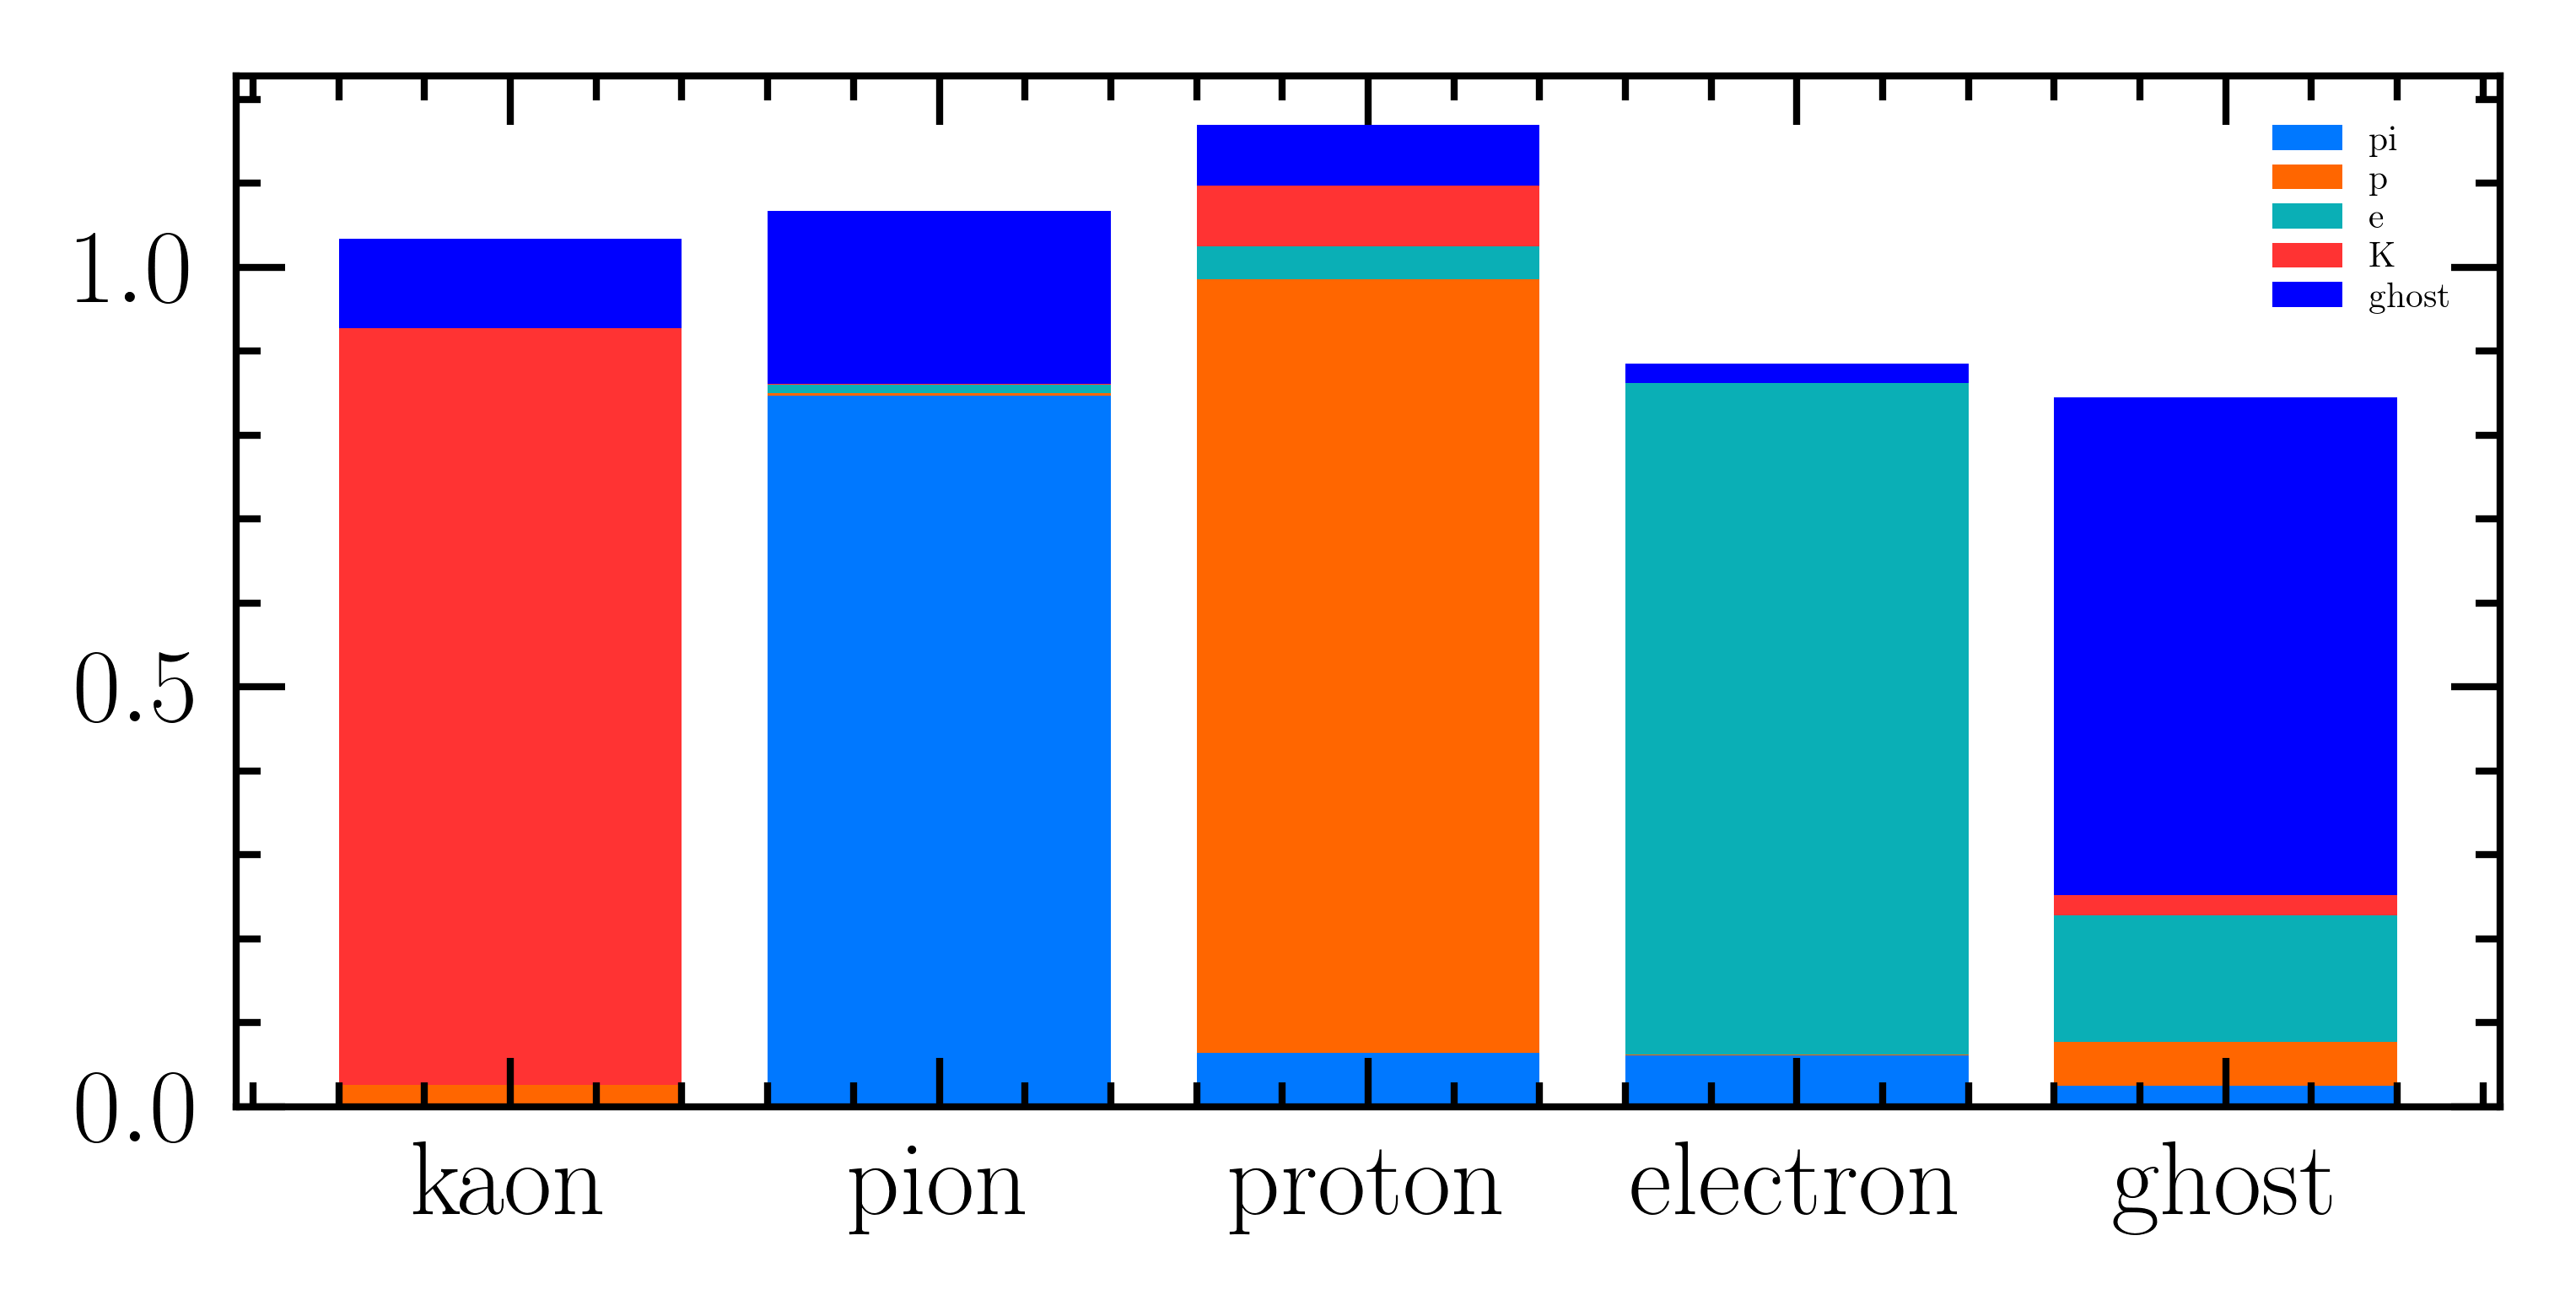

In [32]:
plt.figure(figsize=(10,5))
#muon = plt.bar(x = reco_cuts.keys(), height=muon_first_bin_cvals, label="mu")
pion = plt.bar(x = reco_cuts.keys(), height=pion_first_bin_cvals, bottom=[0], label="pi")
proton = plt.bar(x = reco_cuts.keys(), height=proton_first_bin_cvals, bottom=pion_first_bin_cvals,label="p")
electron = plt.bar(x = reco_cuts.keys(), height=electron_first_bin_cvals, bottom=pion_first_bin_cvals+proton_first_bin_cvals, label="e")
kaon = plt.bar(x = reco_cuts.keys(), height=kaon_first_bin_cvals, bottom=pion_first_bin_cvals+proton_first_bin_cvals+
              electron_first_bin_cvals, label="K")
ghost = plt.bar(x = reco_cuts.keys(), height=ghost_first_bin_cvals, bottom=pion_first_bin_cvals+proton_first_bin_cvals+
              electron_first_bin_cvals+kaon_first_bin_cvals, label="ghost")

plt.legend(fontsize=10)

In [33]:
# now move towards implemneting a fit to the data;
# start by specifying the PIDCalib templates
kaon_template = {
                "name": "kaon_calib_template",
                "data": (kaon_first_bin_cvals).tolist(),
                "modifiers": [
                    {"name": "K_y", "type": "normfactor", "data": None }, # floating normalisation
                    ]
}

pion_template = {
                "name": "pion_calib_template",
                "data": (pion_first_bin_cvals).tolist(),
                "modifiers": [
                    {"name": "pi_y", "type": "normfactor", "data": None }, # floating normalisation
                    ]
}

proton_template = {
                "name": "proton_calib_template",
                "data": (proton_first_bin_cvals).tolist(),
                "modifiers": [
                    {"name": "p_y", "type": "normfactor", "data": None }, # floating normalisation
                    ]
}

# muon_template = {
#                 "name": "muon_calib_template",
#                 "data": (muon_first_bin_cvals).tolist(),
#                 "modifiers": [
#                     {"name": "mu_y", "type": "normfactor", "data": None }, # floating normalisation
#                     ]
# }

electron_template = {
                "name": "electron_calib_template",
                "data": (electron_first_bin_cvals).tolist(),
                "modifiers": [
                    {"name": "e_y", "type": "normfactor", "data": None }, # floating normalisation
                    ]
}

ghost_template = {
                "name": "ghost_calib_template",
                "data": (ghost_first_bin_cvals).tolist(),
                "modifiers": [
                    {"name": "g_y", "type": "normfactor", "data": None }, # floating normalisation
                    ]
}

In [34]:
import json
obs=data_hist[...,0,0,0]

spec = {
    "channels": [
        {
            "name": "singlechannel",
            "samples": [
                kaon_template,
                pion_template,
                proton_template,
                #muon_template, 
                electron_template,
                ghost_template
            ]
        },
    ],
    "observations": [
        {
            "name": "singlechannel",
            "data": obs.view().tolist(),
        },
    ],
    "measurements": [
        { 
            "name": "true_species_y_extraction",
            "config": {
                "poi": "pi_y",
                "parameters": [
                    # bounds on floatig normalisations 
                    {"name":"K_y",   "bounds": [[ 0, obs.sum() ]], "inits":[obs["kaon", ...]] },
                    {"name":"p_y",   "bounds": [[ 0, obs.sum() ]], "inits":[obs["proton", ...]] },
                    {"name":"pi_y",  "bounds": [[ 0, obs.sum() ]], "inits":[obs["pion", ...]] },
                    #{"name":"mu_y",  "bounds": [[ 0, obs.sum() ]], "inits":[obs["muon", ...]] },
                    {"name":"e_y",   "bounds": [[ 0, obs.sum() ]], "inits":[obs["electron", ...]] },
                    {"name":"g_y",   "bounds": [[ 0, obs.sum() ]], "inits":[obs["ghost", ...]] },
                ]
            }
        }
    ],
    "version": "1.0.0"
}

# some long-winded hackly way to produce a json file preserving the format and check the schema
spec = str(json.dumps(spec, indent=4)).replace("None", "null")
with open('./model_spec.json','w') as outfile:
    outfile.write(spec)

In [35]:
import json, requests, jsonschema

In [36]:
# validate schema
workspace = json.load(open('model_spec.json'))
schema = requests.get('https://scikit-hep.org/pyhf/schemas/1.0.0/workspace.json').json()
# If no exception is raised by validate(), the instance is valid.
jsonschema.validate(instance=workspace, schema=schema)
print("SUCCESS: validation of workspace complete")

workspace = pyhf.Workspace(workspace)
print("SUCCESS: workspace read in")

SUCCESS: validation of workspace complete
SUCCESS: workspace read in


In [37]:
# FIT!
pdf = workspace.model(measurement_name = "true_species_y_extraction")
data = workspace.data(pdf)
fit_result, likelihood= pyhf.infer.mle.fit(data, pdf, return_fitted_val=True,return_uncertainties=True)
best_fit = pyhf.infer.mle.fit(data, pdf)
bestfit_pars, par_uncerts = fit_result.T

In [38]:
from uncertainties import *
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
PRESCALED_FIT_RESULTS = {}
for k, v in par_name_dict.items():
    PRESCALED_FIT_RESULTS[k] = ufloat(bestfit_pars[v], par_uncerts[v])
    print(f"Extracted normalisation of {k} = {bestfit_pars[v]} +/- {par_uncerts[v]}")

Extracted normalisation of K_y = 3768.0603755823136 +/- 65.79827293882158
Extracted normalisation of pi_y = 8475.126513642372 +/- 101.40071002700552
Extracted normalisation of p_y = 716.7084251428388 +/- 43.2712182314458
Extracted normalisation of e_y = 291.5340275244364 +/- 35.34057055589719
Extracted normalisation of g_y = 213.5071267391644 +/- 40.09947631793848


In [39]:
par_name_dict

{'K_y': 0, 'pi_y': 1, 'p_y': 2, 'e_y': 3, 'g_y': 4}

In [40]:
data_hist

Hist(
  StrCategory(['kaon', 'pion', 'proton', 'electron', 'ghost']),
  Variable([10000, 20000, 40000, 100000]),
  Variable([1.5, 3, 5]),
  Variable([0, 250, 500]),
  storage=Double()) # Sum: 75589.0

/usera/delaney/miniconda3/envs/FITENV/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
/usera/delaney/miniconda3/envs/FITENV/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator


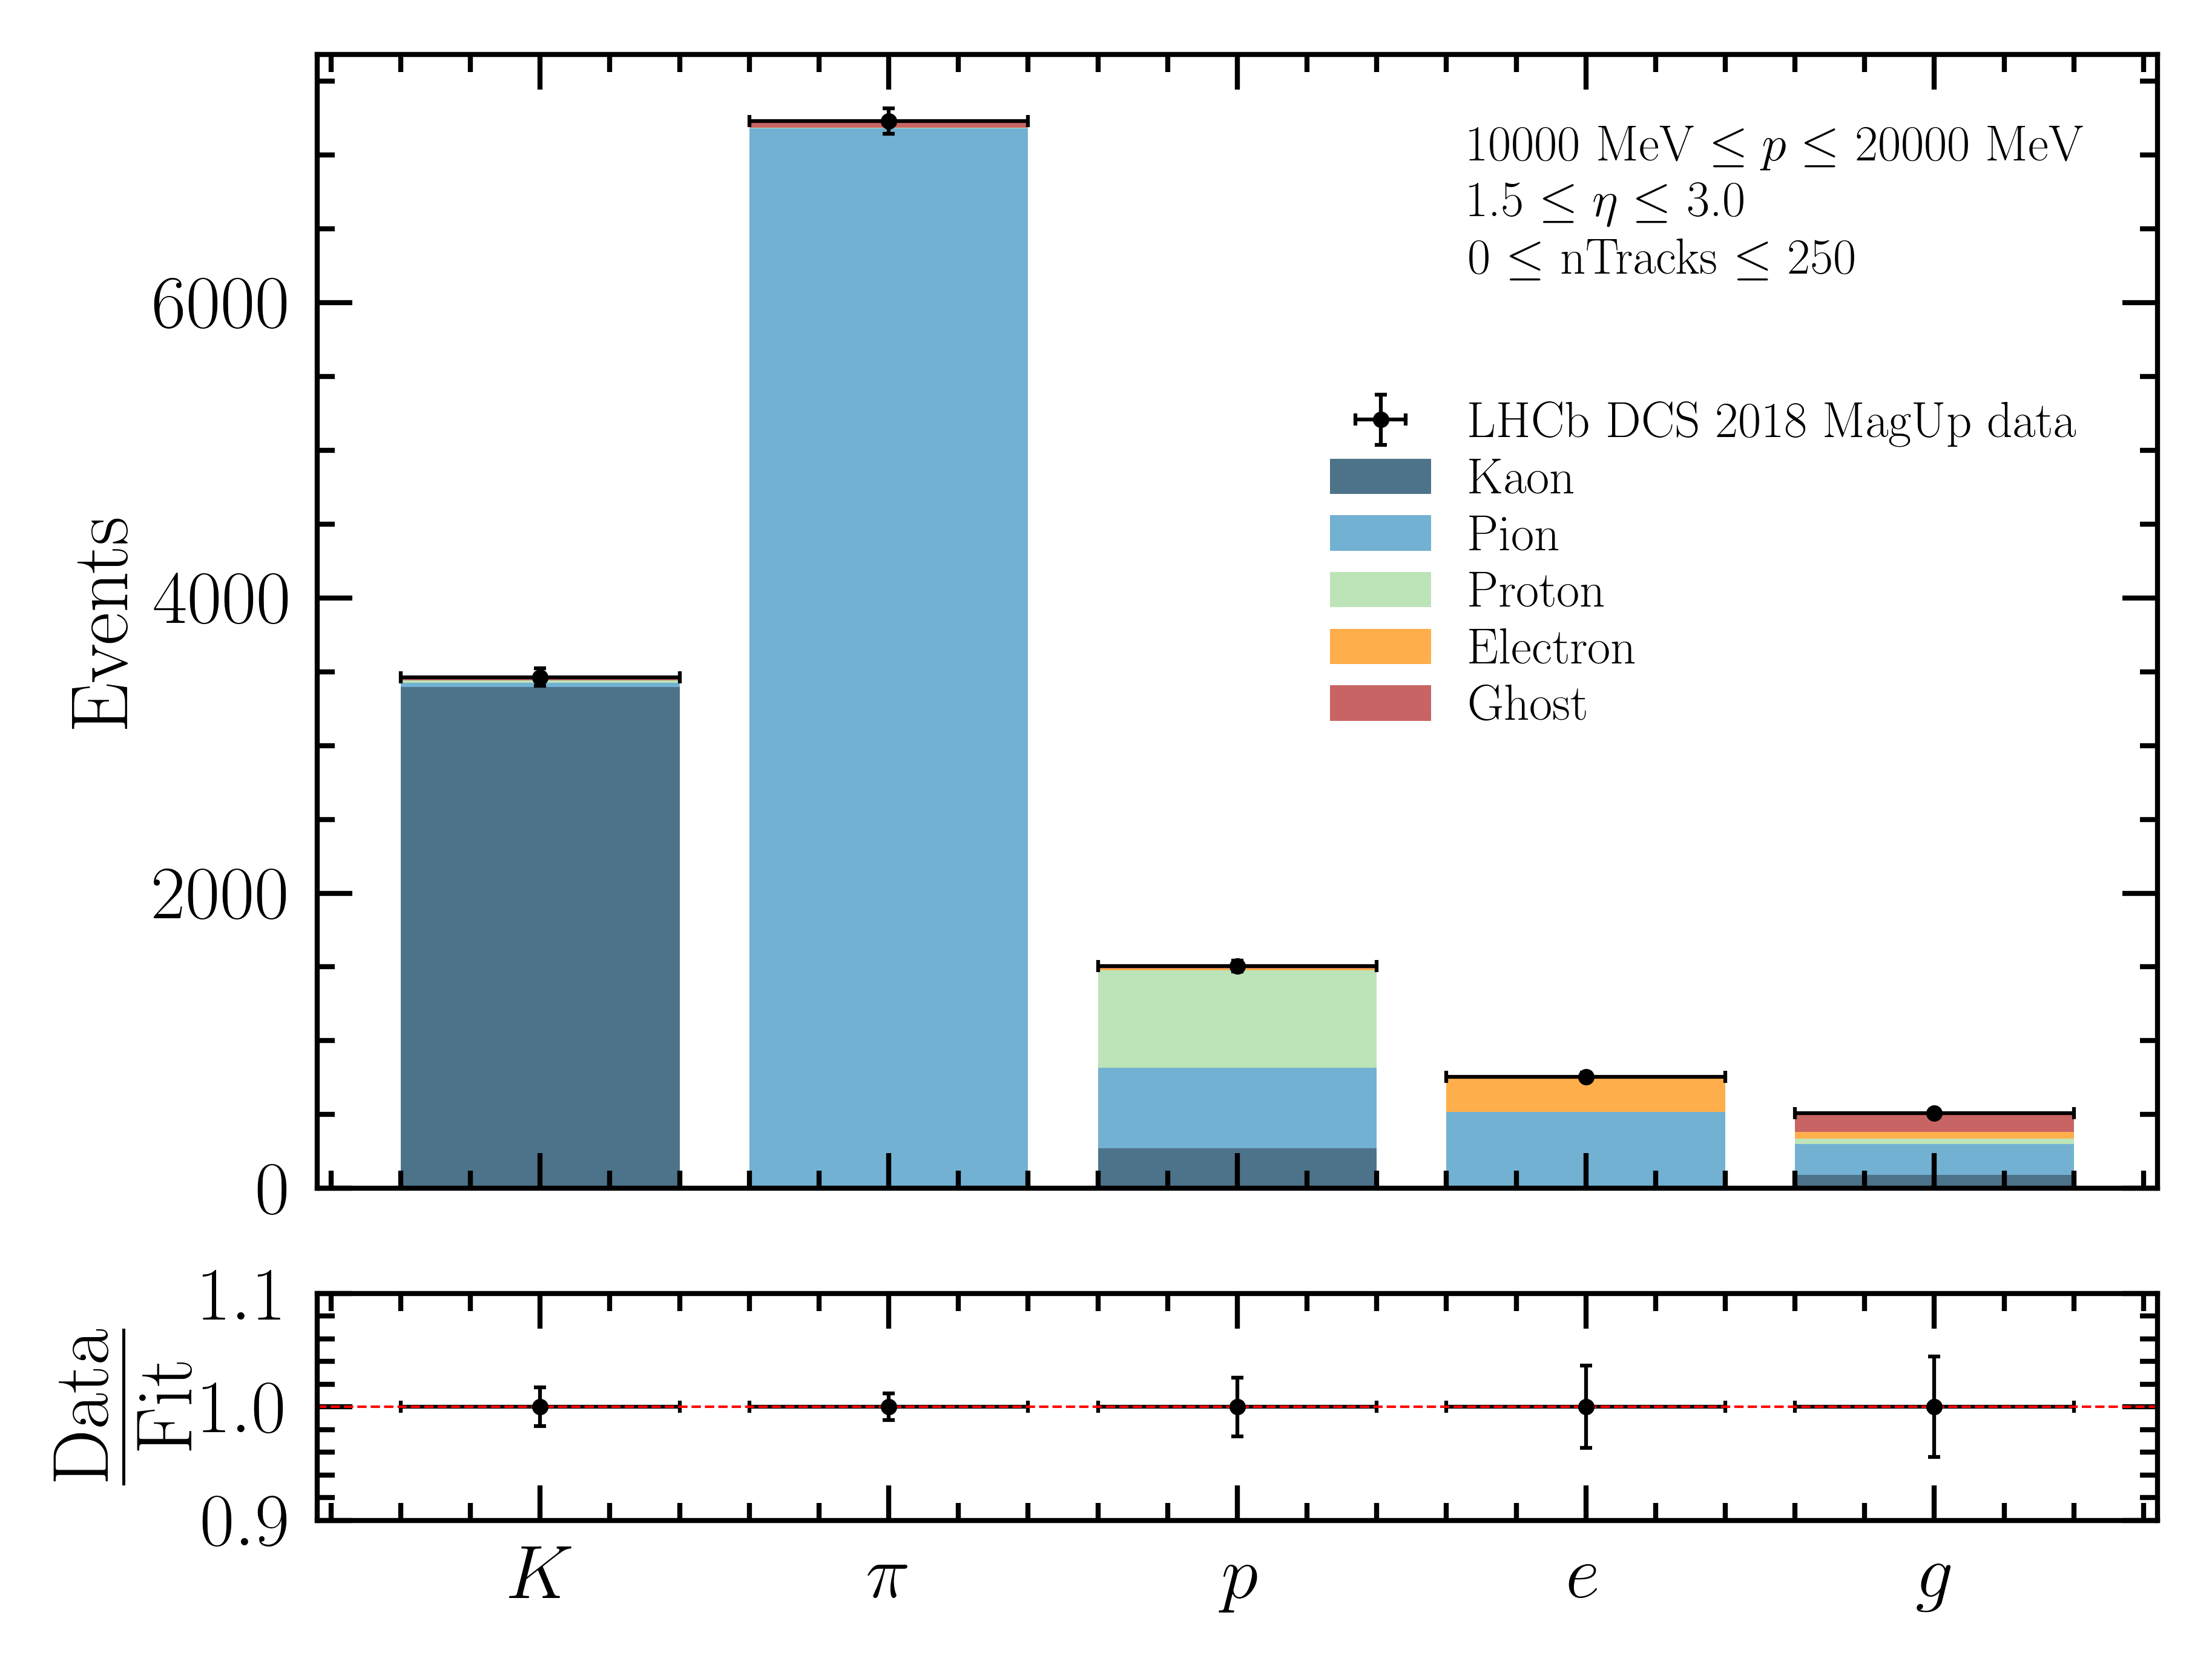

In [41]:
plt.rc("axes", labelweight="bold")
from matplotlib import gridspec
# now proceed to plot
indxs = (0, 0, 0)

# label the bin
P_EDGE_LO = data_hist.axes[1].edges[indxs[0]]
P_EDGE_HI = data_hist.axes[1].edges[indxs[0]+1]

ETA_EDGE_LO = data_hist.axes[2].edges[indxs[0]]
ETA_EDGE_HI = data_hist.axes[2].edges[indxs[0]+1]

NTR_EDGE_LO = data_hist.axes[3].edges[indxs[0]]
NTR_EDGE_HI = data_hist.axes[3].edges[indxs[0]+1]


# scale templates to the yields
fit_k   = kaon_first_bin_cvals * bestfit_pars[0]
fit_pi  = pion_first_bin_cvals * bestfit_pars[1]
fit_p   = proton_first_bin_cvals * bestfit_pars[2]
#fit_mu  = muon_first_bin_cvals * bestfit_pars[3]
fit_e   = electron_first_bin_cvals * bestfit_pars[3]
fit_g   = ghost_first_bin_cvals * bestfit_pars[4]


fig = plt.figure()

gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[5, 1])

# plot the data first
ax = plt.subplot(gs[0])
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction="in")
plt.tick_params(axis='both', which='minor', direction="in")


xvals = np.arange(len(obs.view()))
ax.errorbar(x=xvals, y=obs.view(), yerr=np.sqrt(obs.view()), xerr=.4, fmt=".", color="black", 
             elinewidth=1.5, markersize=10, label=f"LHCb DCS {YEAR} {MAGPOL} data")

# templates
ax.bar(x=xvals,height=fit_k, label="Kaon", bottom=[0], 
        color="#023858", width=.8, alpha=.7)
ax.bar(x=xvals,height=fit_pi, label="Pion", bottom=fit_k, 
        color="#3690c0", width=.8, alpha=.7)
# plt.bar(x=list(obs.axes[0]),height=fit_mu, label="muon pdf", bottom=fit_k+fit_pi+fit_p, 
#         color="#33a02c", width=.8, alpha=.9)
ax.bar(x=xvals,height=fit_p, label="Proton", bottom=fit_k+fit_pi, 
        color="#a1d99b", width=.8, alpha=.7)

ax.bar(x=xvals,height=fit_e, label="Electron", bottom=fit_k+fit_pi+fit_p, 
        color="darkorange", width=.8, alpha=.7)
ax.bar(x=xvals,height=fit_g, label="Ghost", bottom=fit_k+fit_pi+fit_p+fit_e, 
        color="firebrick", width=.8, alpha=.7)

# label bin of kins and occpy
ax.plot([], [], "", label=rf"{int(P_EDGE_LO)} MeV $\leq p \leq $ {int(P_EDGE_HI)} MeV", color="white")
ax.plot([], [], "", label=rf"{ETA_EDGE_LO} $\leq \eta \leq $ {ETA_EDGE_HI} ", color="white")
ax.plot([], [], "", label=rf"{int(NTR_EDGE_LO)} $\leq$ nTracks $\leq$ {int(NTR_EDGE_HI)}", color="white")
ax.plot([], [], "", label="\n", color="white")
plt.legend(fontsize=20)


ax.set_ylabel("Events", loc="center")

# pull plot (missing errors on pulls)
ax1 = plt.subplot(gs[1])

PULLS = (obs.view() / pdf.expected_data(bestfit_pars, include_auxdata=False))
plt.errorbar(x=xvals, y=PULLS, alpha=1.,  color="black", fmt=".", xerr=.4, elinewidth=1.5, markersize=10, 
             yerr=np.sqrt(obs.view())/pdf.expected_data(bestfit_pars, include_auxdata=False))

plt.ylim(0.9, 1.1)
plt.minorticks_on()
plt.axhline(y = 1.0 , color = 'red', linestyle = '--', linewidth=1, alpha=1.) 

ll = ["", r"$K$", r"$\pi$", r"$p$", r"$e$", "$g$"]
ax1.set_xticklabels(ll)
ax.set_xticklabels(ll)
ax.get_shared_x_axes().join(ax, ax1)
ax.set_xticklabels([])
plt.ylabel(r"$\frac{\text{Data}}{\text{Fit}}$", loc="center", fontsize=45)
plt.subplots_adjust(hspace=.0)
plt.savefig("scratch/eff_fit.pdf")
plt.savefig("scratch/eff_fit.png")

In [120]:
# make a check plot: don't want negative efficiencies!
# now proceed to plot
indxs = (0, 0, 0)

# label the bin
P_EDGE_LO = data_hist.axes[1].edges[indxs[0]]
P_EDGE_HI = data_hist.axes[1].edges[indxs[0]+1]

ETA_EDGE_LO = data_hist.axes[2].edges[indxs[0]]
ETA_EDGE_HI = data_hist.axes[2].edges[indxs[0]+1]

NTR_EDGE_LO = data_hist.axes[3].edges[indxs[0]]
NTR_EDGE_HI = data_hist.axes[3].edges[indxs[0]+1]


# scale templates to the yields
tmpl_k   = kaon_first_bin_cvals
tmpl_pi  = pion_first_bin_cvals
tmpl_p   = proton_first_bin_cvals
#fit_mu  = muon_first_bin_cvals * bestfit_pars[3]
tmpl_e   = electron_first_bin_cvals
tmpl_g   = ghost_first_bin_cvals

# errors
err_k   = kaon_first_bin_uncty
err_pi  = pion_first_bin_uncty
err_p   = proton_first_bin_uncty
err_e   = electron_first_bin_uncty
err_g   = ghost_first_bin_uncty

# numberical checks
for t in [tmpl_k, tmpl_pi, tmpl_p, tmpl_e, tmpl_g]:
    assert(t.all()>=0), "ERROR: efficiency template contains negative values"


fig, ax = plt.subplots()
fig.canvas.draw()
plt.minorticks_on()
plt.tick_params(axis='x', which='major', direction="in")
plt.tick_params(axis='y', which='minor', direction="in")

xvals = np.arange(len(obs.view()))

# templates
ax.bar(x=xvals-0.2,height=tmpl_k, label="Kaon", bottom=[0], 
        color="#005a32", width=.1, alpha=.8)

ax.bar(x=xvals-.1,height=tmpl_pi, label="Pion", bottom=[0], 
        color="darkcyan", width=.1, alpha=.8)
# plt.bar(x=list(obs.axes[0]),height=fit_mu, label="muon pdf", bottom=fit_k+fit_pi+fit_p, 
#         color="#33a02c", width=.8, alpha=.9)
ax.bar(x=xvals,height=tmpl_p, label="Proton", bottom=[0], 
        color="aquamarine", width=.1, alpha=.8)

ax.bar(x=xvals+.1,height=tmpl_e, label="Electron", bottom=[0], 
        color="darkorange", width=.1, alpha=.8)
ax.bar(x=xvals+.2,height=tmpl_g, label="Ghost", bottom=[0], 
        color="indianred", width=.1, alpha=.8)

# label bin of kins and occpy
ax.plot([], [], "", label=rf"{int(P_EDGE_LO)} MeV $\leq p \leq $ {int(P_EDGE_HI)} MeV", color="white")
ax.plot([], [], "", label=rf"{ETA_EDGE_LO} $\leq \eta \leq $ {ETA_EDGE_HI} ", color="white")
ax.plot([], [], "", label=rf"{int(NTR_EDGE_LO)} $\leq$ nTracks $\leq$ {int(NTR_EDGE_HI)}", color="white")
ax.plot([], [], "", label="\n", color="white")
plt.legend(fontsize=10)

#ax.set_yscale("log")
ax.set_ylabel("PIDCalib $pdf$s, normalised to unity")

ll = ["", r"$K$", r"$\pi$", r"$p$", r"$e$", "$g$"]
ax.set_xticklabels(ll)
plt.savefig("scratch/eff_sanity_check.pdf")
plt.savefig("scratch/eff_sanity_check.png")

NameError: name 'data_hist' is not defined